# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



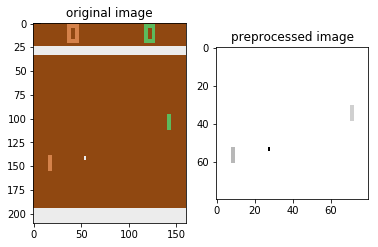

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride + 2*pad)/stride 
        # (truncate if not an integer)

        # convolutional layers
        self.conv1 = nn.Conv2d(2,  4, kernel_size=4, stride=2) #outputsize = 4x39x39
        self.conv2 = nn.Conv2d(4, 16, kernel_size=4, stride=2) #outputsize = 16x18x18
        self.conv_size = 16*18*18
        
        # fully connected layers
        fc1_size = 256
        self.fc1 = nn.Linear(self.conv_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        
        # flatten the tensor
        x = x.view(-1, self.conv_size)
        
        x = F.leaky_relu(self.fc1(x))
        x = self.sig(self.fc2(x))
        
        return x


# run your own policy!
policy=Policy().to(device)
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


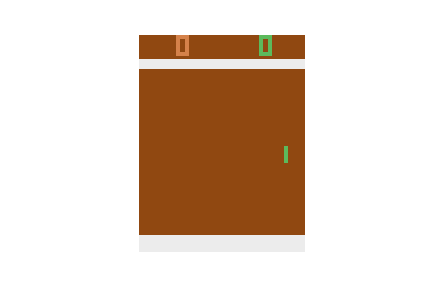
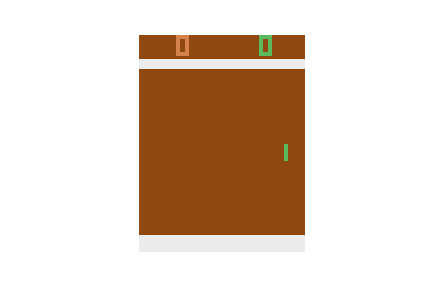
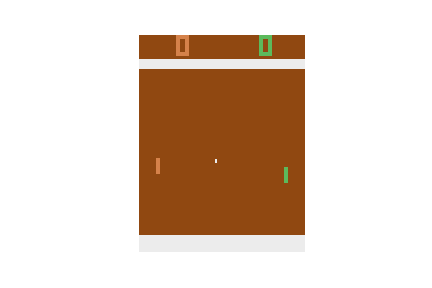
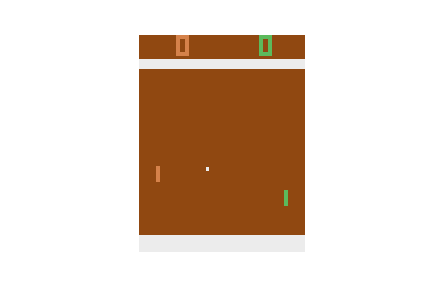
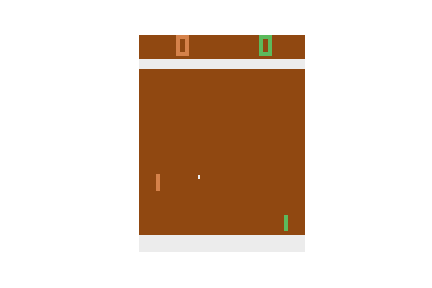
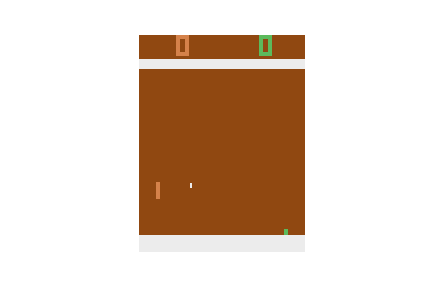
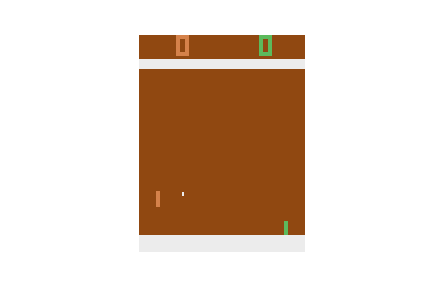
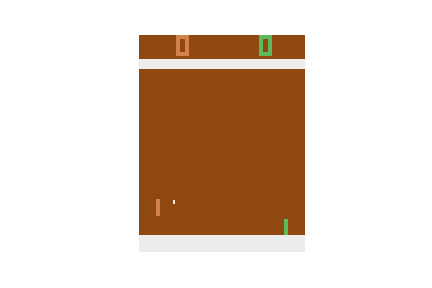
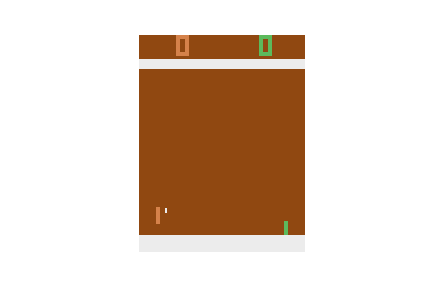
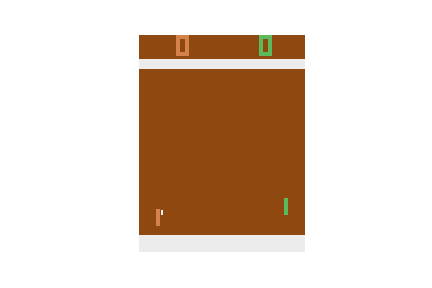
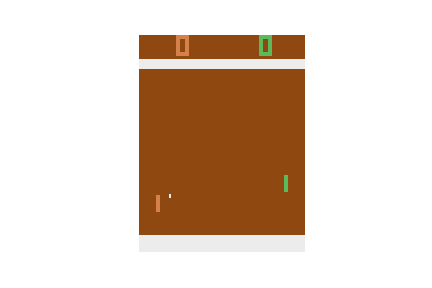
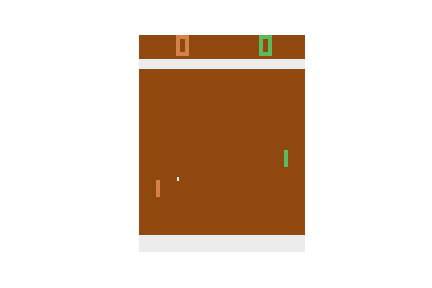
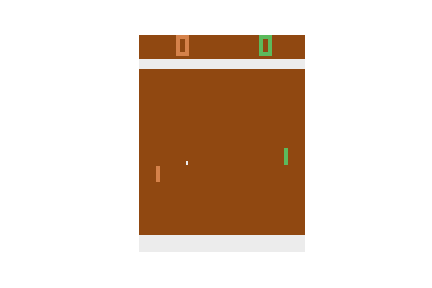
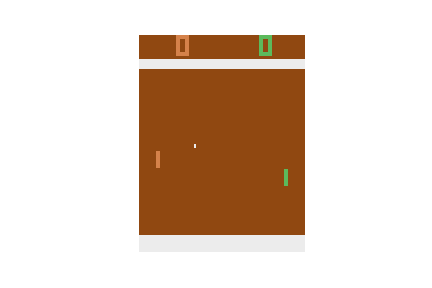
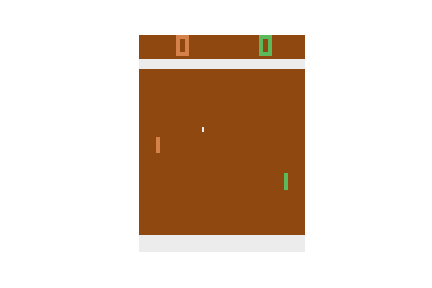
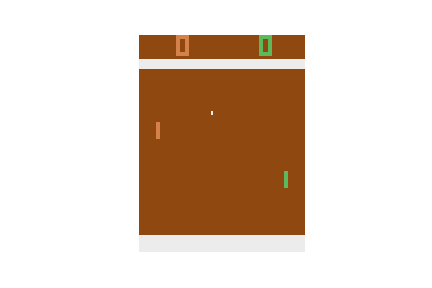
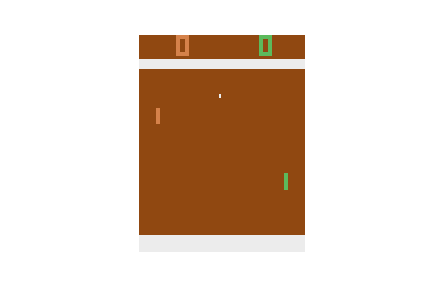
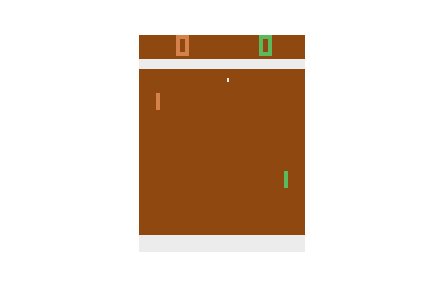
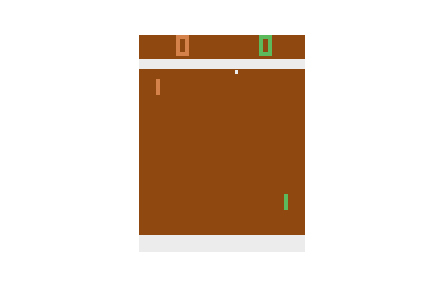
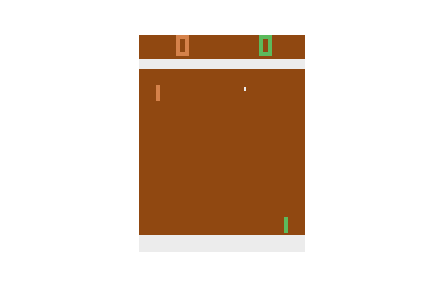
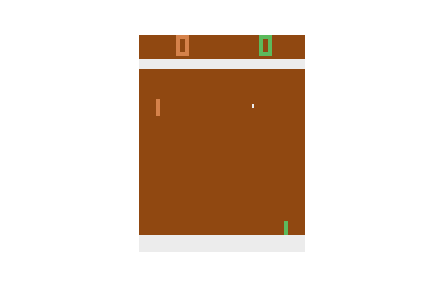
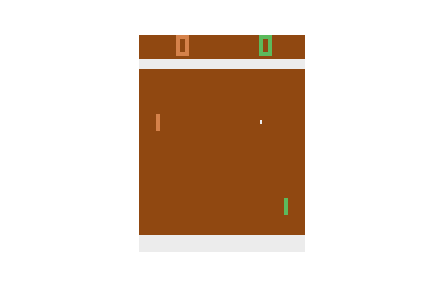
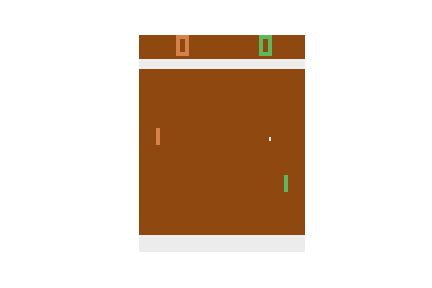
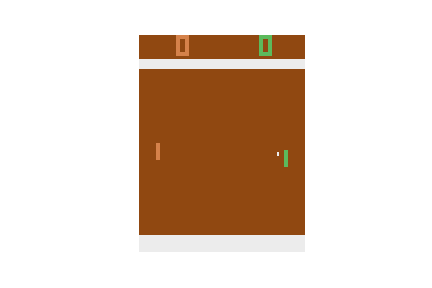
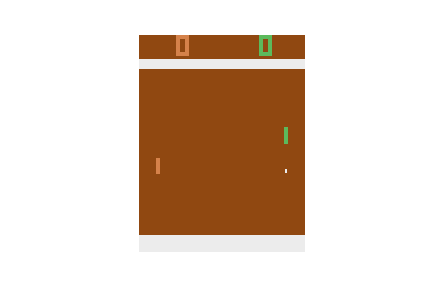
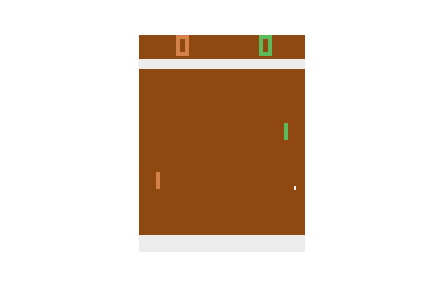
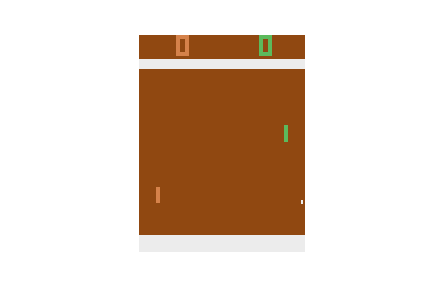
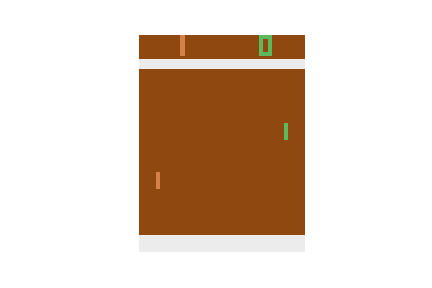
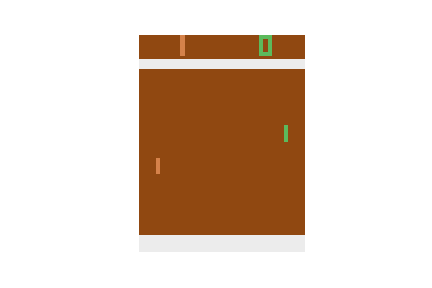
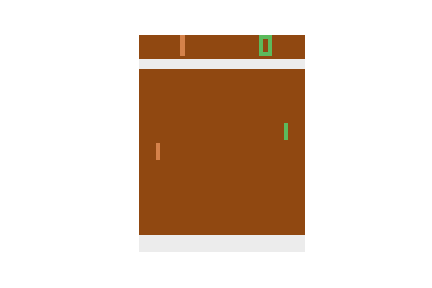
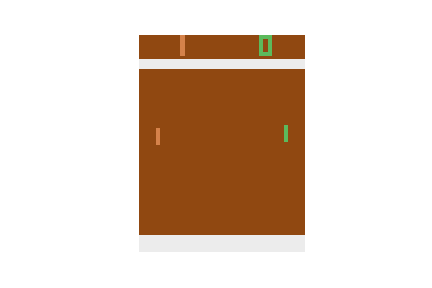
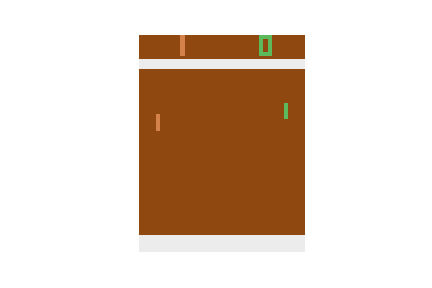
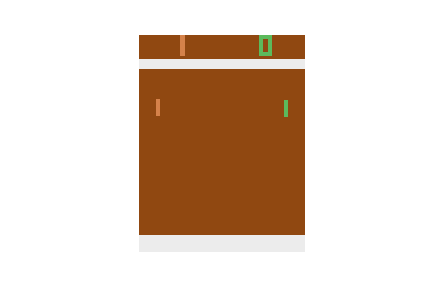
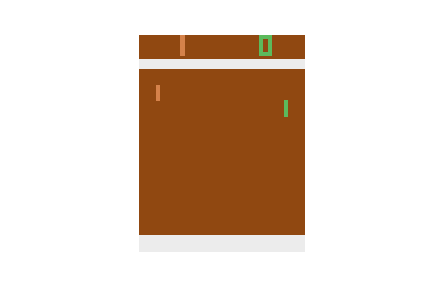
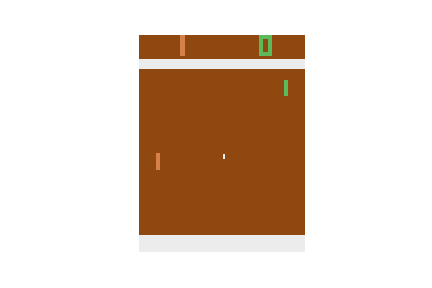
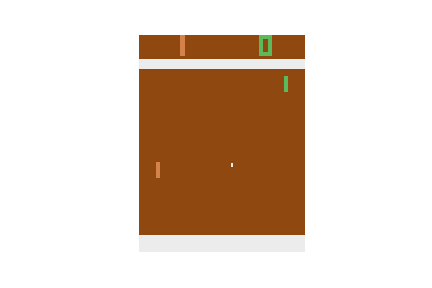
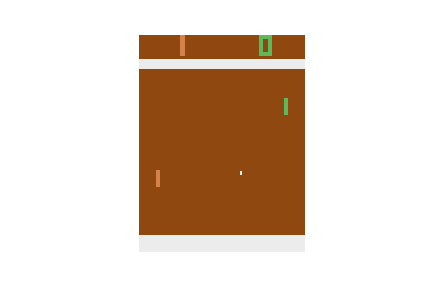
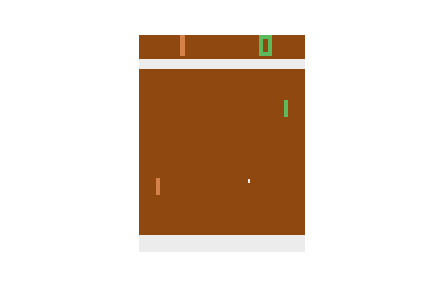
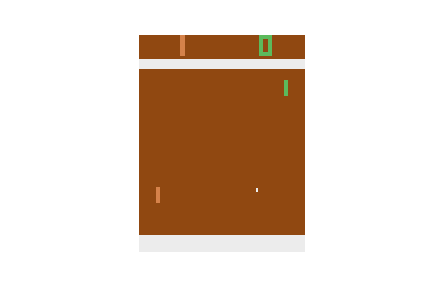
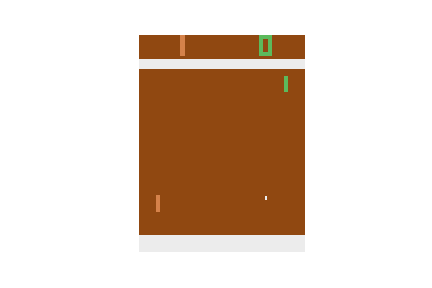
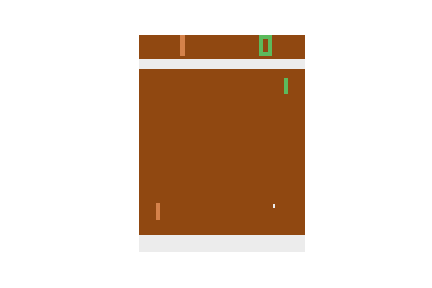
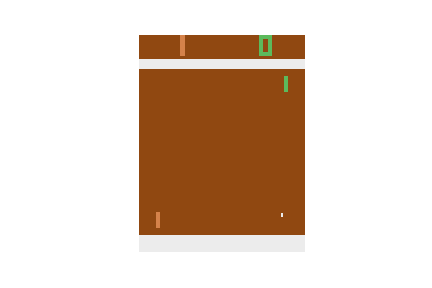
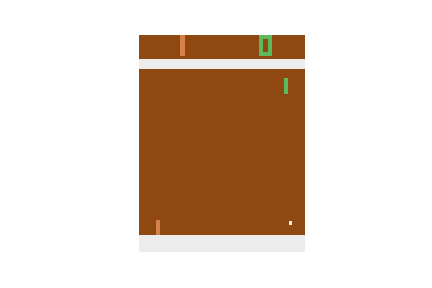
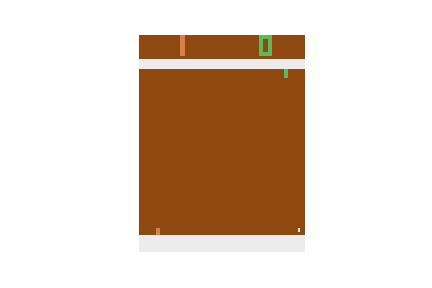
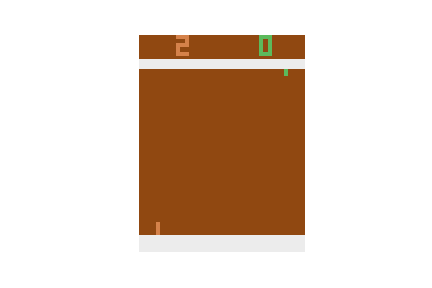
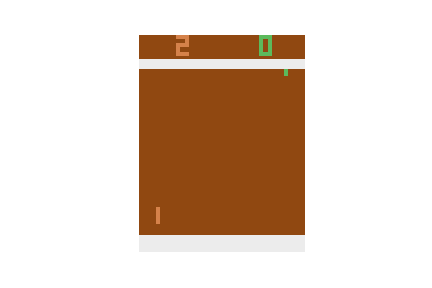
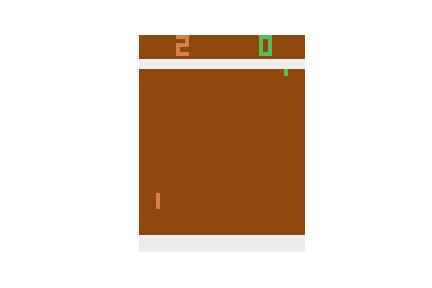
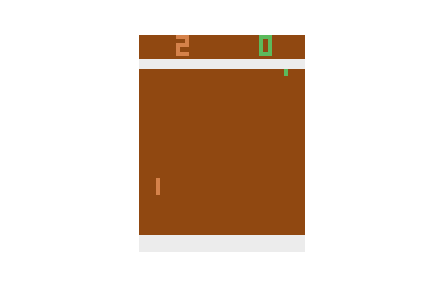
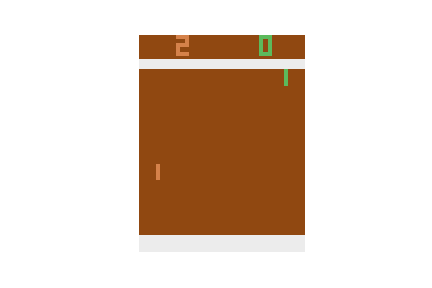
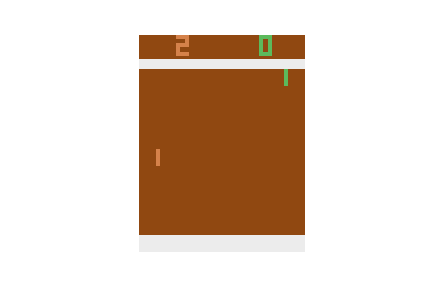
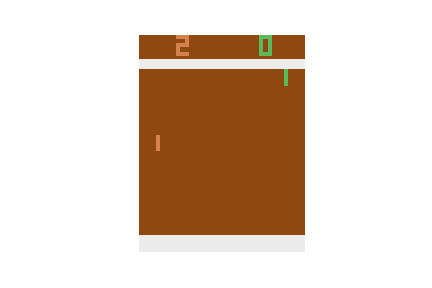
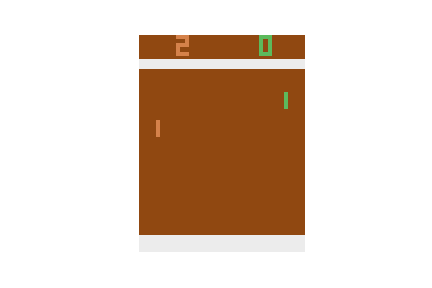
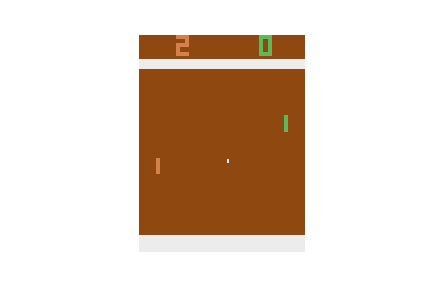
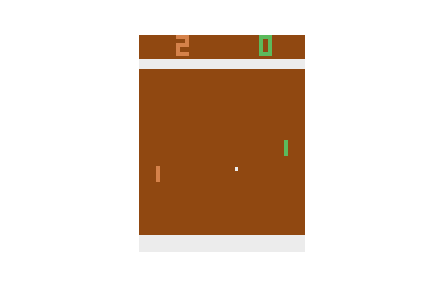
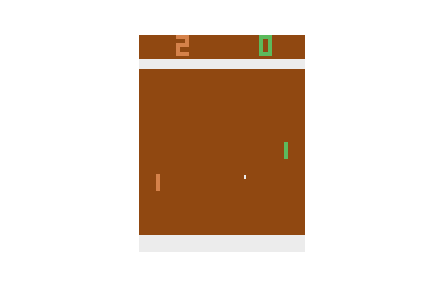
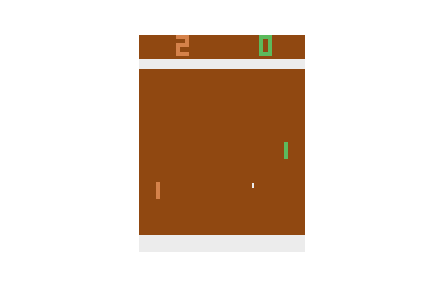
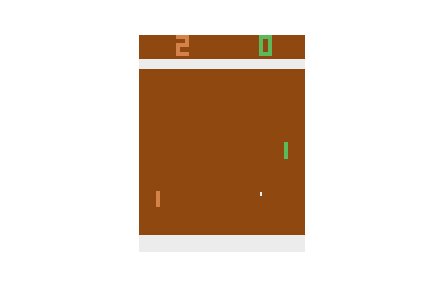
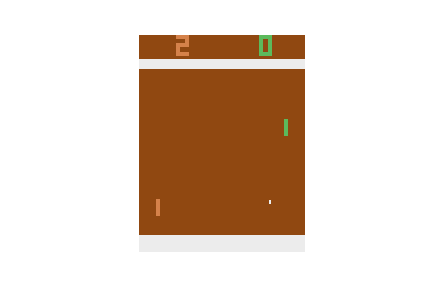
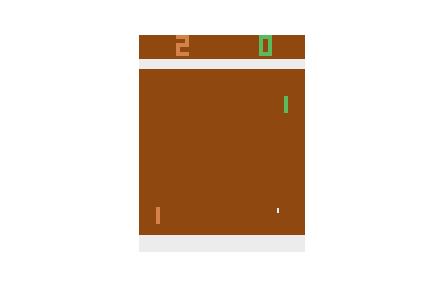
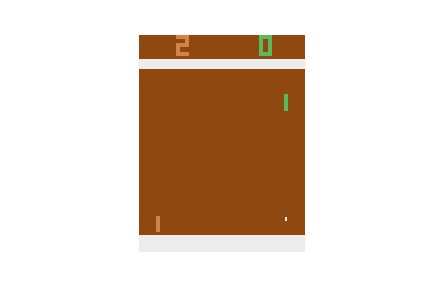
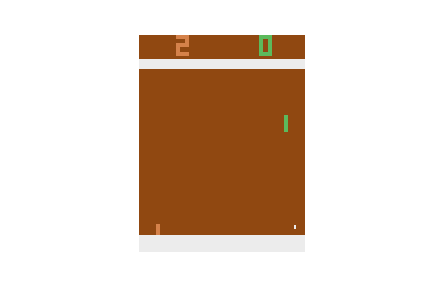
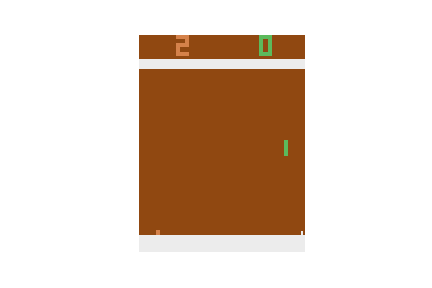
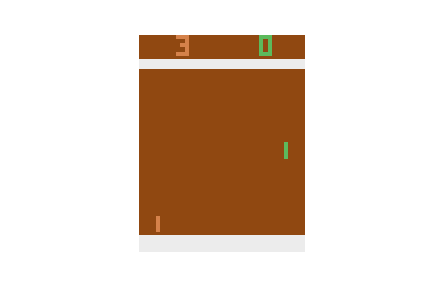
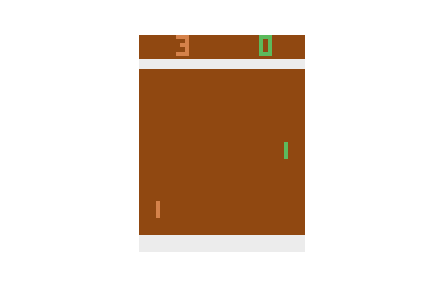
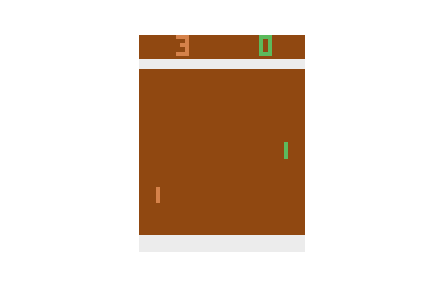
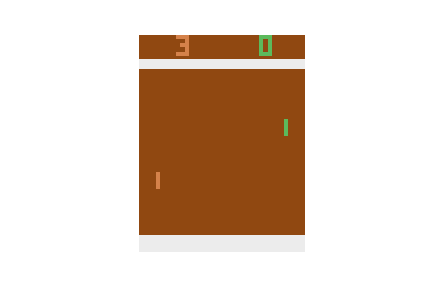
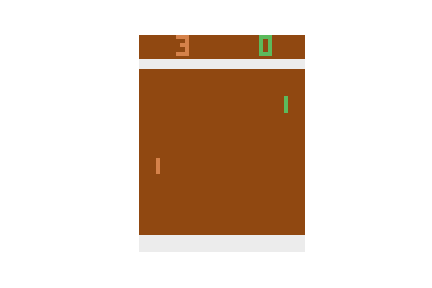
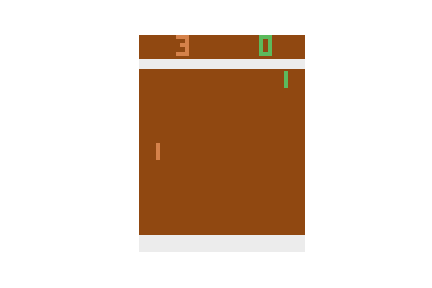
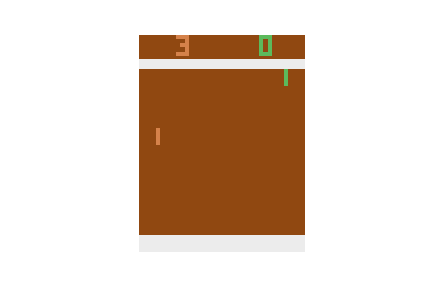
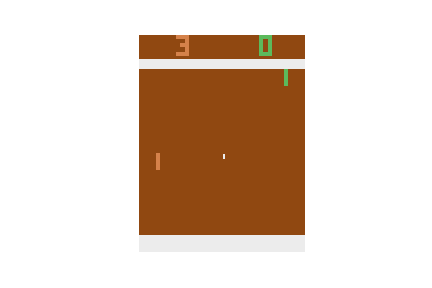
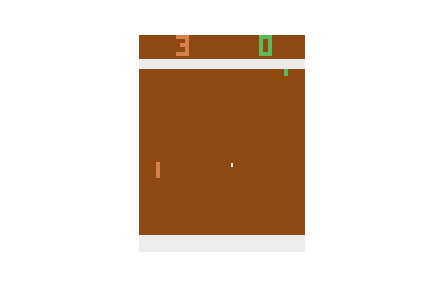
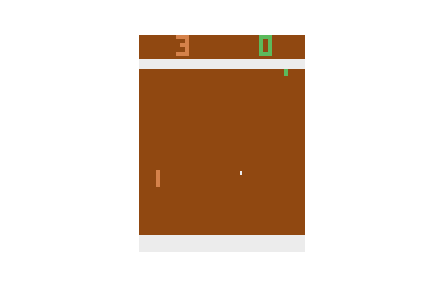
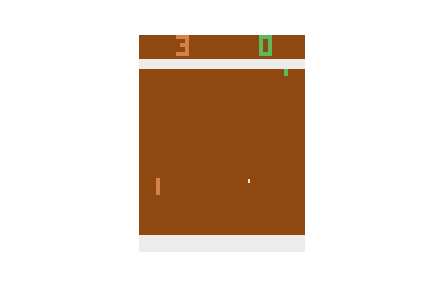
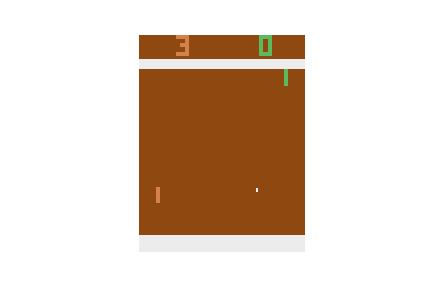
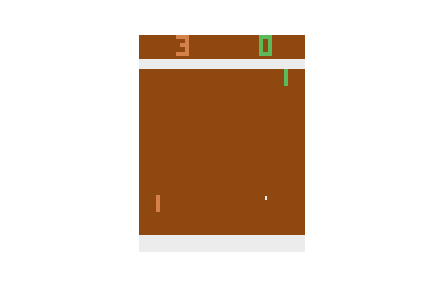
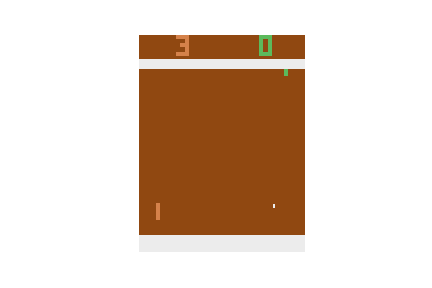
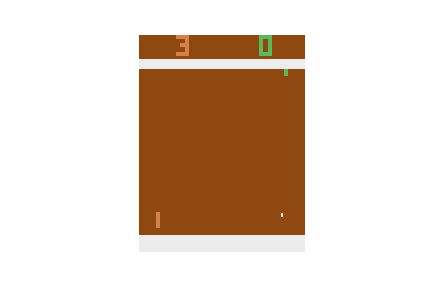
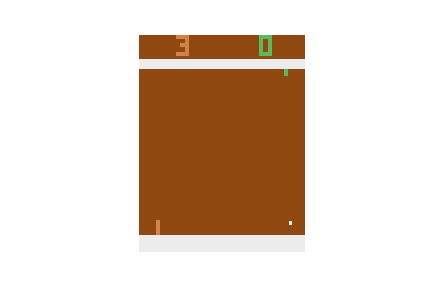
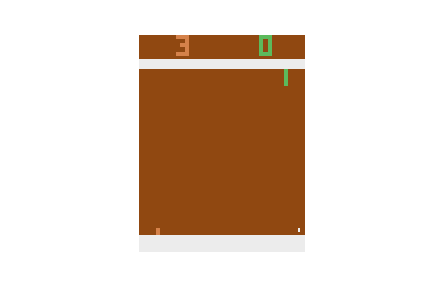
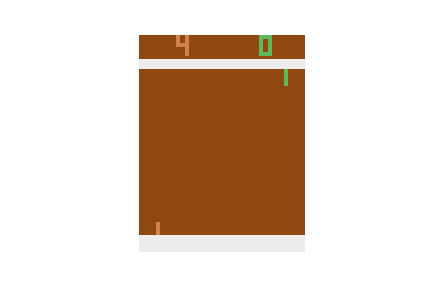
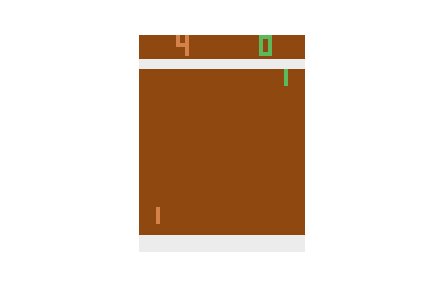
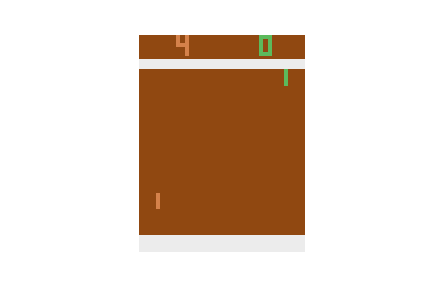
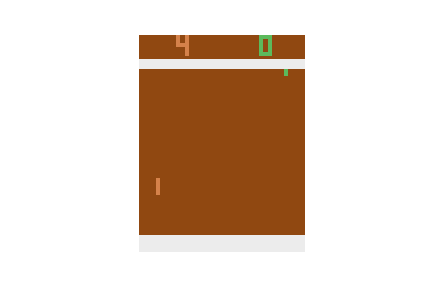
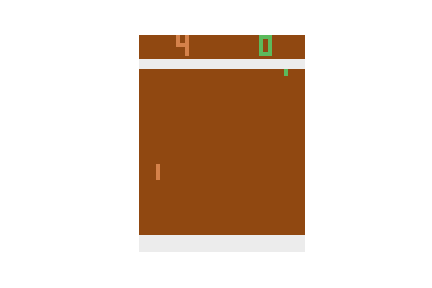
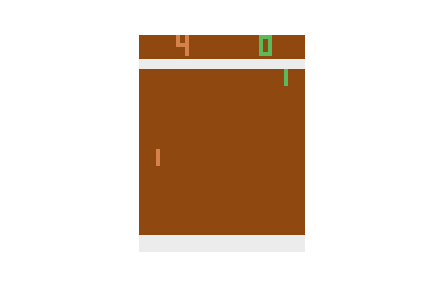
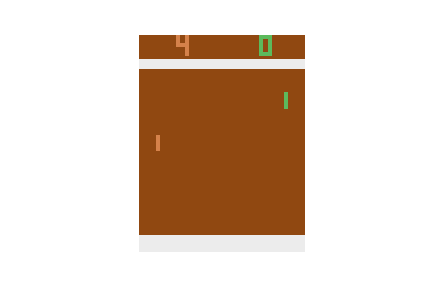
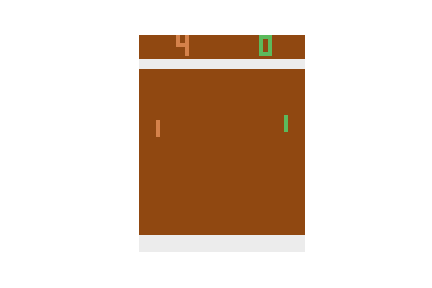
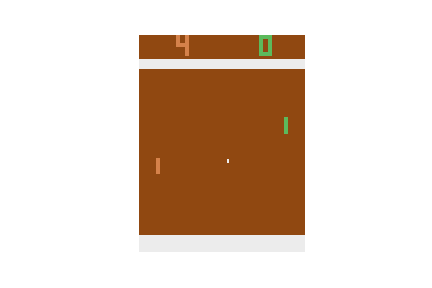
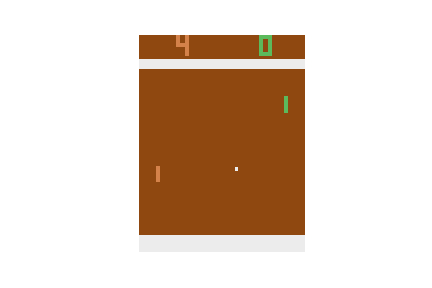
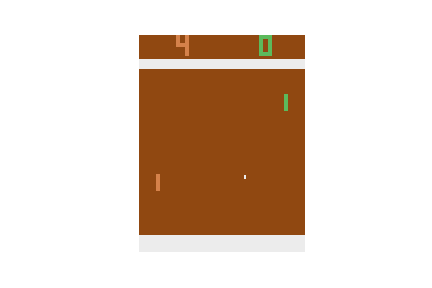
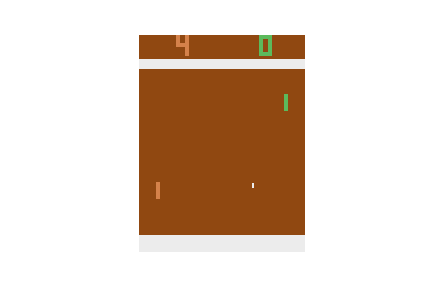
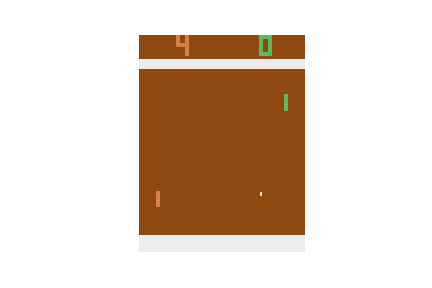
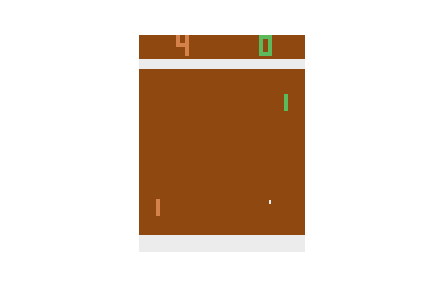
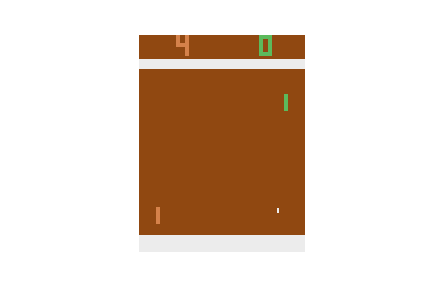
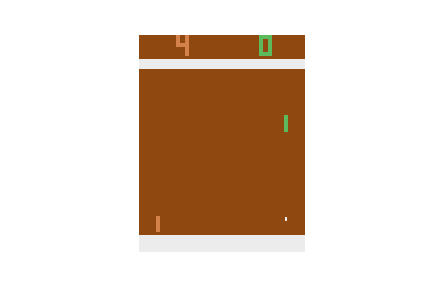
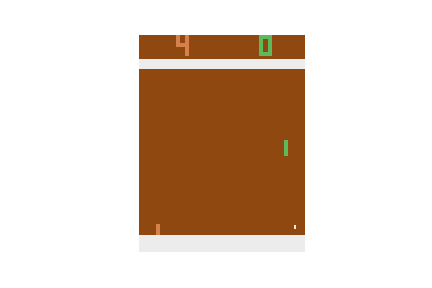
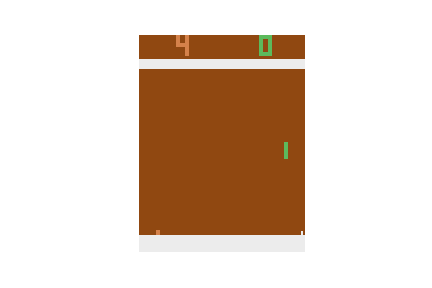
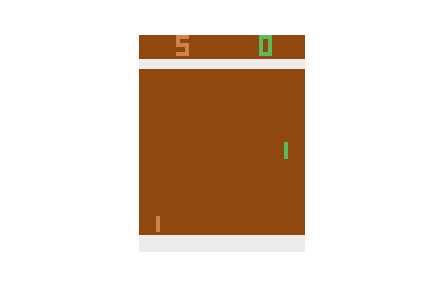
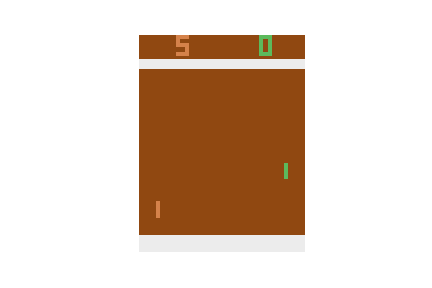
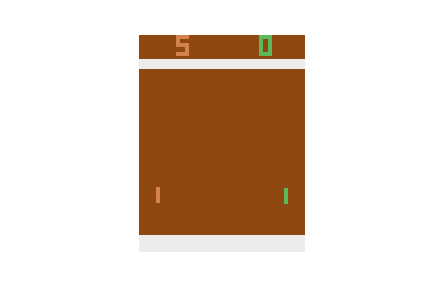
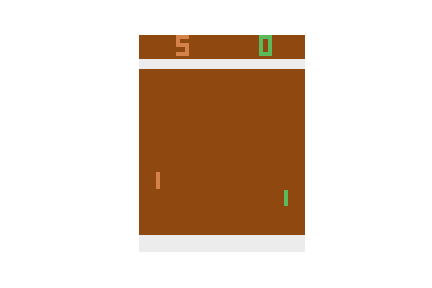
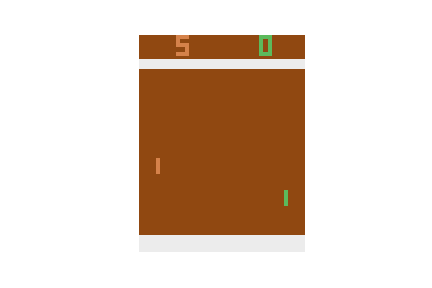
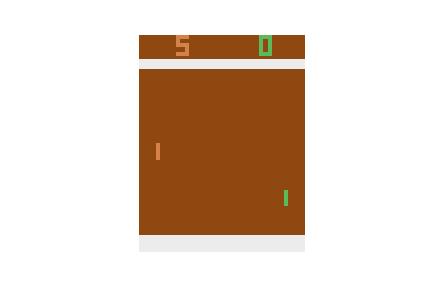
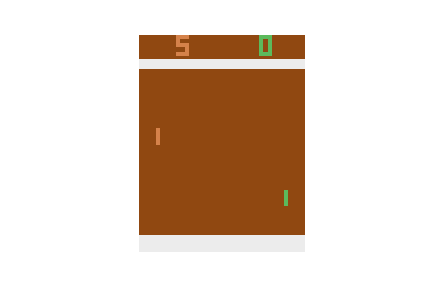
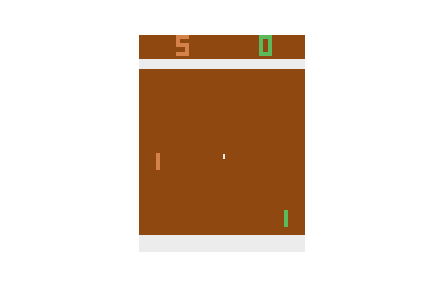
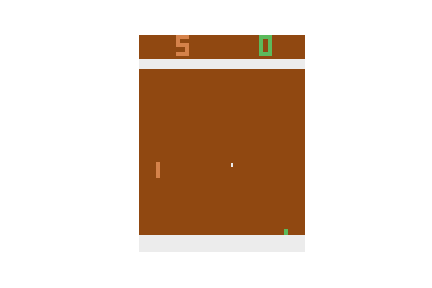
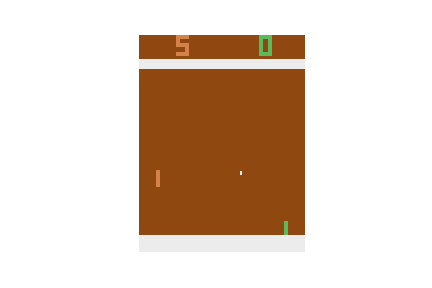
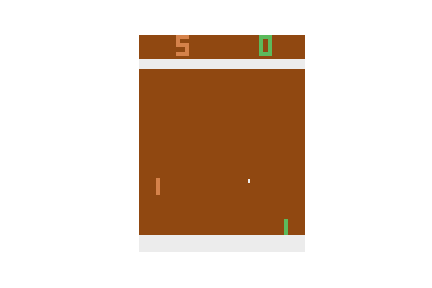
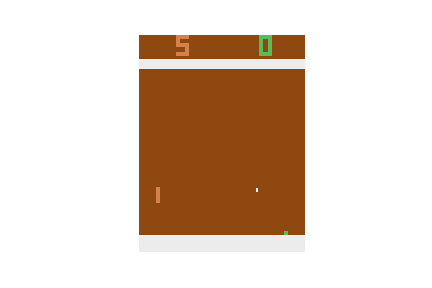
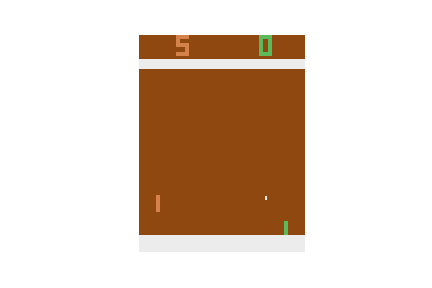
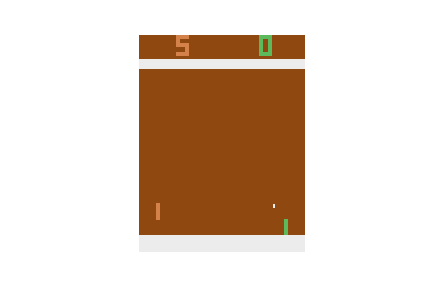
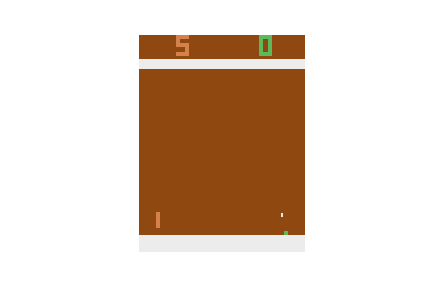
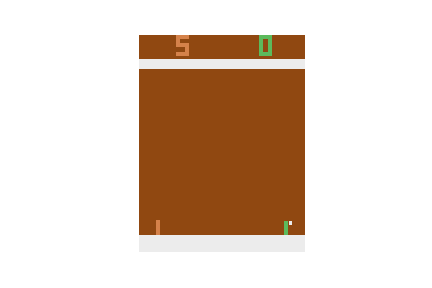
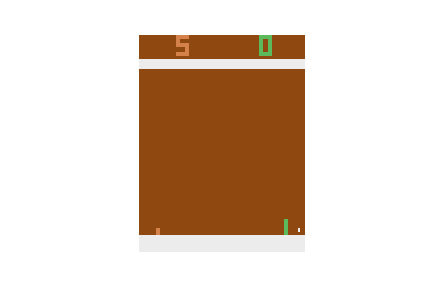
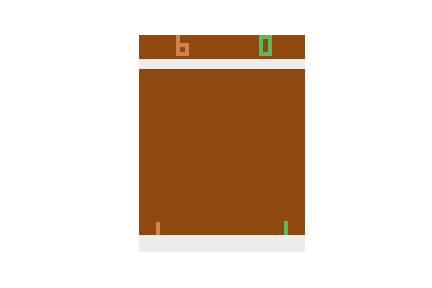
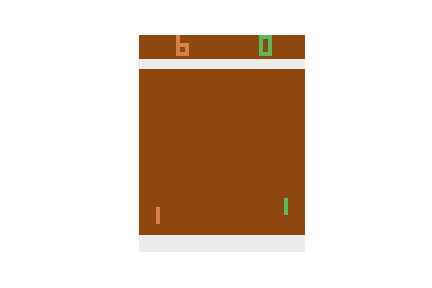
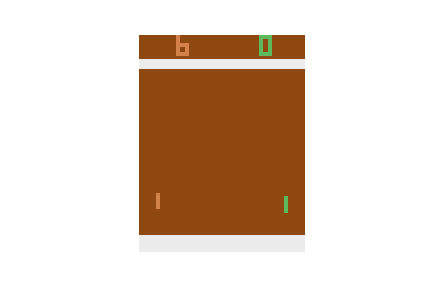
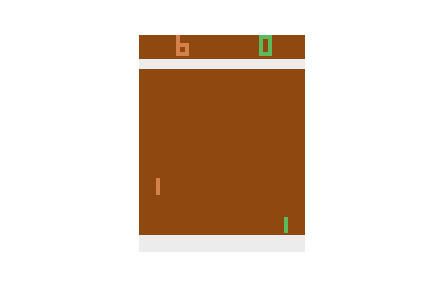
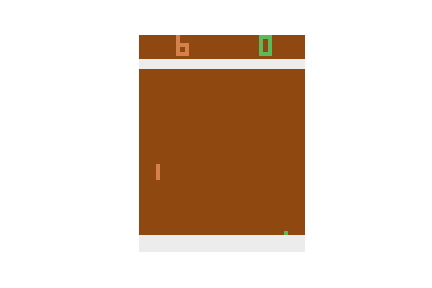
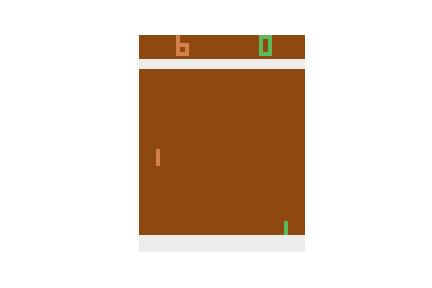
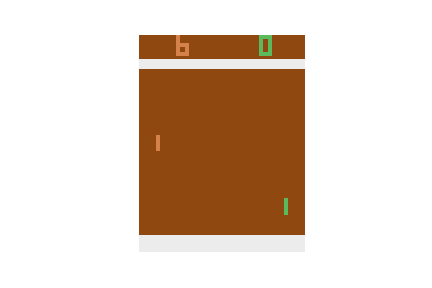
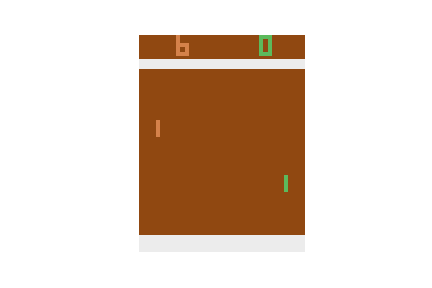
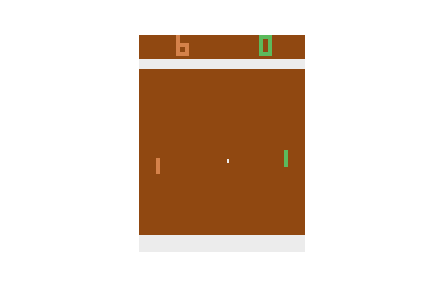
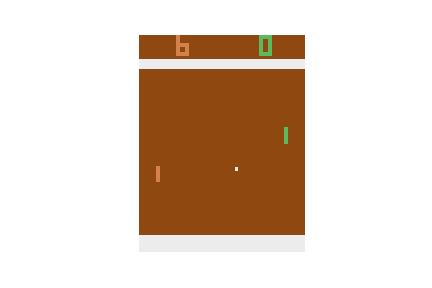
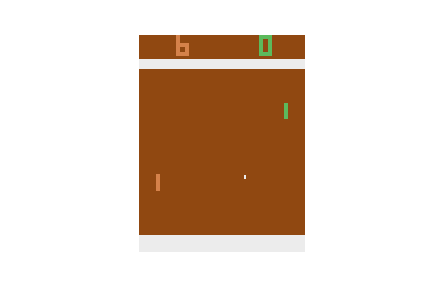
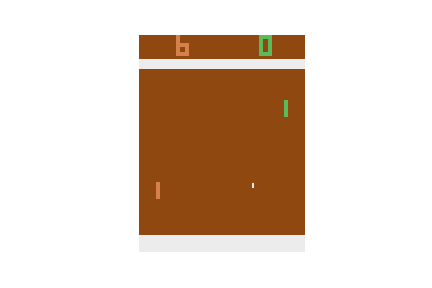
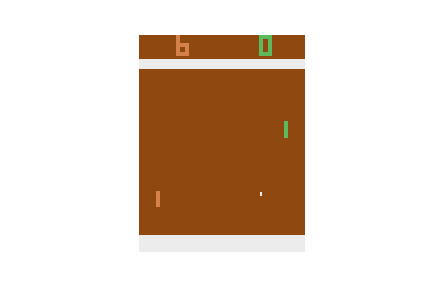
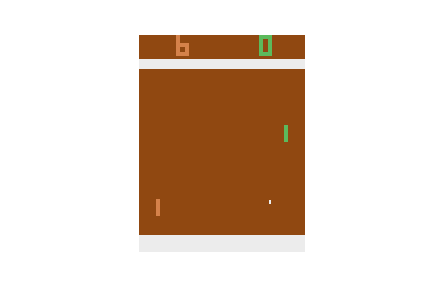
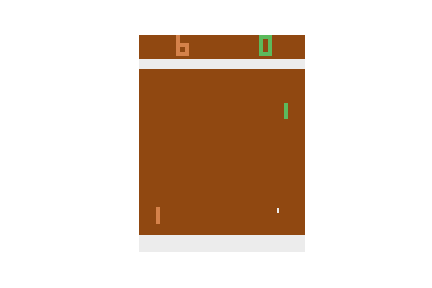
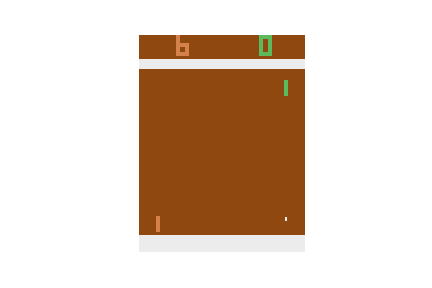
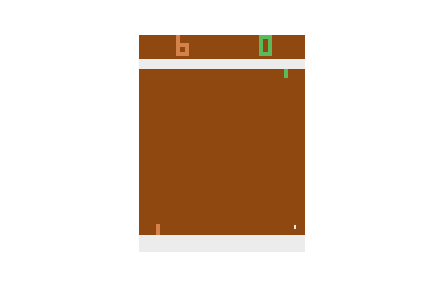
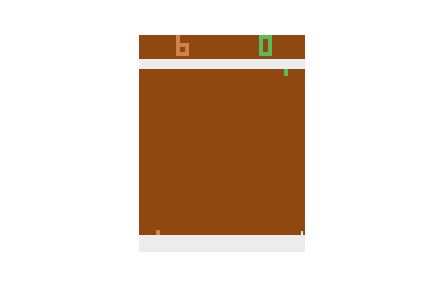
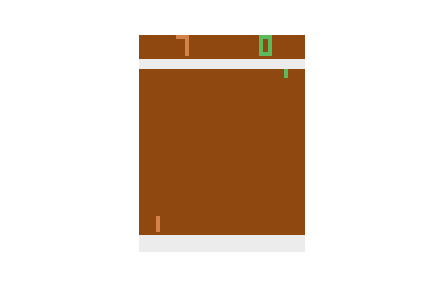
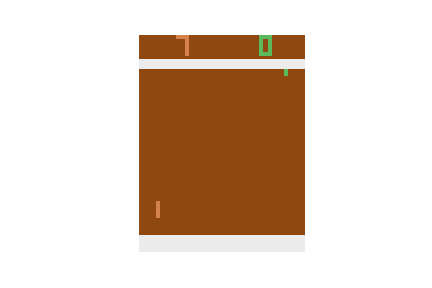
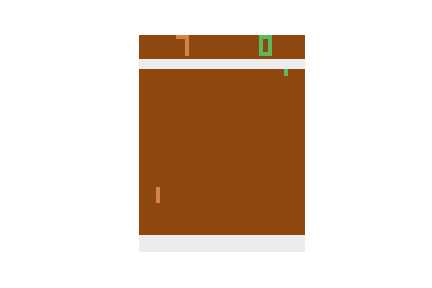
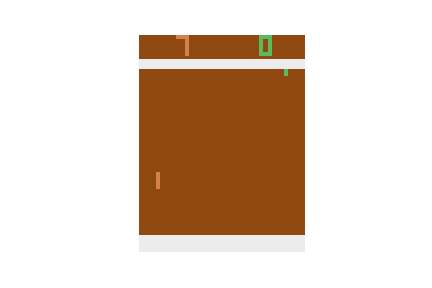
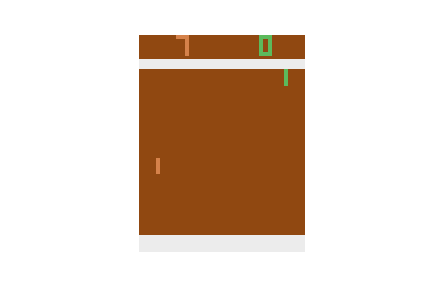
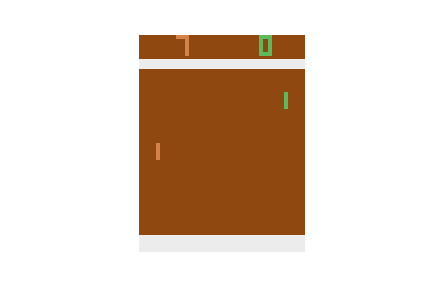
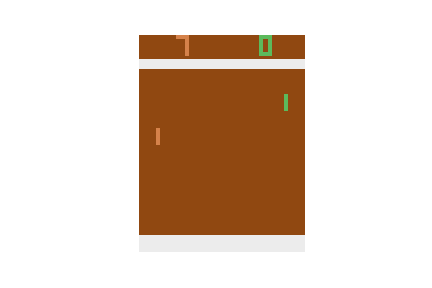
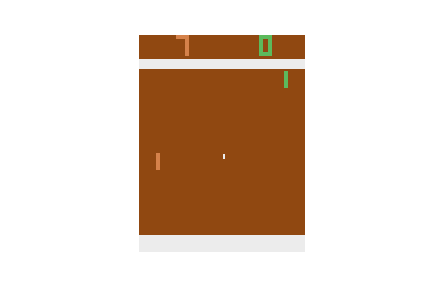
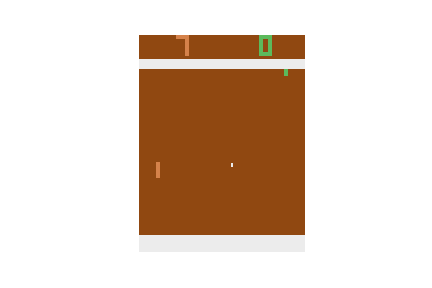
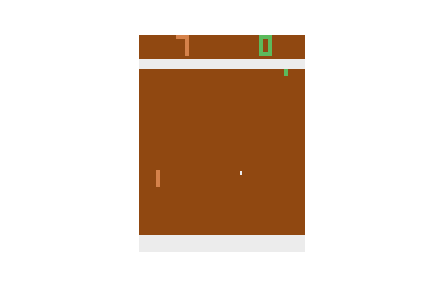
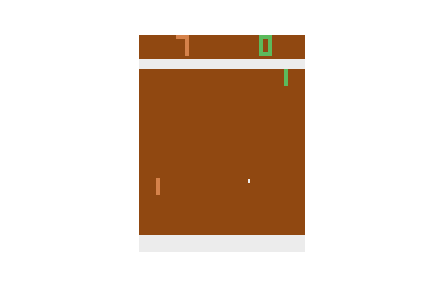
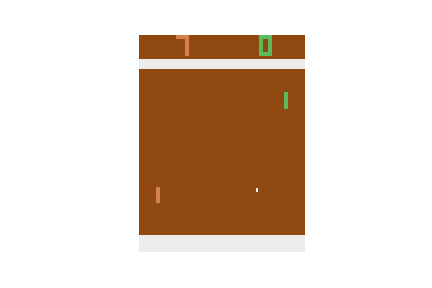
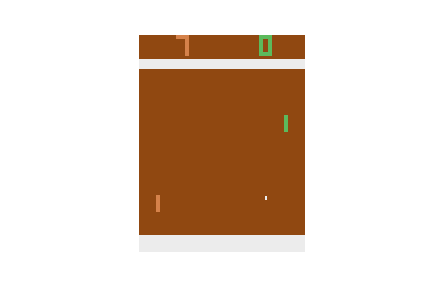
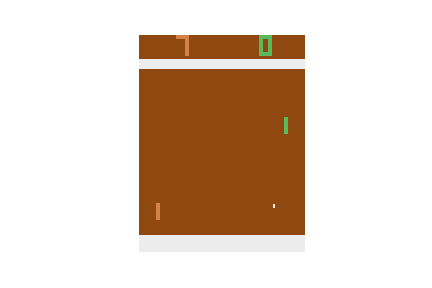
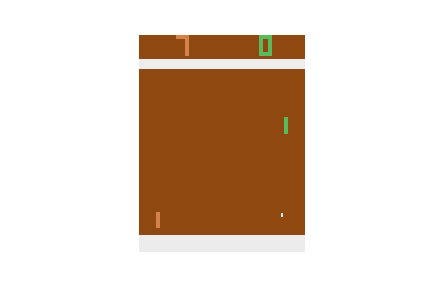
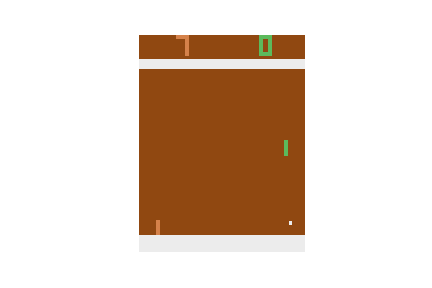
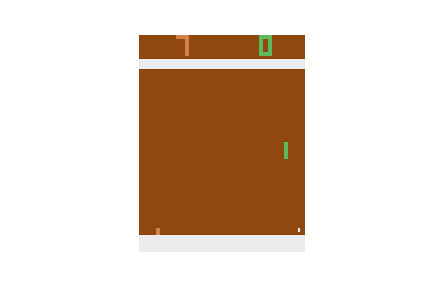
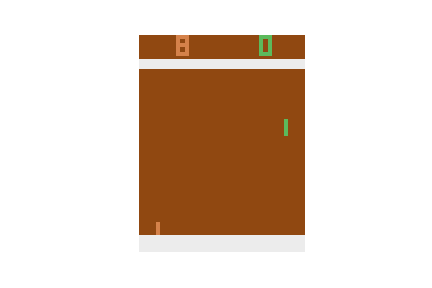
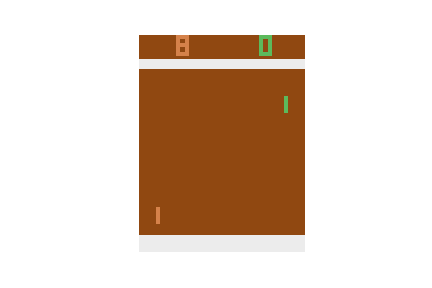
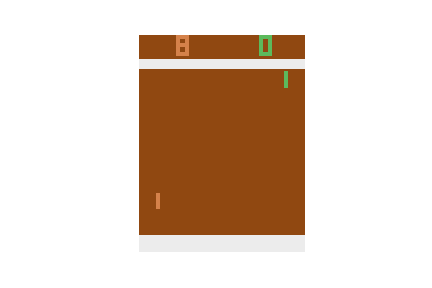
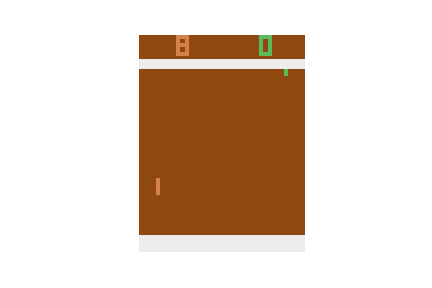
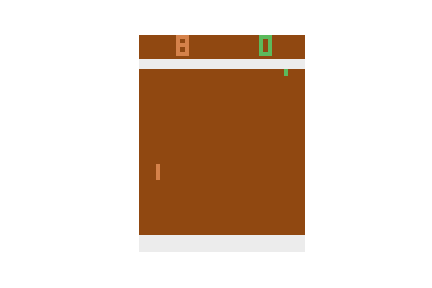
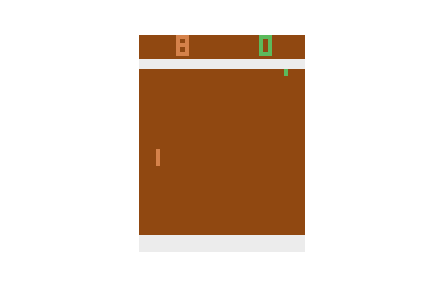
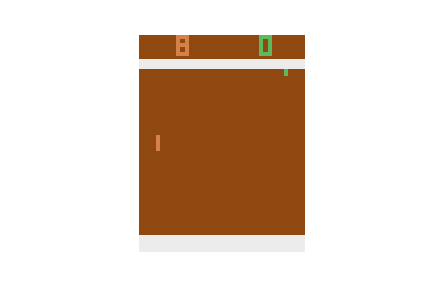
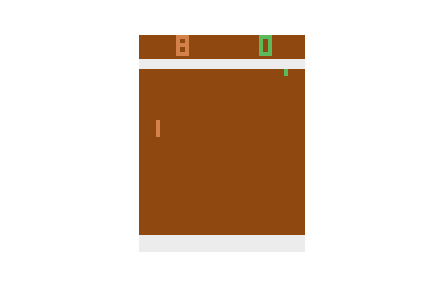
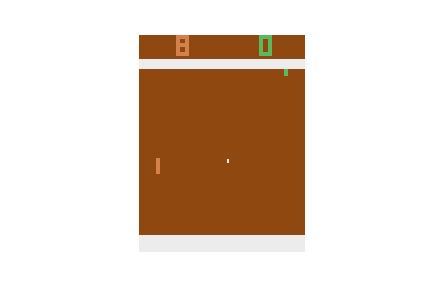
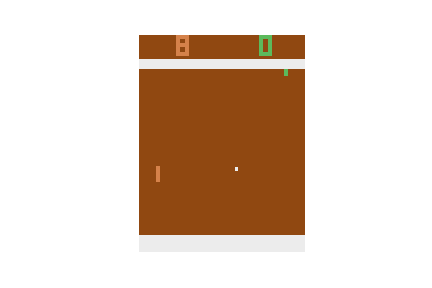
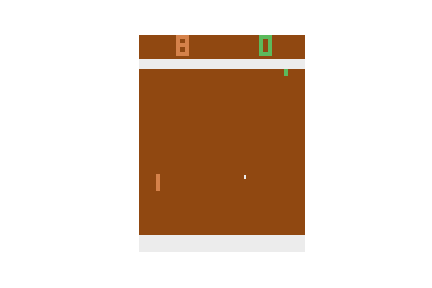
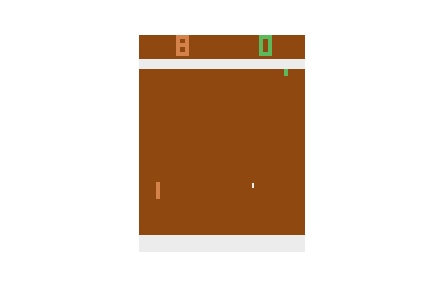
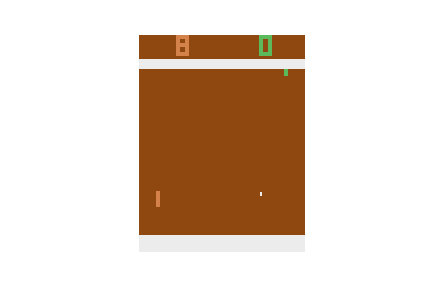
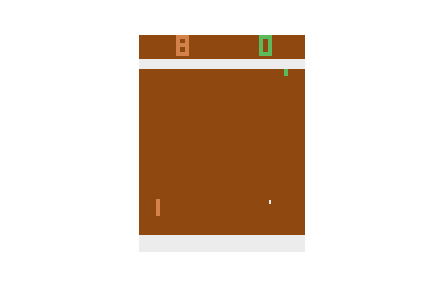
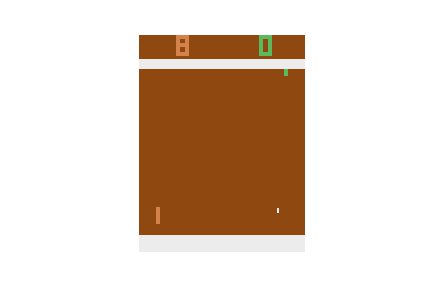
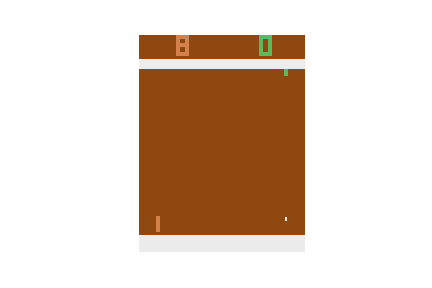
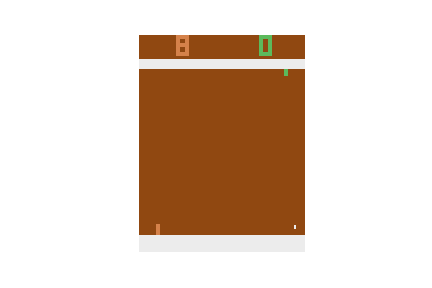
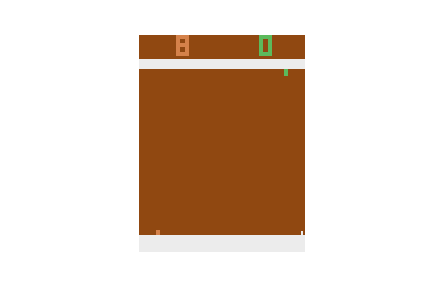
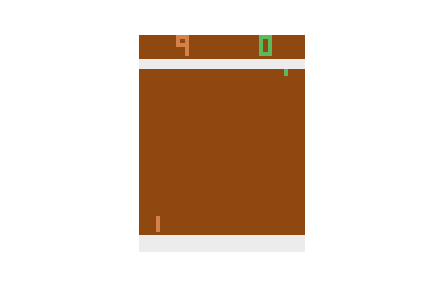
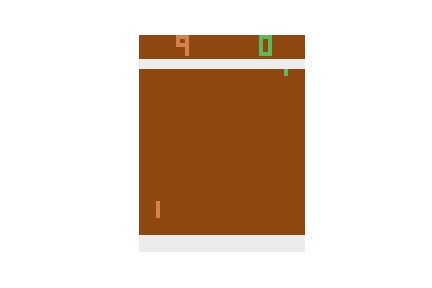
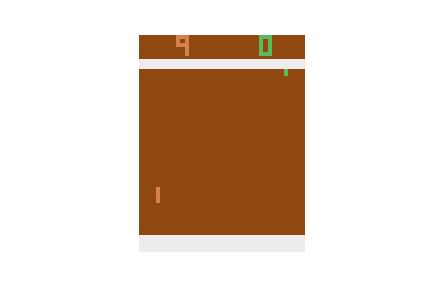
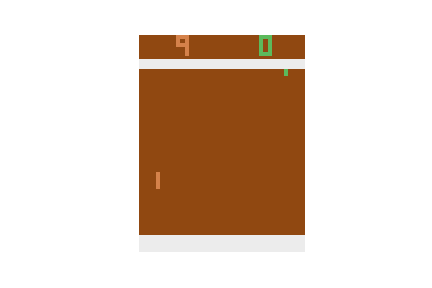
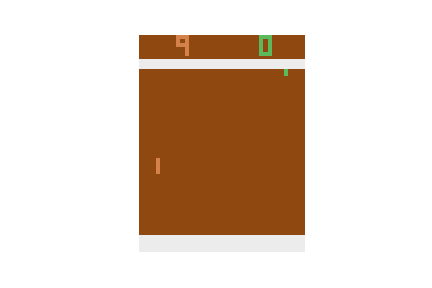
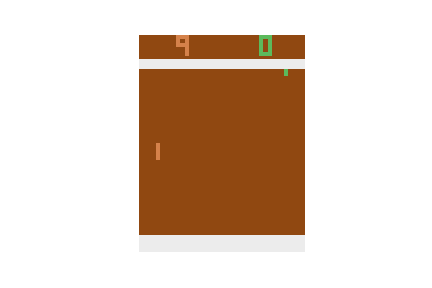
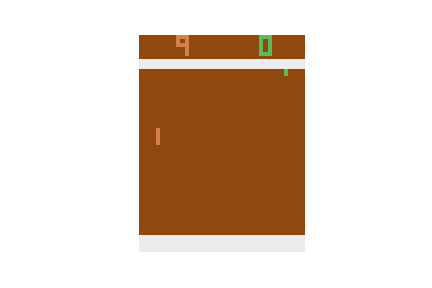
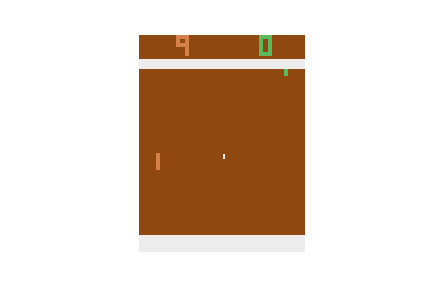
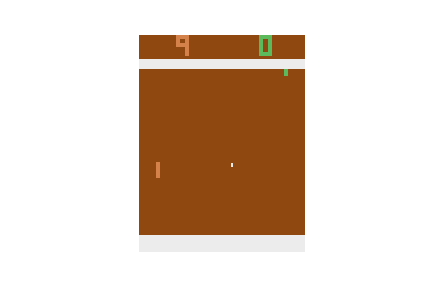
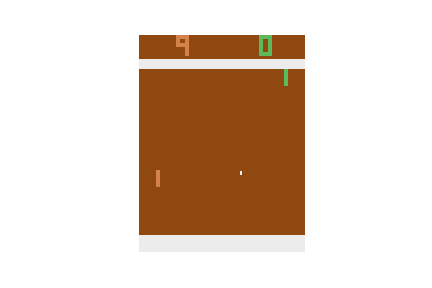
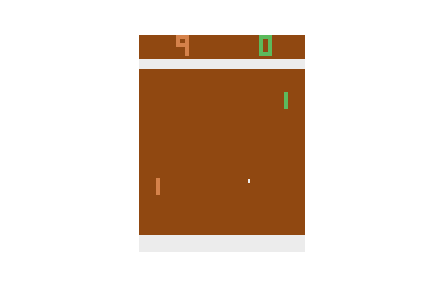
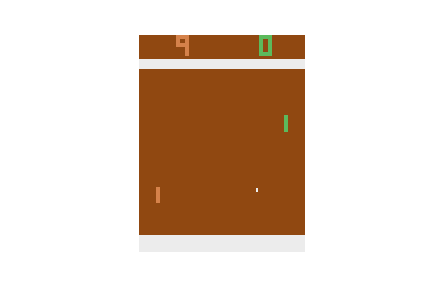
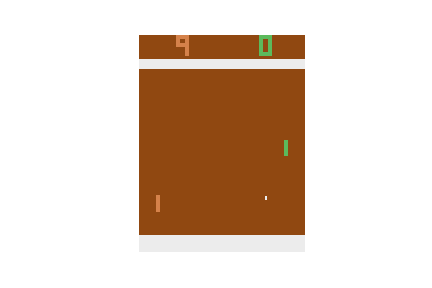
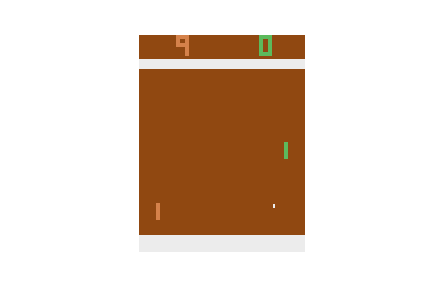
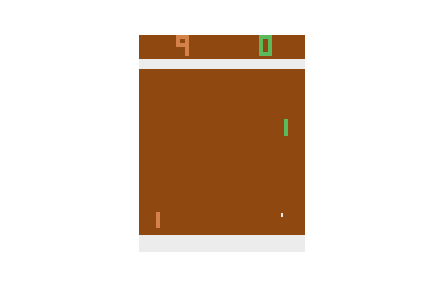
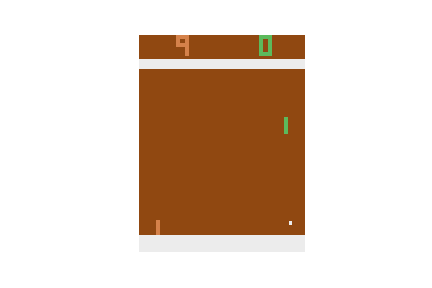
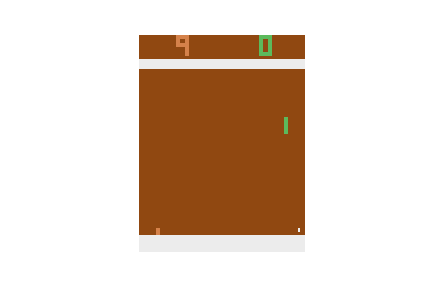
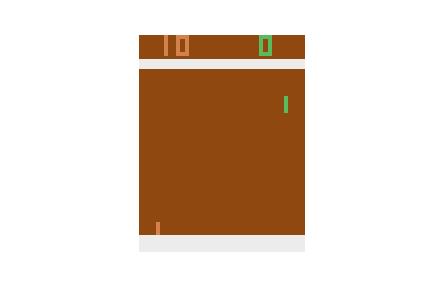
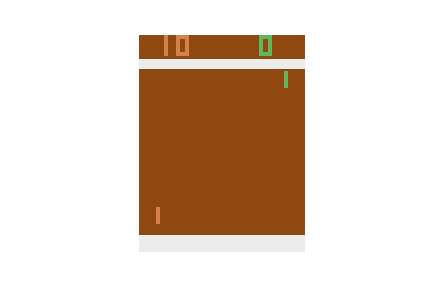
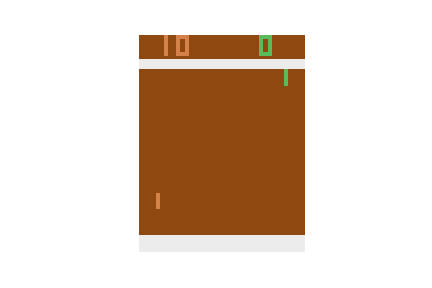
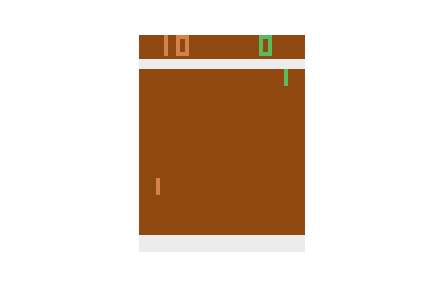
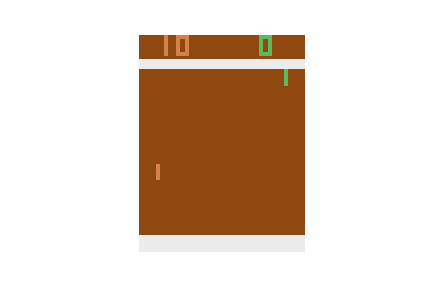
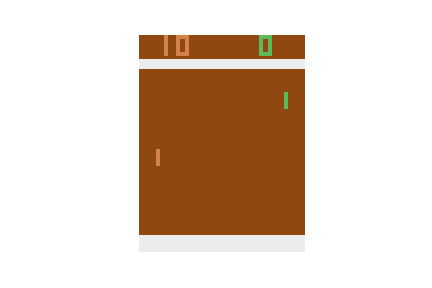
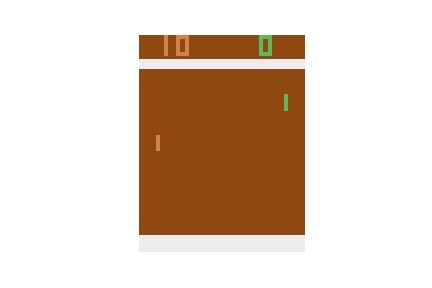
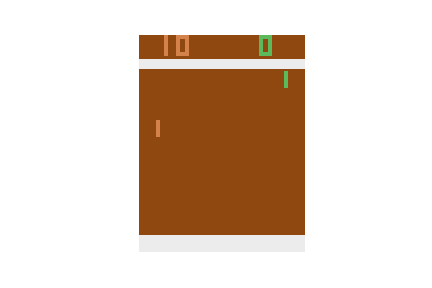
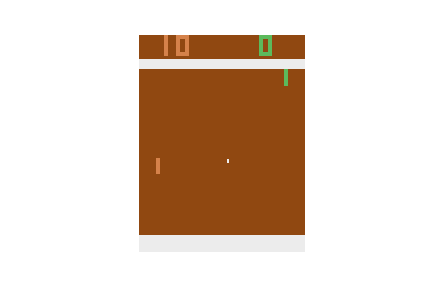
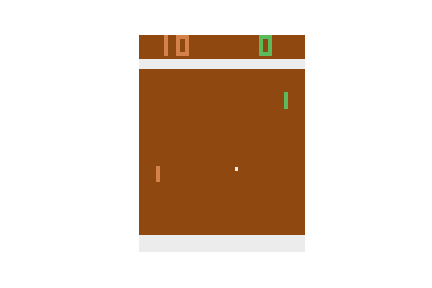
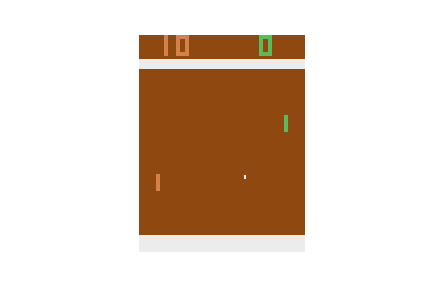
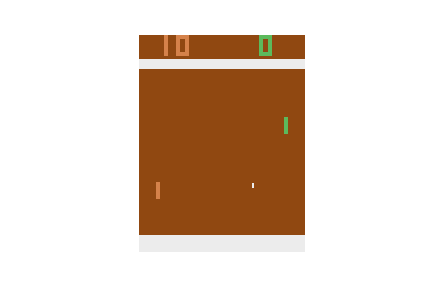
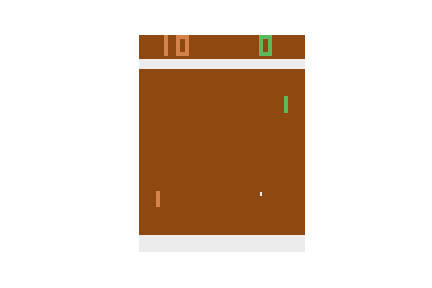
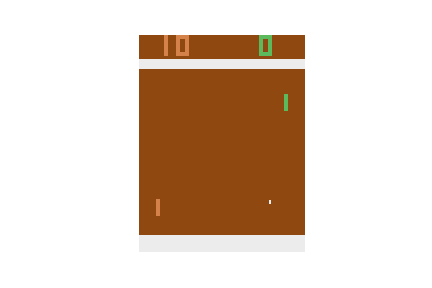
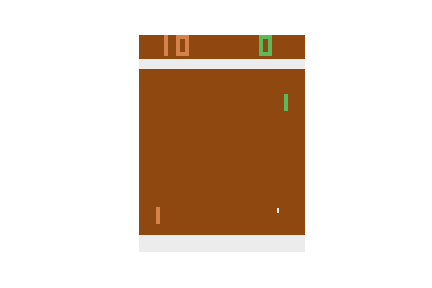
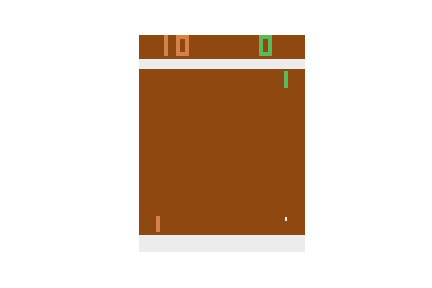

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
import numpy as np

# policy: the NN that maps states into actions
# old_probs: a list of arrays; each array represents the probabilities at step t for all of the parallel environments
# states: a list of 4D tensors representing the screen pixels at each time step
# actions: a list of arrays; each array represents the actions taken at step t for all parallel environments
# rewards: a list of arrays; each array represents the rewards from step t for all parallel environments
# epsilon: the amount above the initial sample reward that we will clip the output to prevent the
#          surrogate from deviating significantly from the real optimum policy function
# Returns gradient estimate
#
# Note: in this code we are only using actions LEFT & RIGHT. Probabilities are calculated for the
#       RIGHT action.  Therefore the probability of LEFT is the complement of probability for RIGHT.

def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    # compute the discounted future rewards
    discount = discount**np.arange(len(rewards)) # creates a 1D array
    rewards = np.asarray(rewards) * discount[:, np.newaxis] # axis 0 is time step

    # sum the future rewards so that each row contains the cumulative value of all future rewards
    # from that time step forward
    future_rewards = rewards[::-1].cumsum(axis=0)[::-1]
    #print("future_rewards =\n", future_rewards)

    # normalize the rewards across the parallel environments
    mean = np.mean(future_rewards, axis=1)
    std = np.std(future_rewards, axis=1) + 1.0e-10
    #print("mean =\n", mean)
    rewards_norm = (future_rewards - mean[:, np.newaxis]) / std[:, np.newaxis]
    #print("rewards_norm =\n", rewards_norm)

    # convert everything to tensors
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    rewards_norm = torch.tensor(rewards_norm, dtype=torch.float, device=device)
    
    # convert states to policy (or probability) - generates a 2D tensor of probs [time steps, envs]
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    # get the deviation of the new surrogate from the previous one 
    raw_ratio = new_probs / old_probs
    
    # clip the reward function
    clipped_ratio = torch.clamp(raw_ratio, 0.0, 1.0+epsilon)
    clipped_rewards = clipped_ratio * rewards_norm

    # include a regularization term, beta, which prevents policy from becoming exactly 0 or 1;
    # this helps with exploration
    entropy = -new_probs*torch.log(old_probs+1.e-10) \
        - (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10)

    return torch.mean(clipped_rewards + beta*entropy) # include the clipped results here!


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
from parallelEnv import parallelEnv
import numpy as np
!pip install progressbar
import progressbar as pb

envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# keep track of progress
mean_rewards = []

# these must be initialized outside the epoch loop and not returned to these values once we begin
discount_rate = .99
epsilon = 0.1 # controls clipping; will decay as training progresses
beta = .01
SGD_epoch = 4 # num times we reuse the same trajectory; value of 1 = REINFORCE algo

tmax = 320
episodes = 900

# running through 800 episodes will take 30-45 minutes
# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()
bar_counter = 0

for e in range(episodes):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)

    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):

        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
        #                                  epsilon=epsilon, beta=beta)

        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L

    # the clipping parameter reduces as time goes on
    epsilon *= 0.999

    # the regulation term also reduces
    # this reduces exploration in later runs
    beta *= 0.995

    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))

    # display some progress every 20 iterations
    if (e+1) % 20 == 0:
        print("Episode: {0:d}, score: {1:f}".format(e+1, np.mean(total_rewards)))
        print(total_rewards)

    # update progress widget bar
    bar_counter += 1
    timer.update(bar_counter)

timer.finish()

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


Episode: 20, score: -13.875000
[-13. -15. -12. -12. -15. -13. -16. -15.]


Episode: 40, score: -15.250000
[-17. -16. -13. -16. -16. -16. -16. -12.]


Episode: 60, score: -14.250000
[-15. -14. -14. -16. -14. -14. -15. -12.]


Episode: 80, score: -14.000000
[-16. -16. -11. -16. -13. -15. -15. -10.]


Episode: 100, score: -14.125000
[-14. -12. -16. -10. -15. -14. -16. -16.]


Episode: 120, score: -14.750000
[-17. -15. -14. -16. -15. -15. -11. -15.]


Episode: 140, score: -13.375000
[-14. -16.  -7. -16. -13. -15. -15. -11.]


Episode: 160, score: -11.625000
[ -8. -12.  -7. -11. -15. -11. -13. -16.]


Episode: 180, score: -12.375000
[-15.  -9. -13.  -9. -16. -11. -10. -16.]


Episode: 200, score: -12.500000
[-14. -13. -12. -11. -13. -12. -12. -13.]


Episode: 220, score: -11.750000
[-12. -16. -12. -11. -13. -13.  -6. -11.]


Episode: 240, score: -9.750000
[-12. -10.  -8.  -7. -10. -12. -11.  -8.]


Episode: 260, score: -9.750000
[-12.  -9. -12.  -7.  -7.  -9. -13.  -9.]


Episode: 280, score: -7.125000
[ -6.  -4.  -9.  -9.  -8. -11.  -3.  -7.]


Episode: 300, score: -5.125000
[ -2.  -8.  -9.  -1.  -4.  -3.  -4. -10.]


Episode: 320, score: -2.250000
[-1. -3. -3. -1. -4. -1. -2. -3.]


Episode: 340, score: -1.000000
[-1.  0. -1. -1. -1. -2. -1. -1.]


Episode: 360, score: -1.375000
[-1. -1. -2. -1. -1. -1. -1. -3.]


Episode: 380, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 400, score: -1.250000
[-1. -1. -2. -1. -1. -1. -2. -1.]


Episode: 420, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 440, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 460, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 480, score: -1.500000
[-1. -1. -1. -1. -1. -5. -1. -1.]


Episode: 500, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 520, score: -1.750000
[-1. -5. -1. -3. -1. -1. -1. -1.]


Episode: 540, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 560, score: -1.000000
[-2.  0. -1. -1.  0. -1. -1. -2.]


Episode: 580, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 600, score: -0.125000
[-1.  0.  0. -1.  0.  0.  1.  0.]


Episode: 620, score: 0.000000
[-9.  1.  1.  1.  3.  1.  1.  1.]


Episode: 640, score: 0.750000
[ 0.  1.  1.  1.  1.  1.  0.  1.]


Episode: 660, score: 0.625000
[-2.  1. -1.  1.  3.  1.  1.  1.]


Episode: 680, score: 0.625000
[ 1.  1.  1.  1.  0.  1. -1.  1.]


Episode: 700, score: 1.875000
[ 0.  3.  1.  3.  3.  0.  5.  0.]


Episode: 720, score: 1.875000
[ 3. -1.  2.  3. -1.  5.  5. -1.]


Episode: 740, score: 3.000000
[ 3.  3.  3. -1.  3.  5.  5.  3.]


Episode: 760, score: 3.750000
[ 3.  1.  3.  5.  5.  5.  3.  5.]


Episode: 780, score: 4.375000
[ 3.  3.  5.  5.  5.  5.  4.  5.]


Episode: 800, score: 3.250000
[ 4.  2.  3.  2.  5.  3.  2.  5.]


Episode: 820, score: 4.500000
[ 3.  3.  5.  5.  5.  5.  5.  5.]


Episode: 840, score: 4.750000
[ 5.  5.  5.  3.  5.  5.  5.  5.]


Episode: 860, score: 4.250000
[ 5.  5.  3.  5.  5.  5.  1.  5.]


Episode: 880, score: 4.750000
[ 5.  3.  5.  5.  5.  5.  5.  5.]


Episode: 900, score: 4.125000
[ 5.  0.  5.  3.  5.  5.  5.  5.]


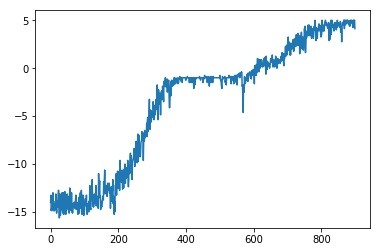

In [8]:
plt.plot(mean_rewards)

In [9]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



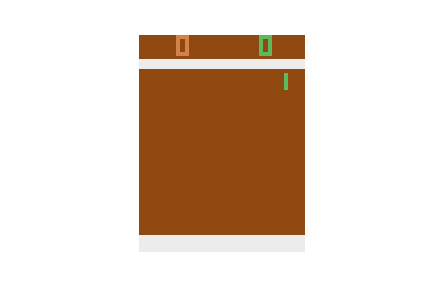
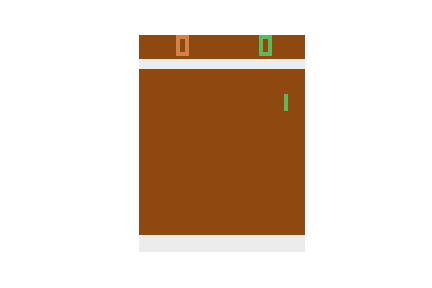
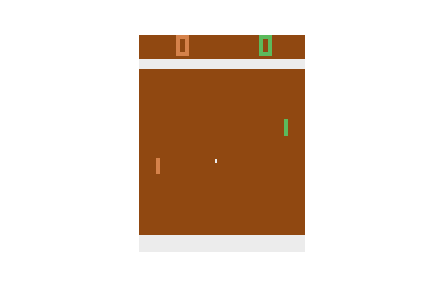
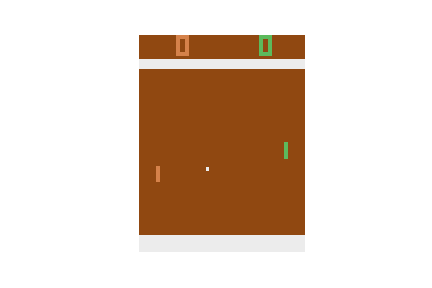
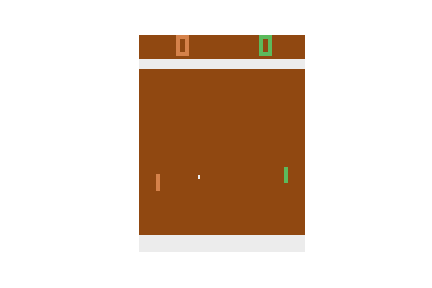
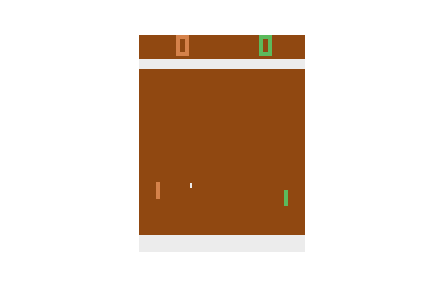
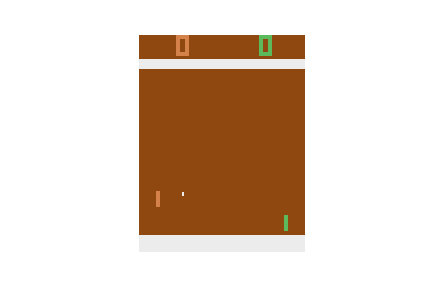
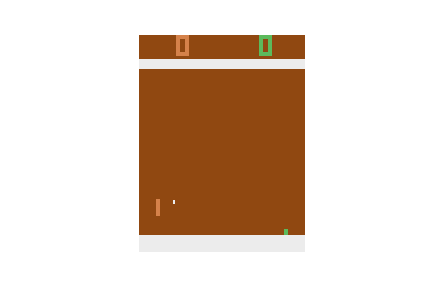
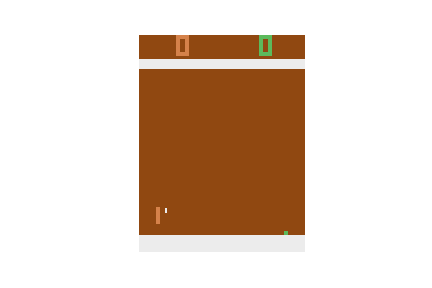
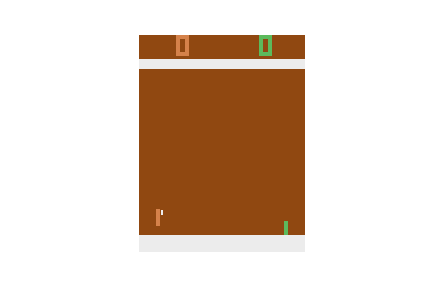
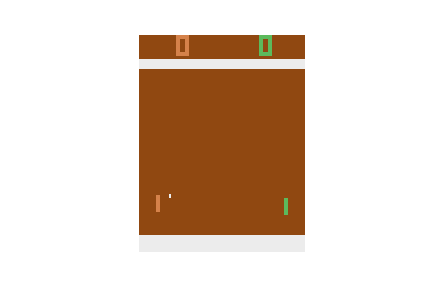
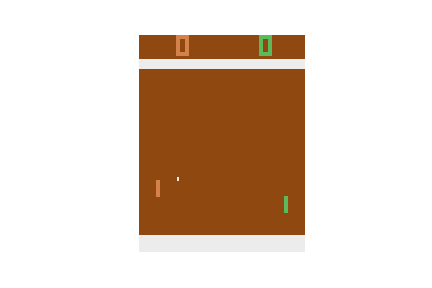
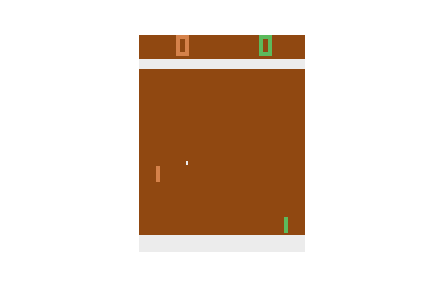
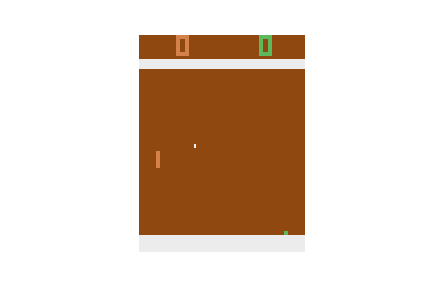
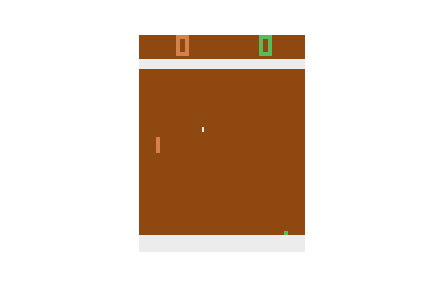
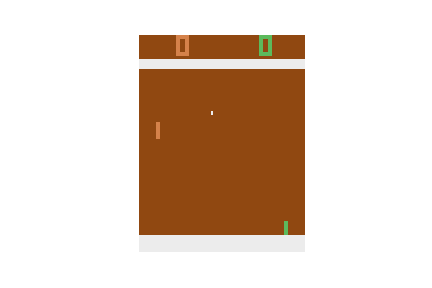
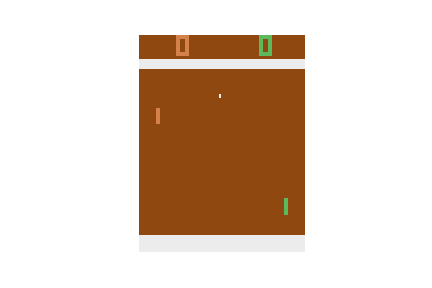
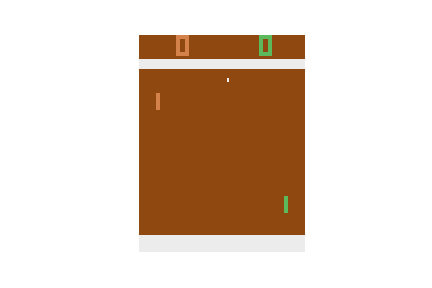
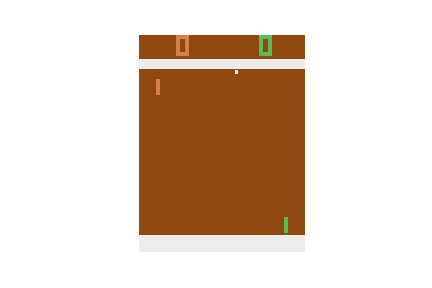
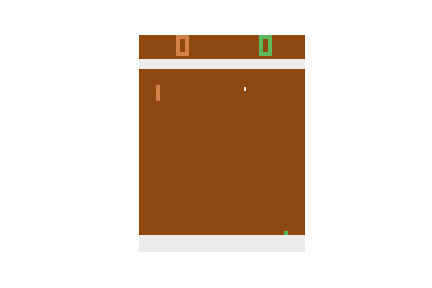
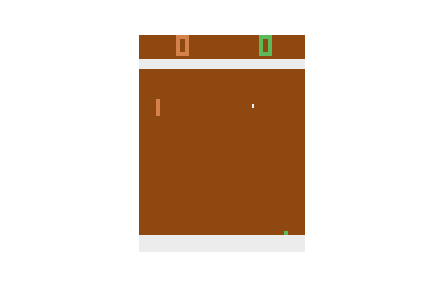
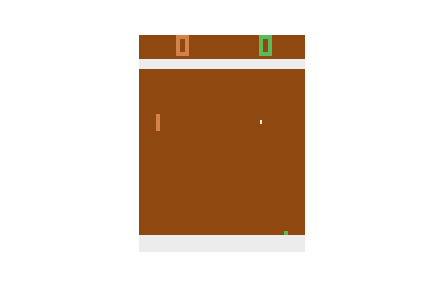
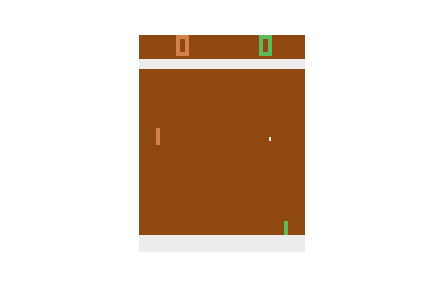
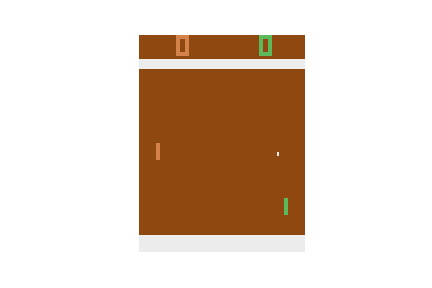
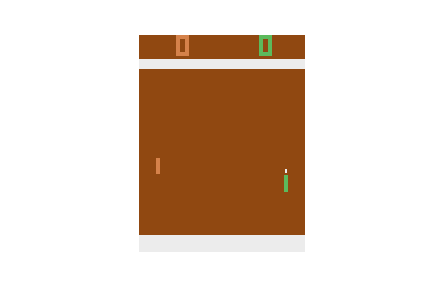
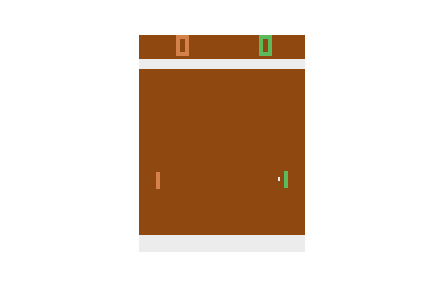
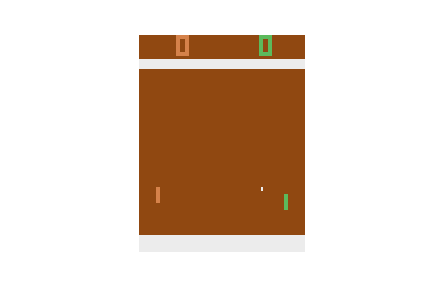
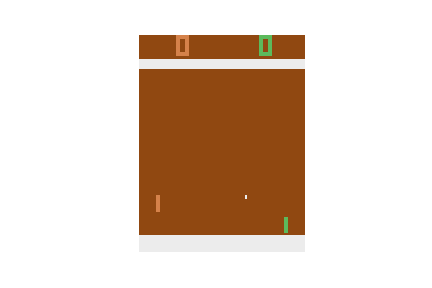
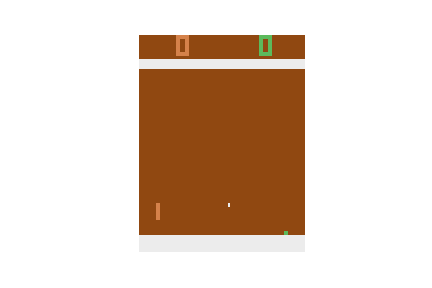
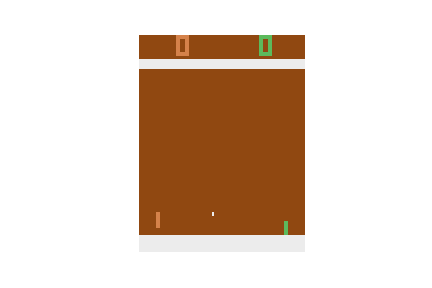
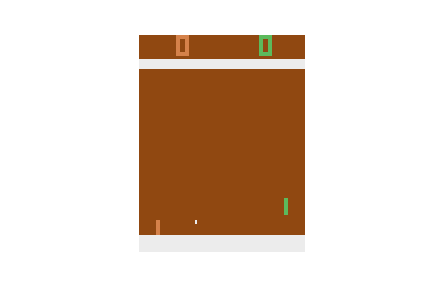
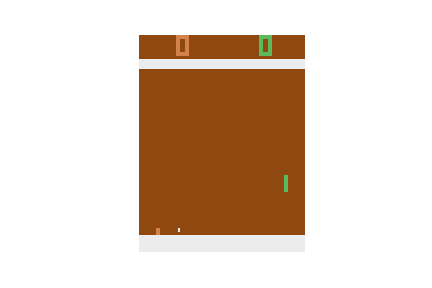
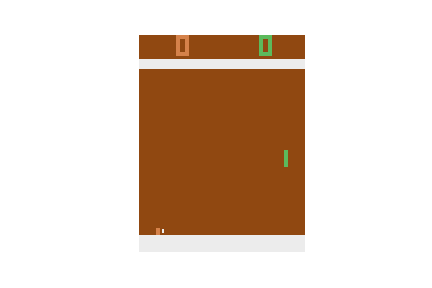
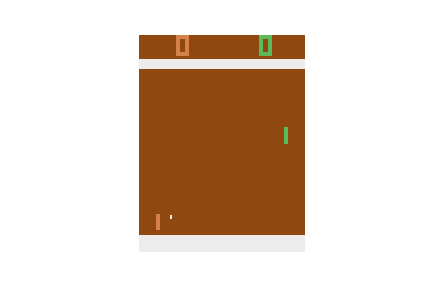
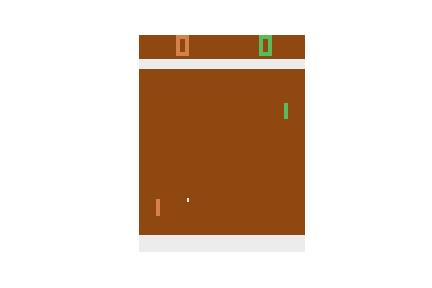
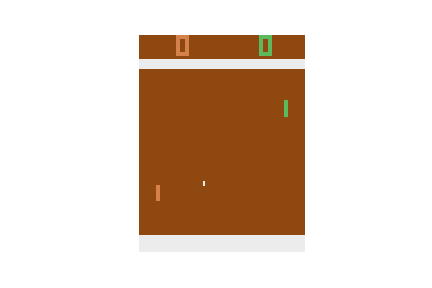
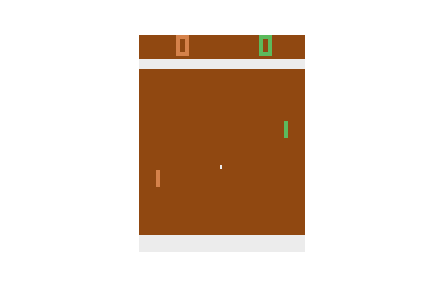
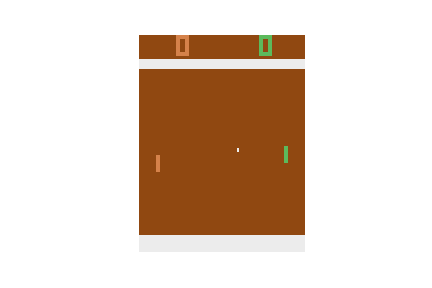
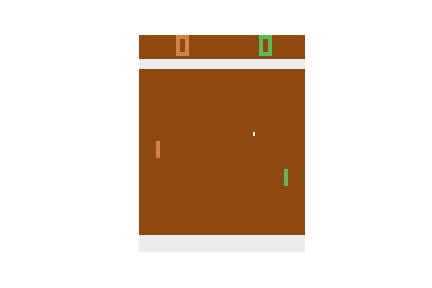
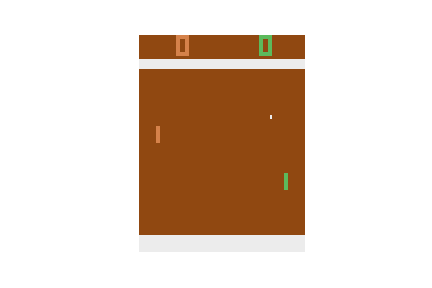
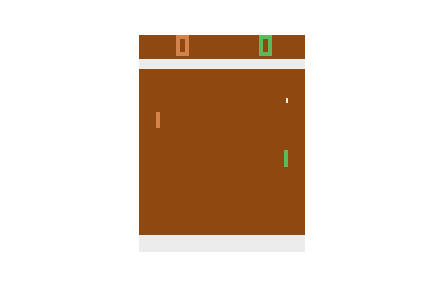
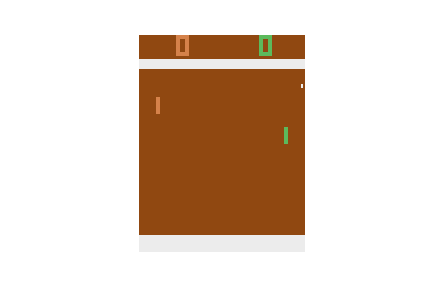
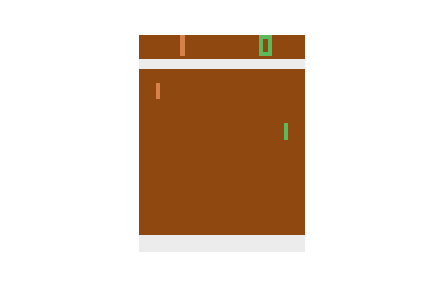
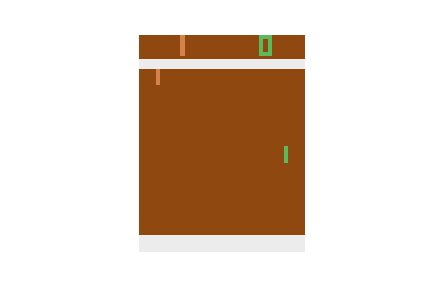
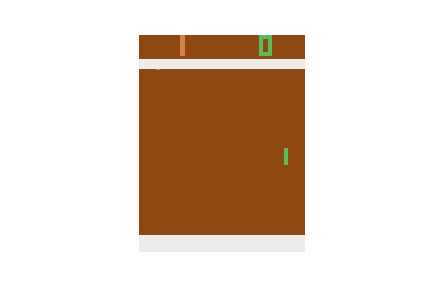
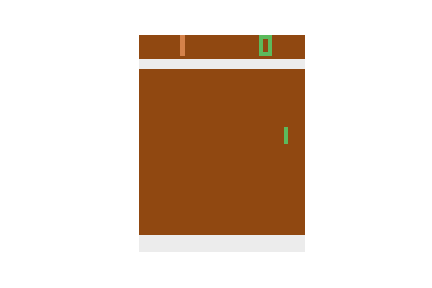
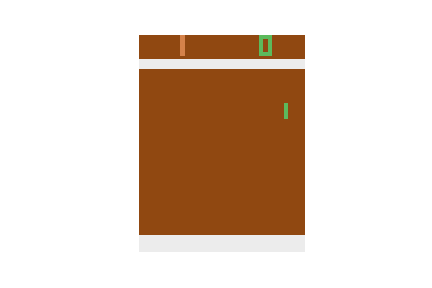
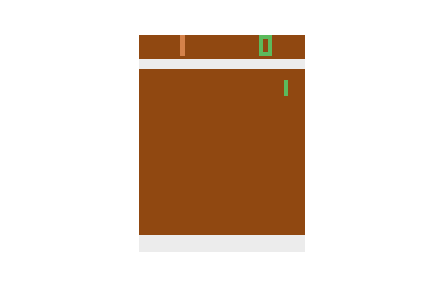
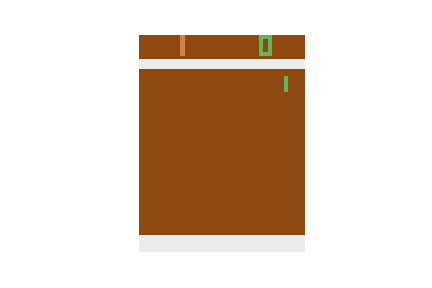
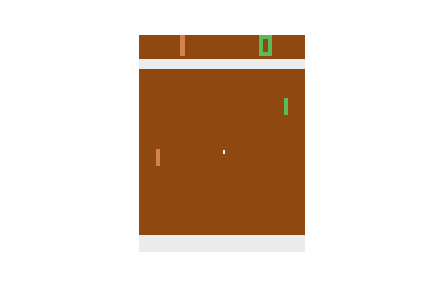
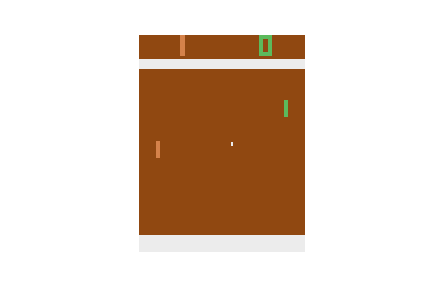
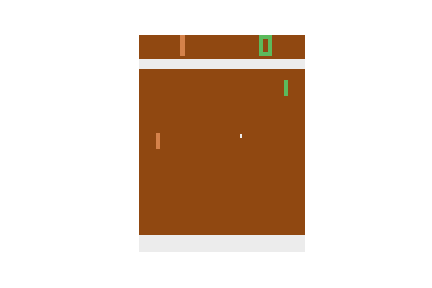
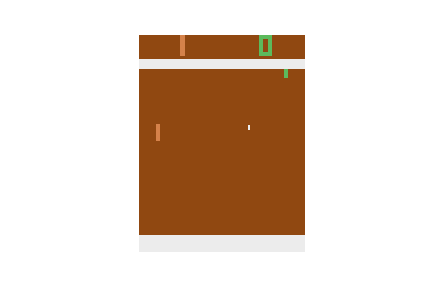
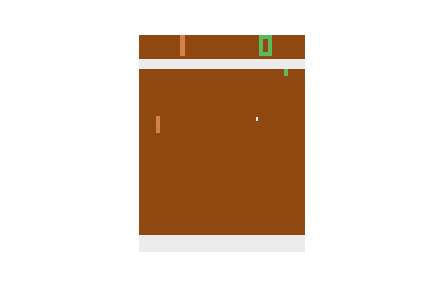
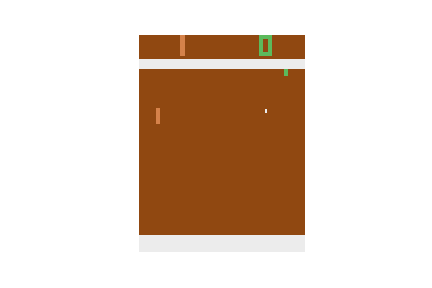
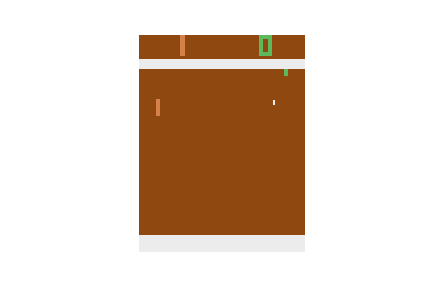
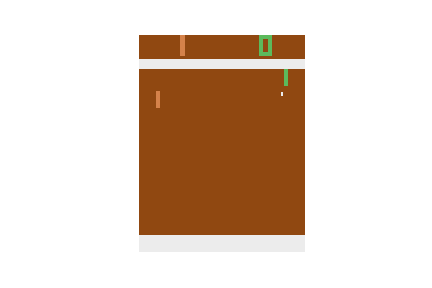
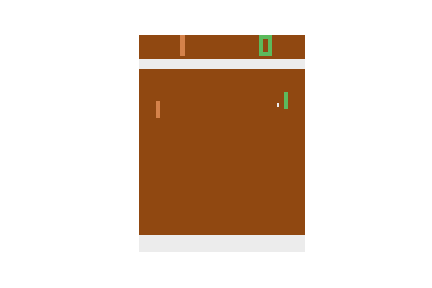
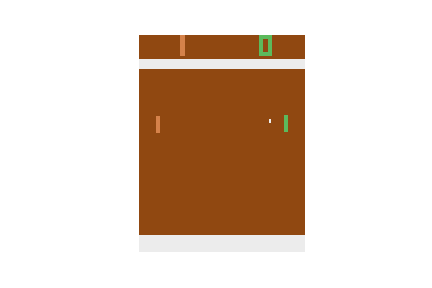
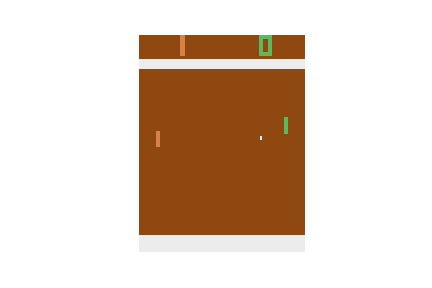
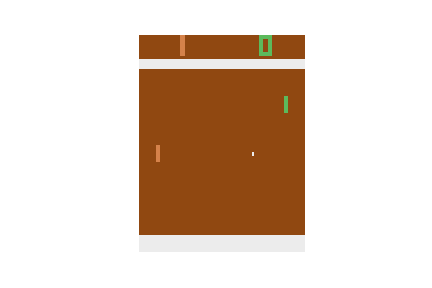
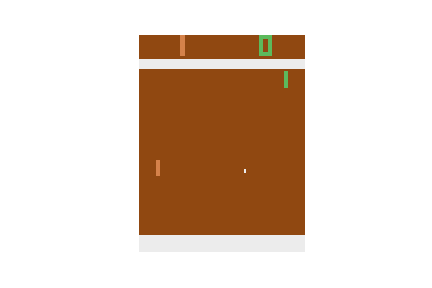
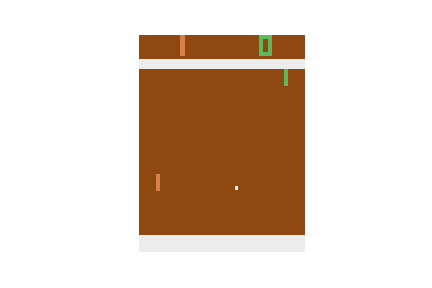
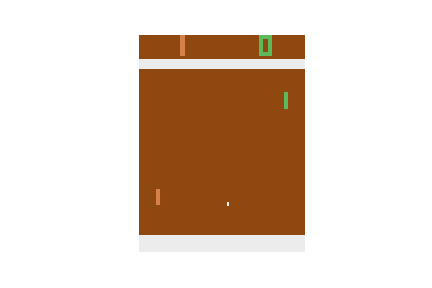
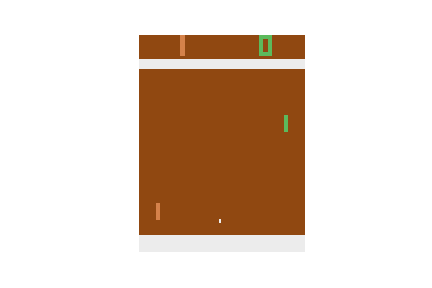
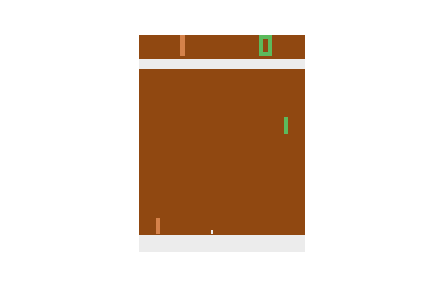
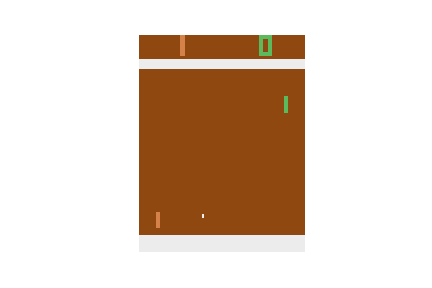
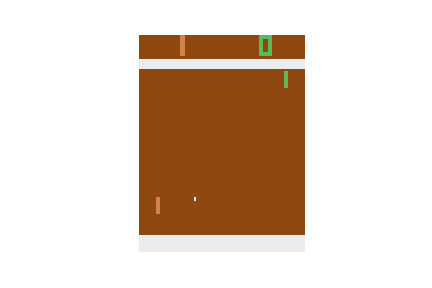
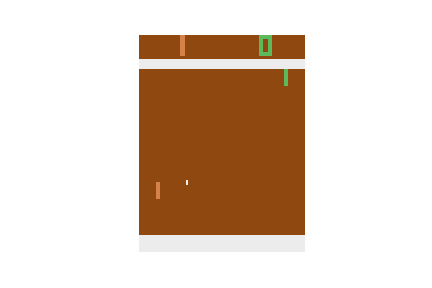
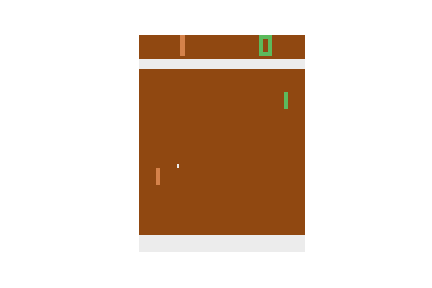
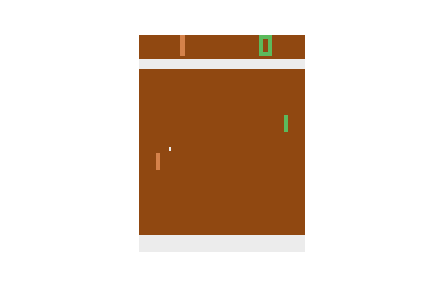
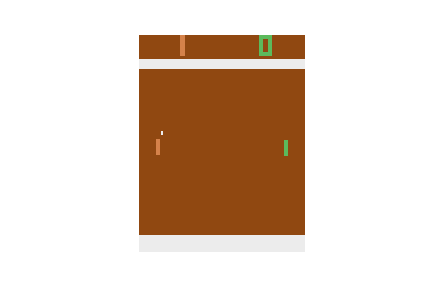
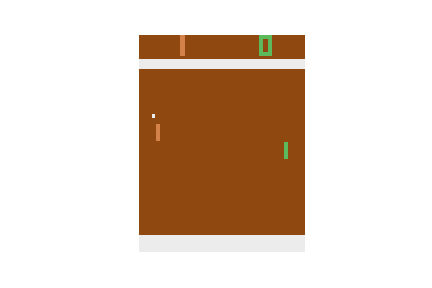
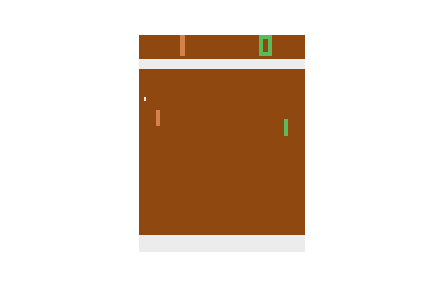
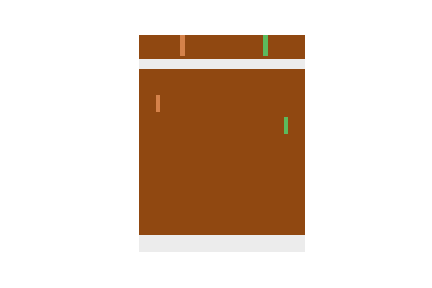
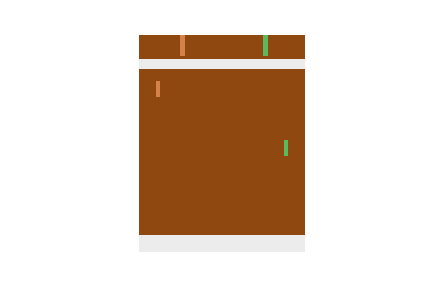
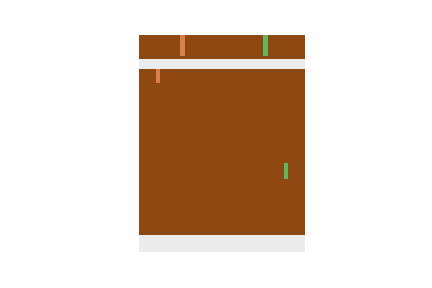
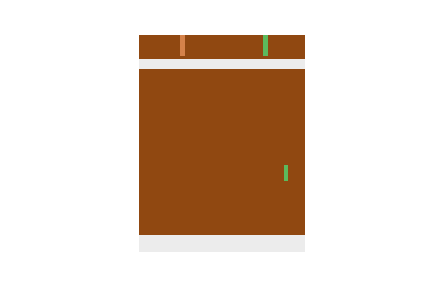
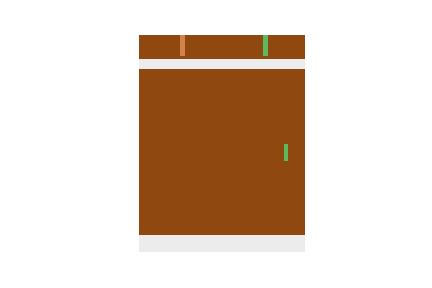
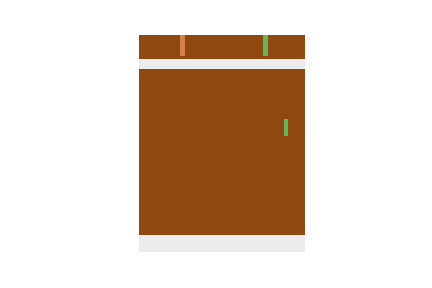
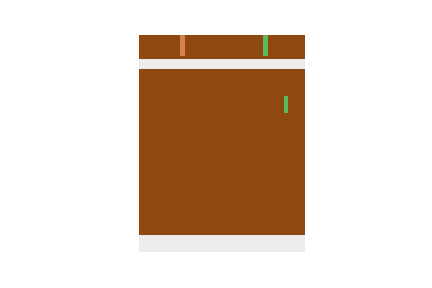
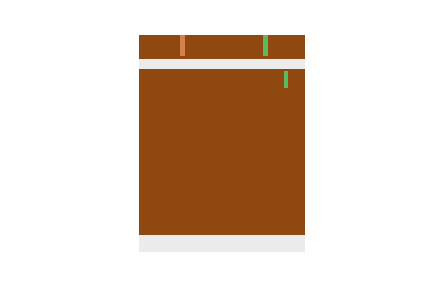
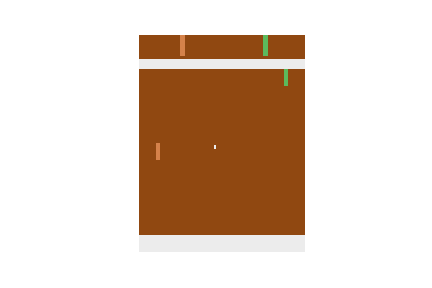
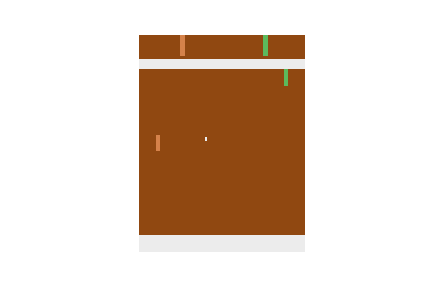
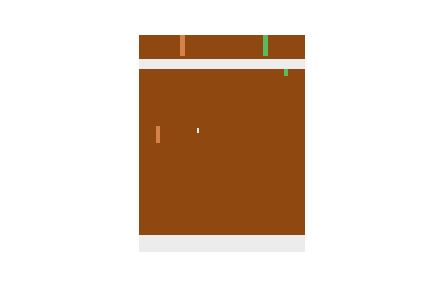
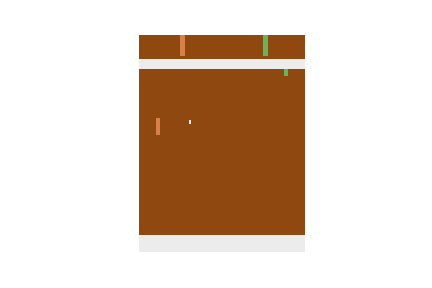
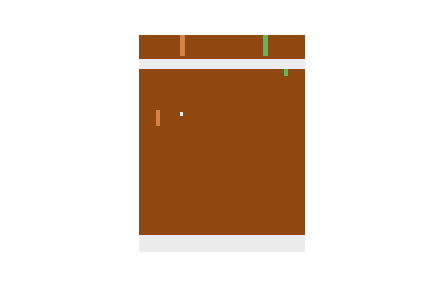
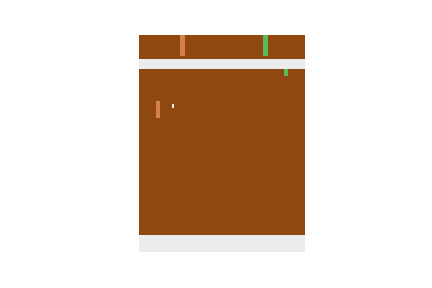
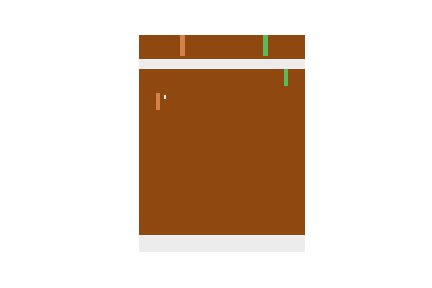
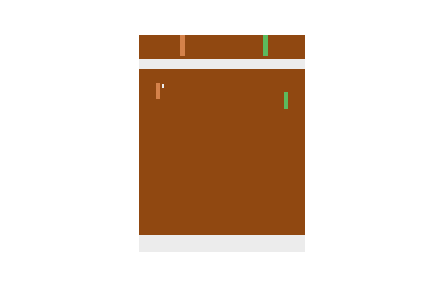
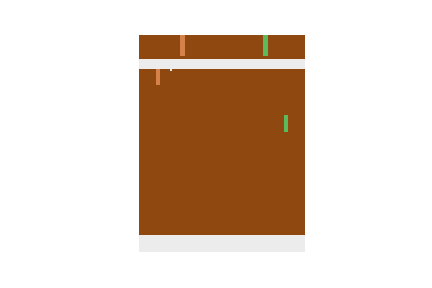
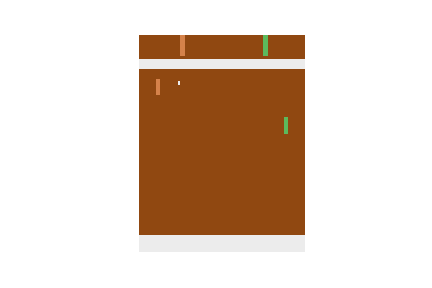
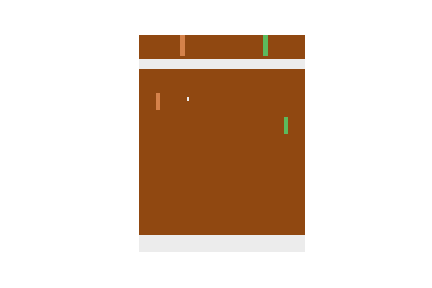
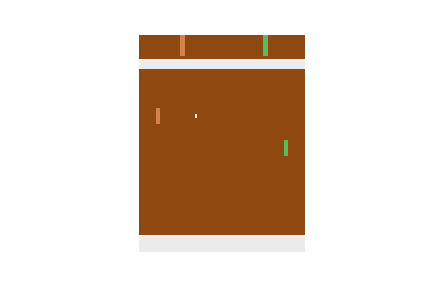
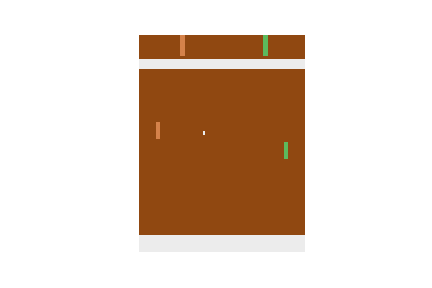
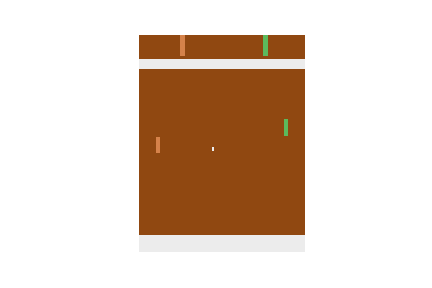
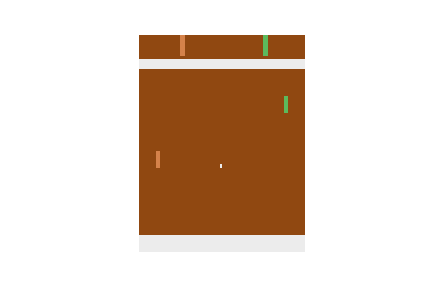
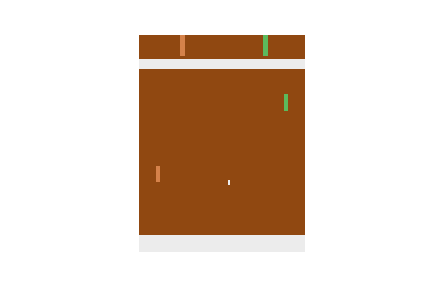
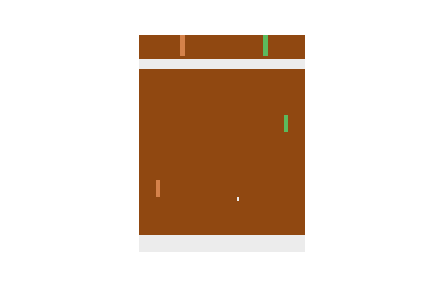
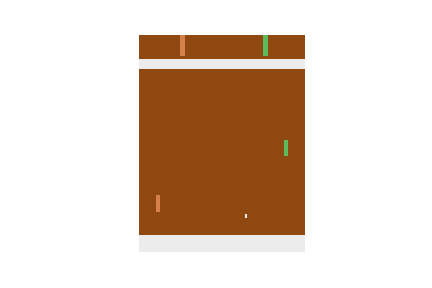
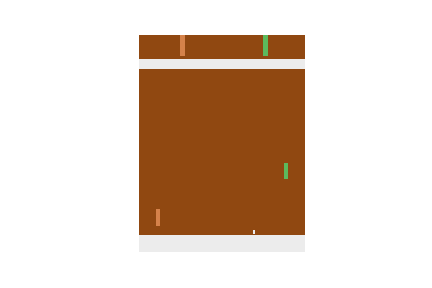
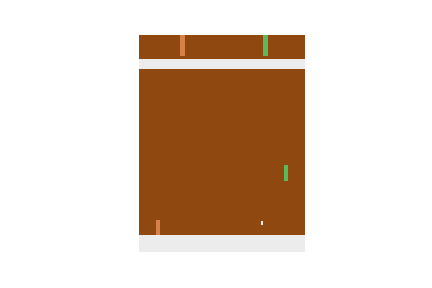
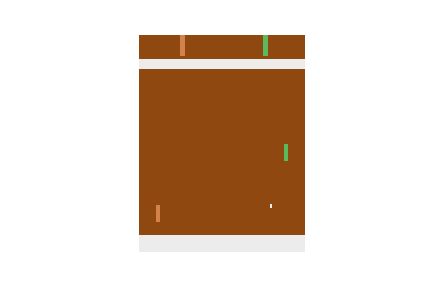
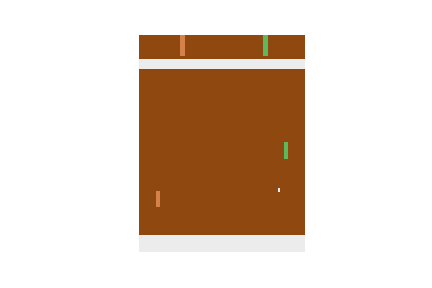
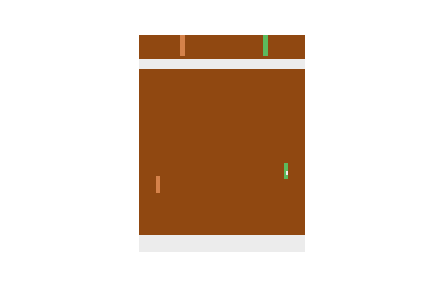
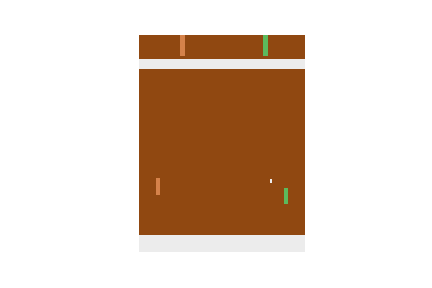
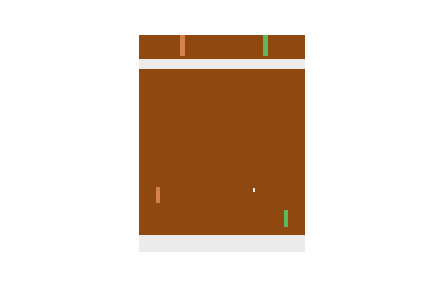
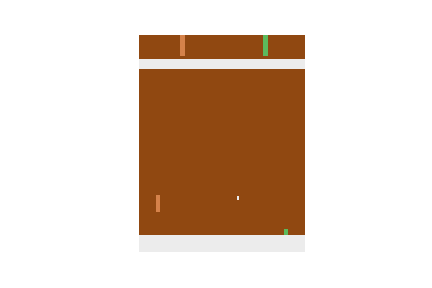
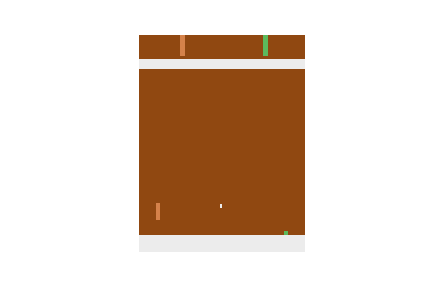
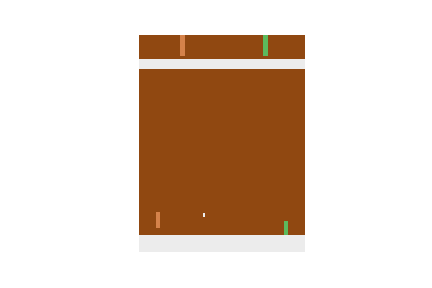
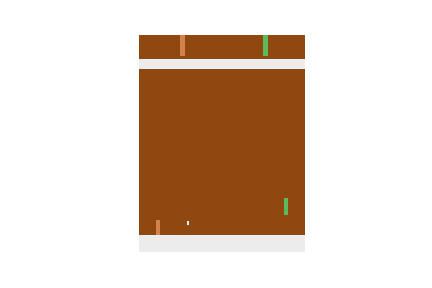
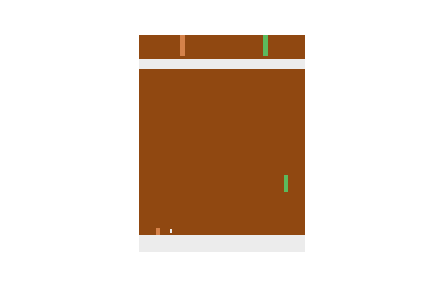
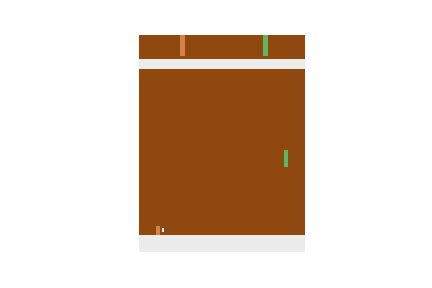
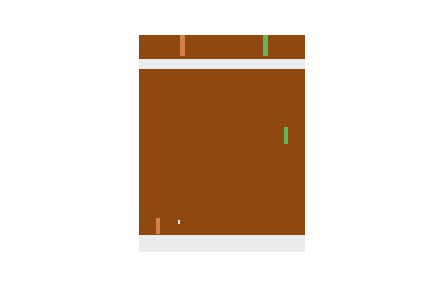
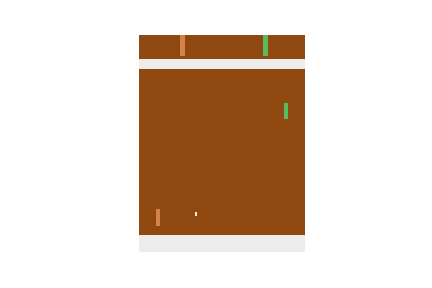
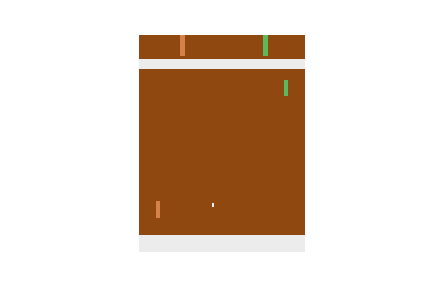
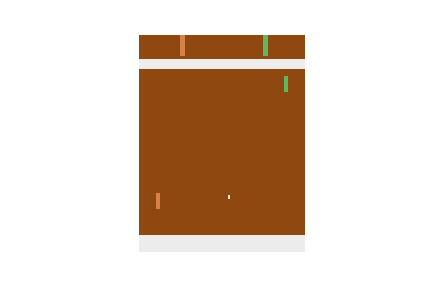
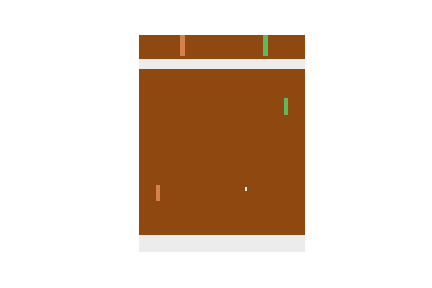
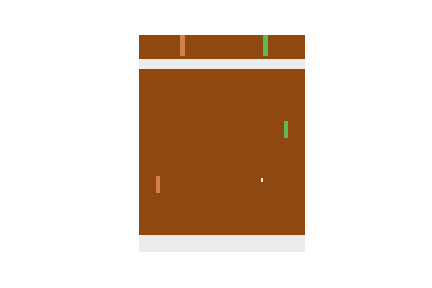
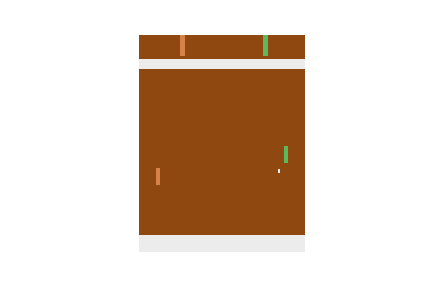
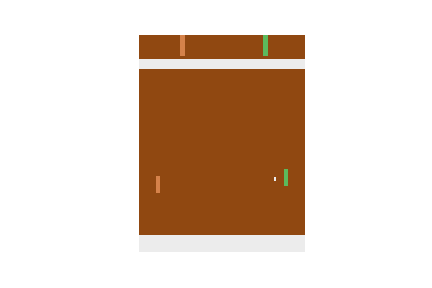
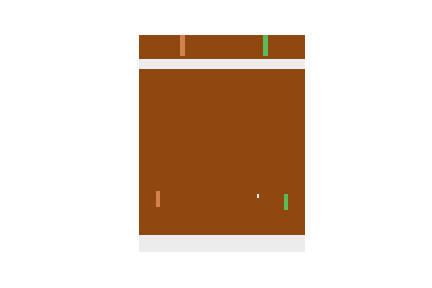
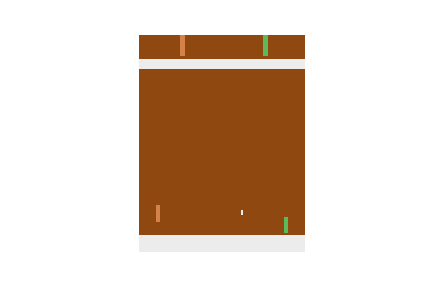
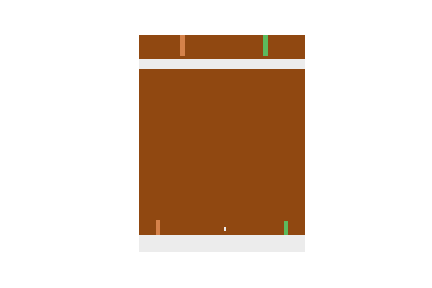
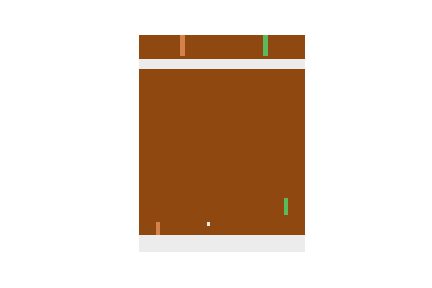
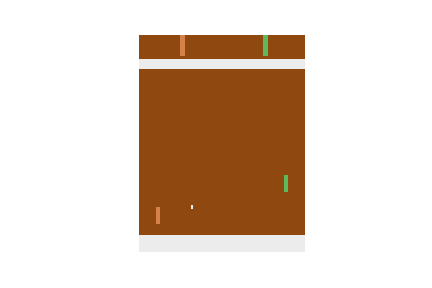
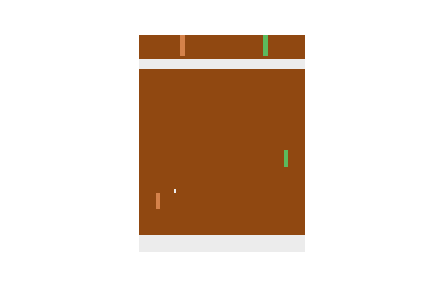
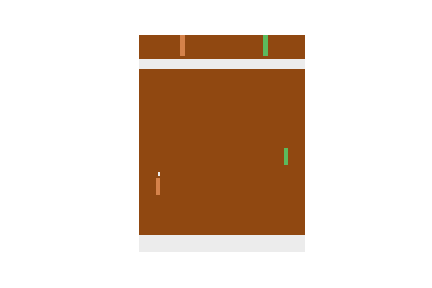
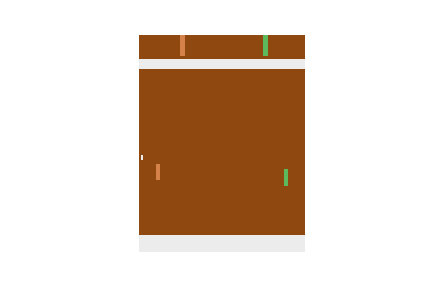
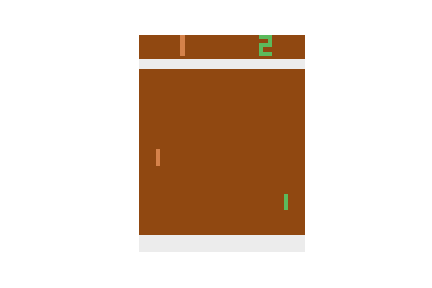
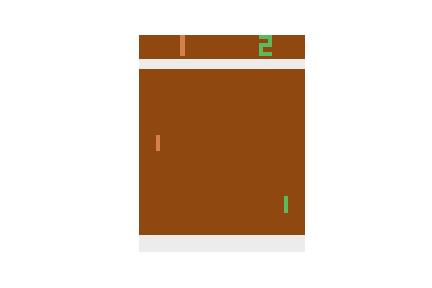
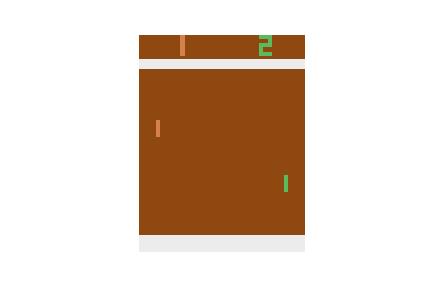
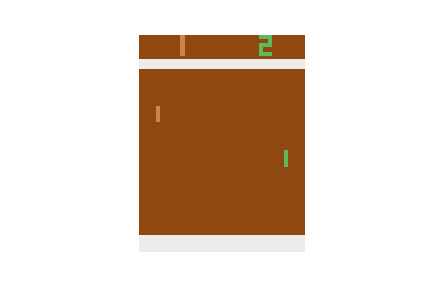
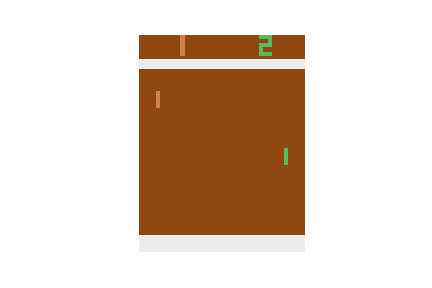
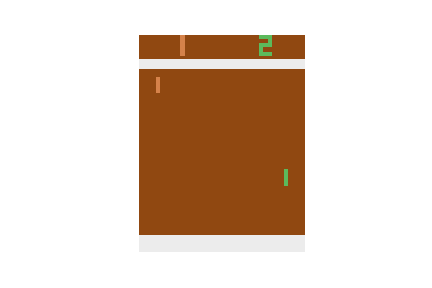
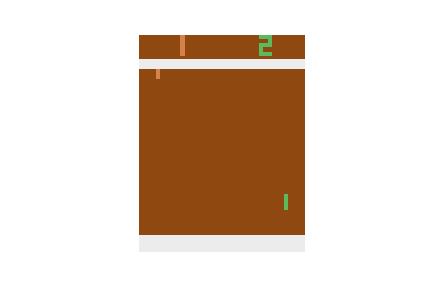
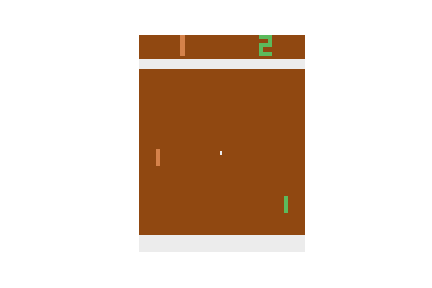
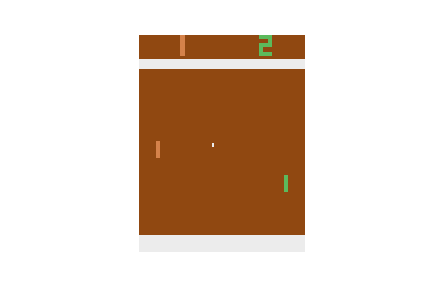
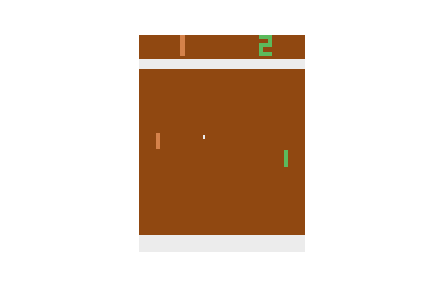
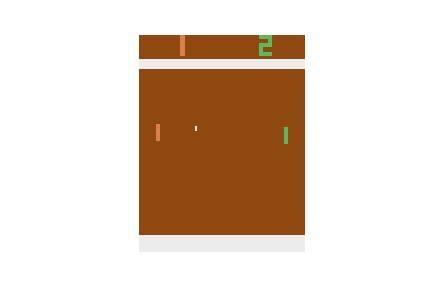
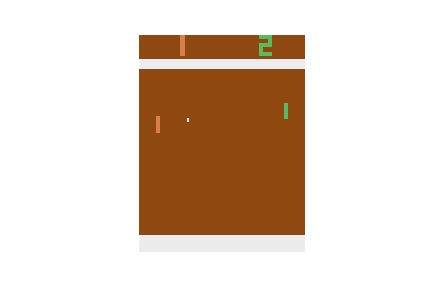
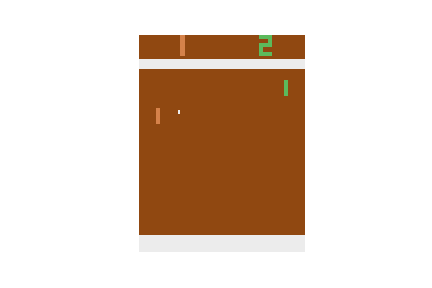
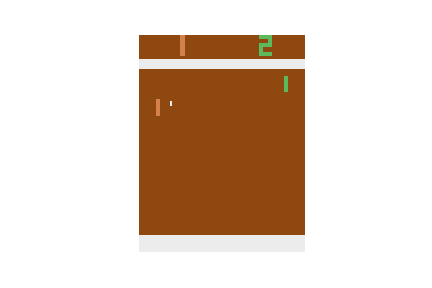
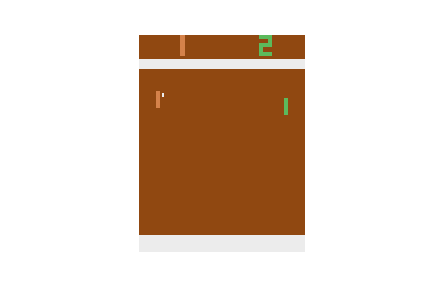
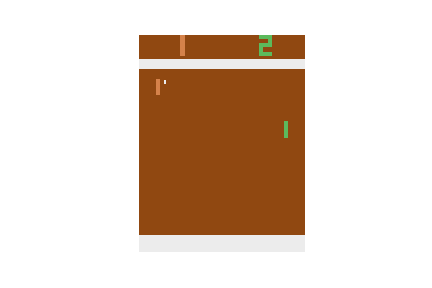
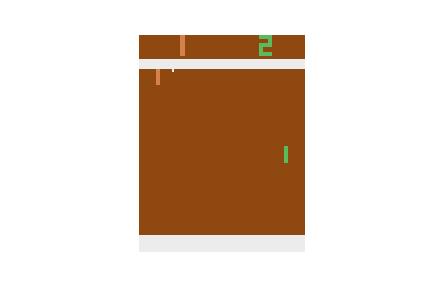
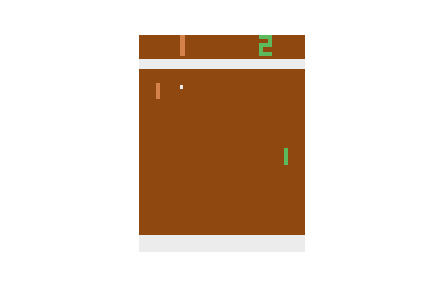
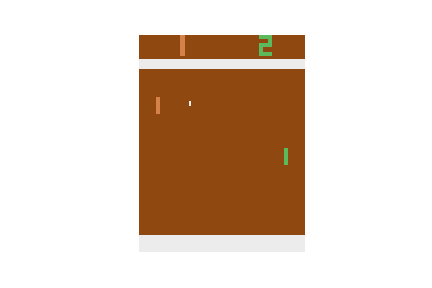
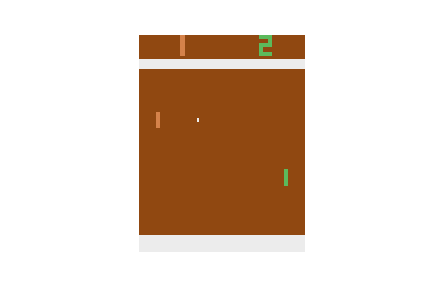
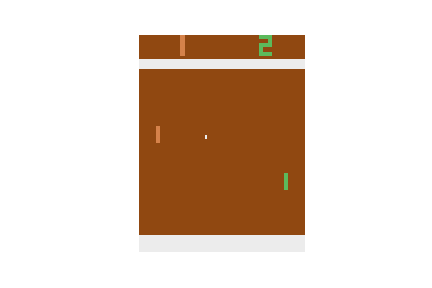
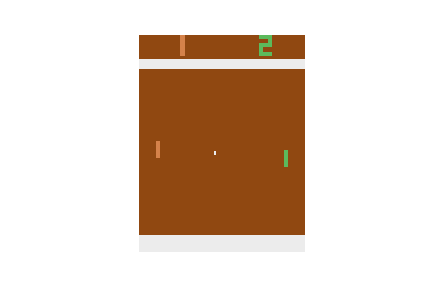
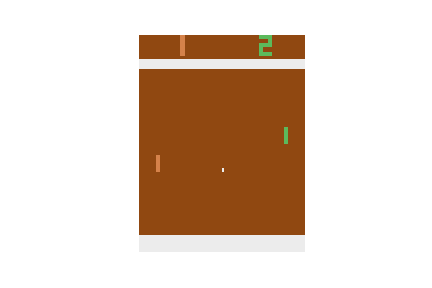
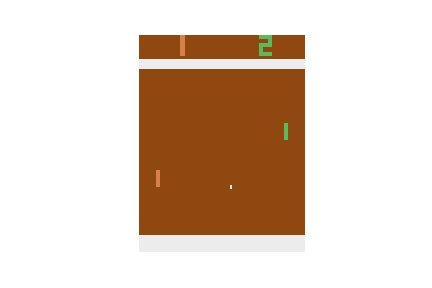
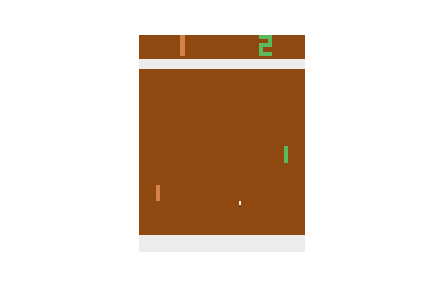
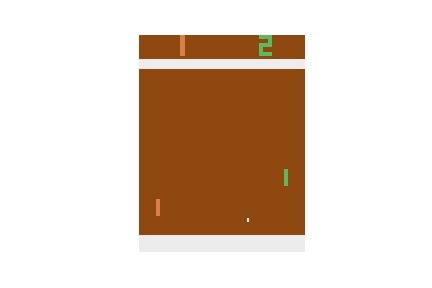
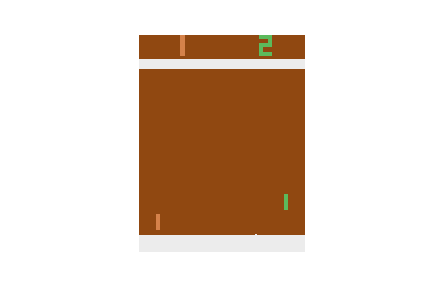
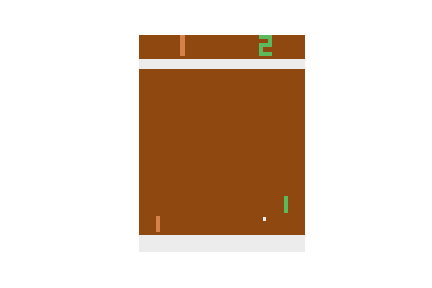
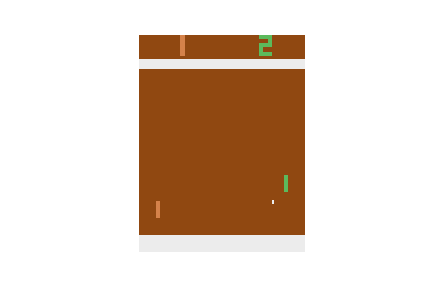
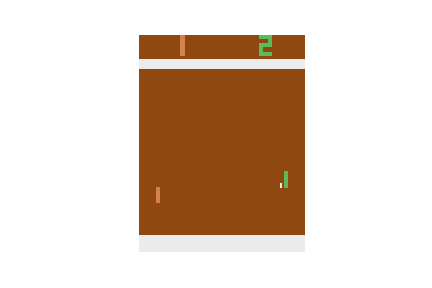
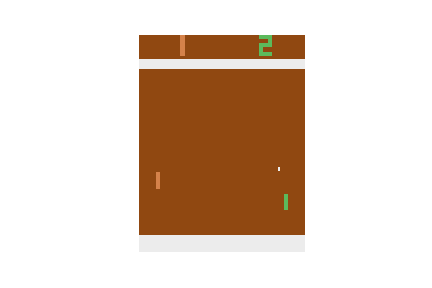
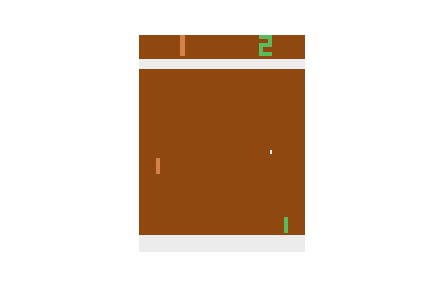
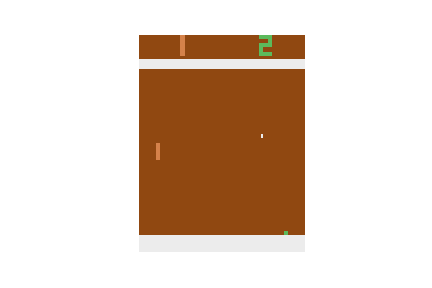
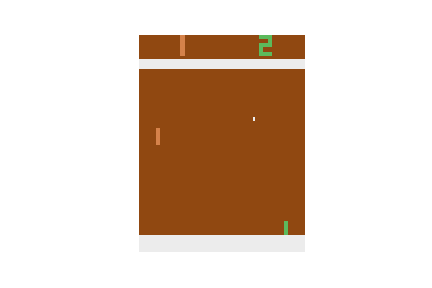
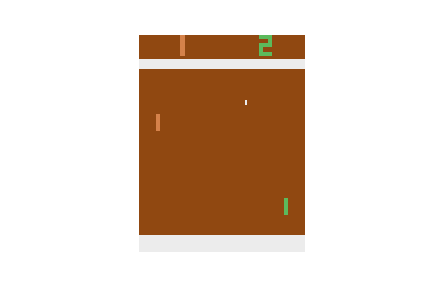
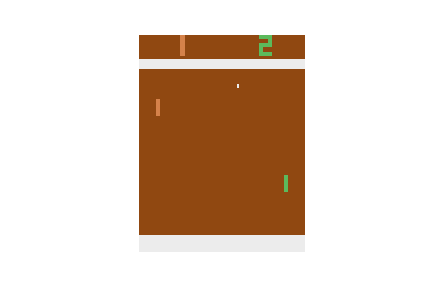
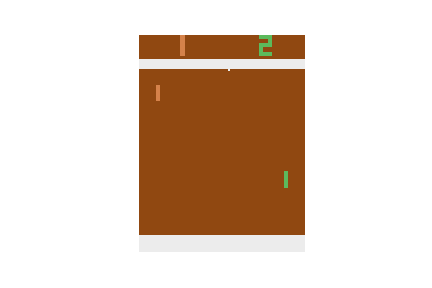
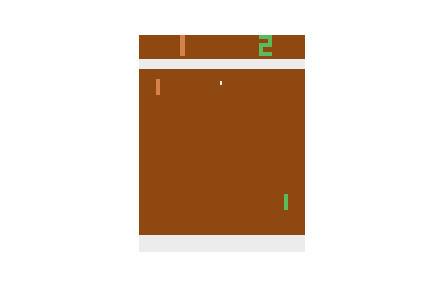
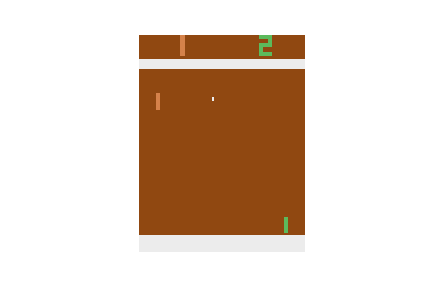
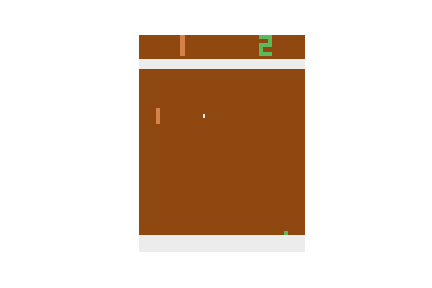
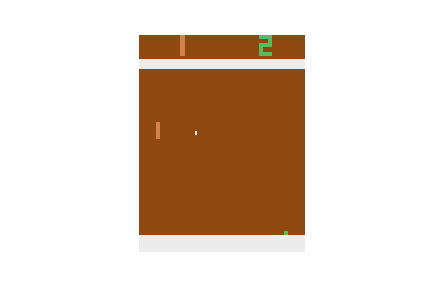
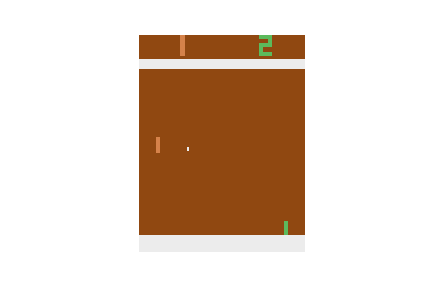
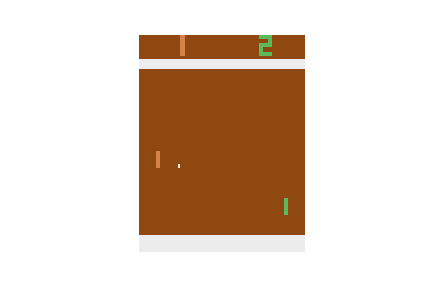
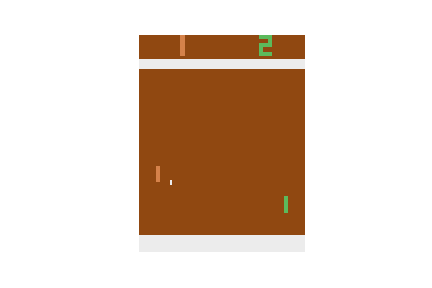
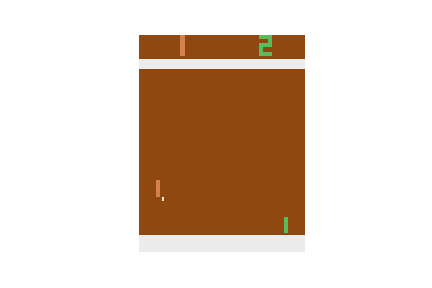
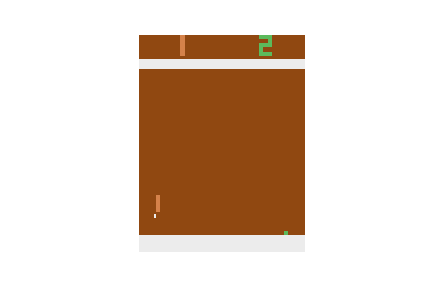
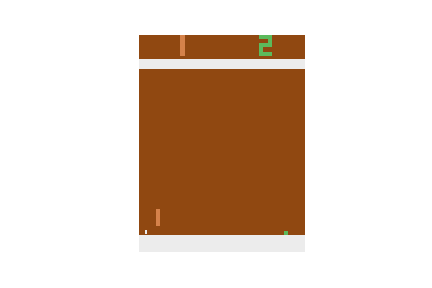
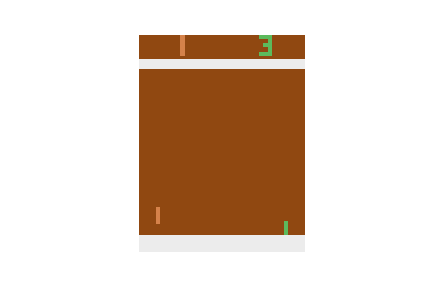
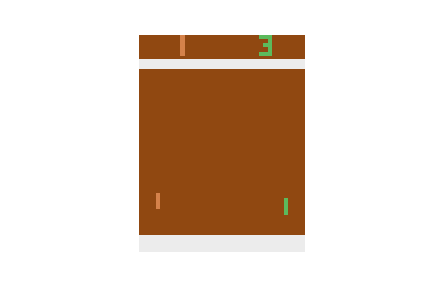
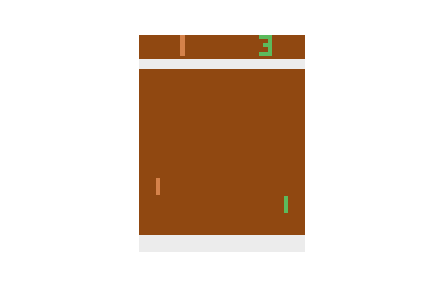
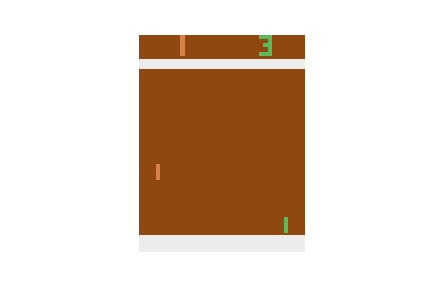
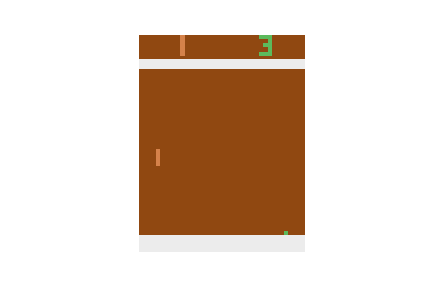
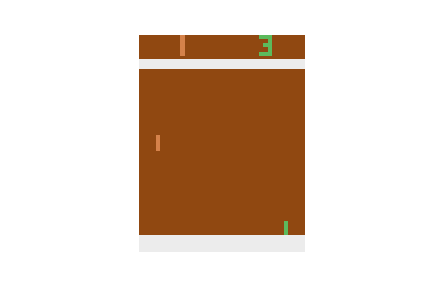
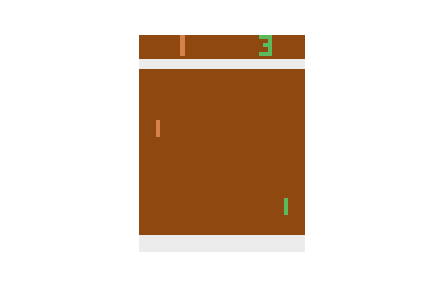
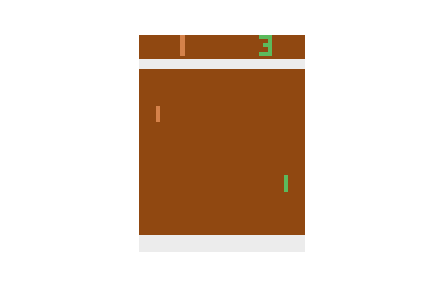
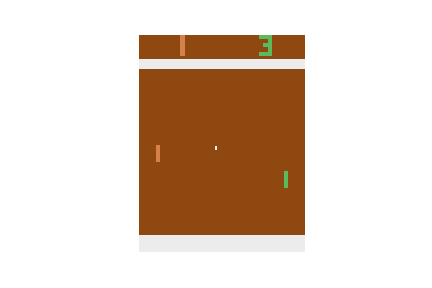
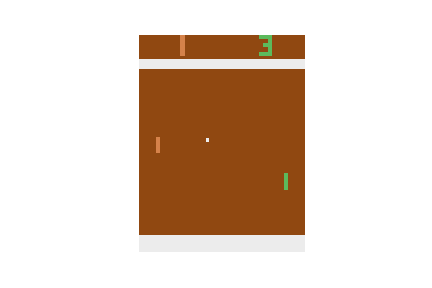
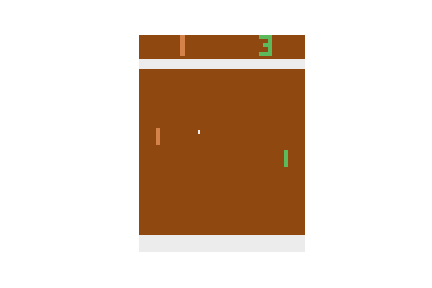
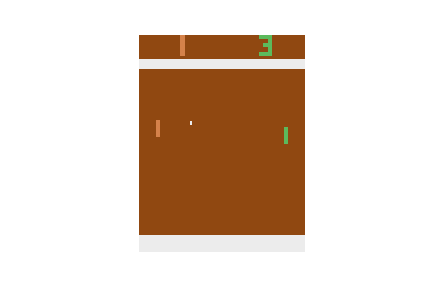
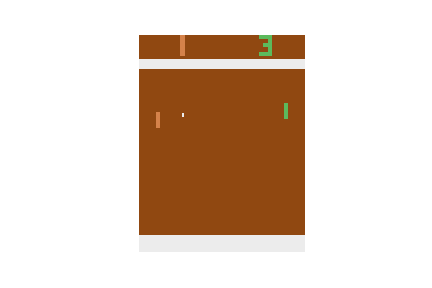
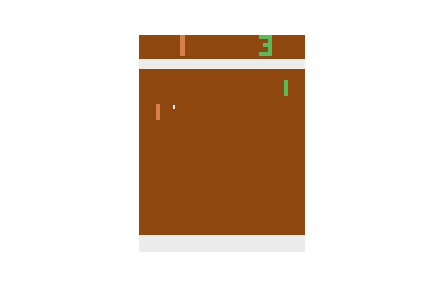
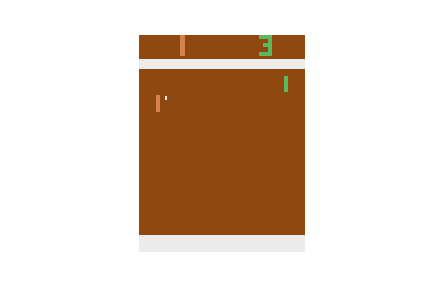
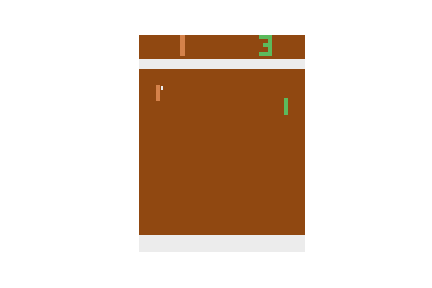
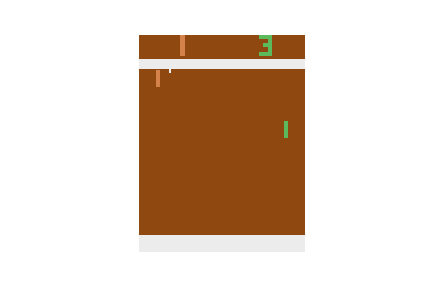
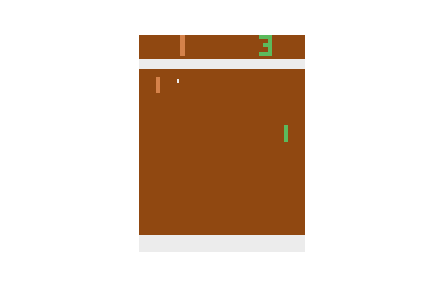
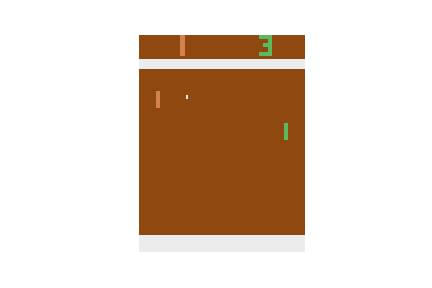
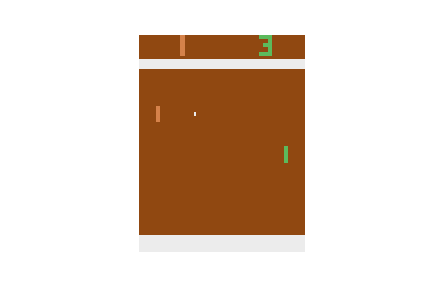
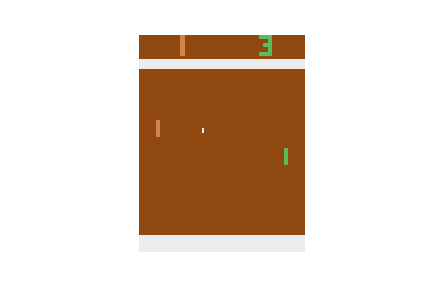
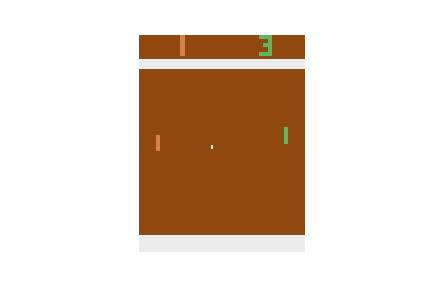
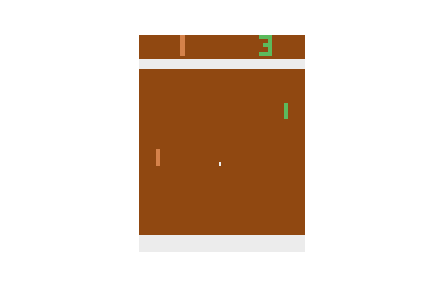
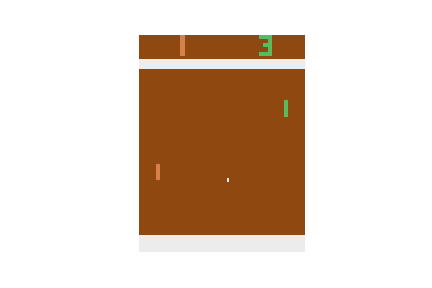
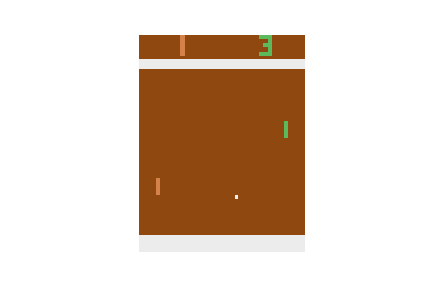
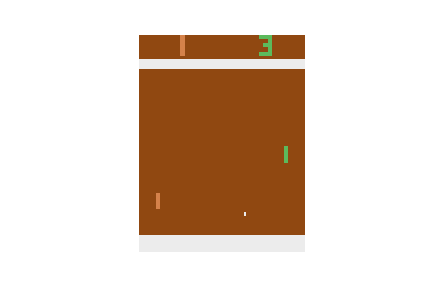
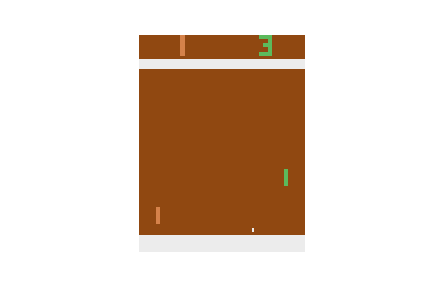
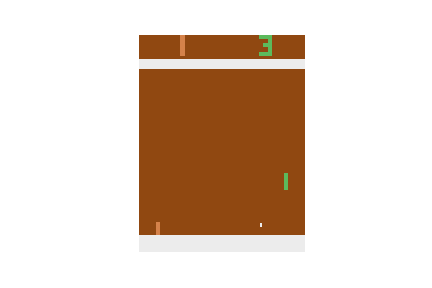
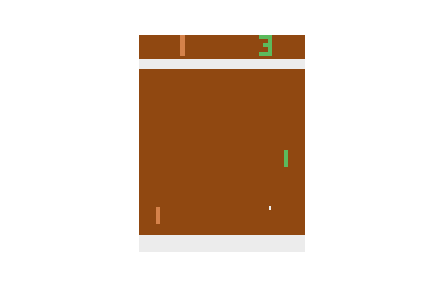
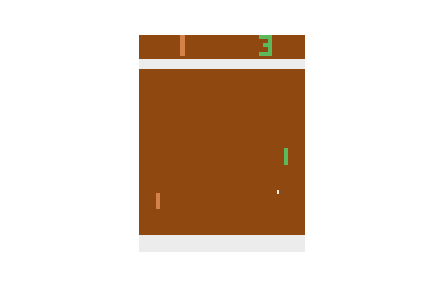
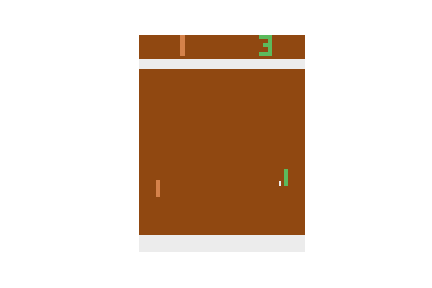
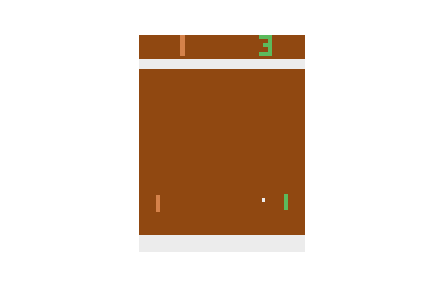
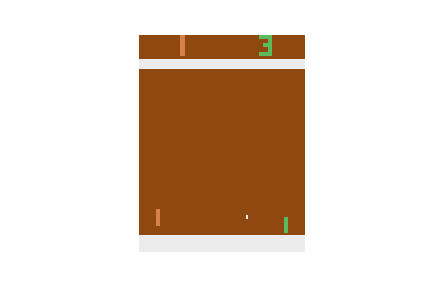
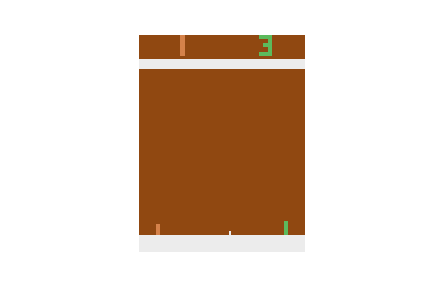
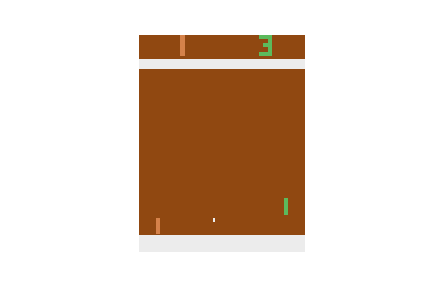
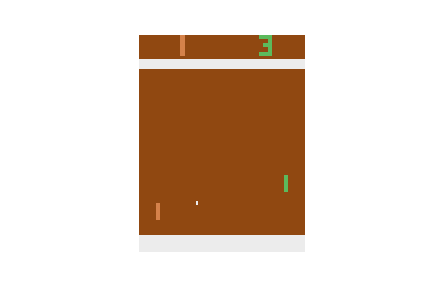
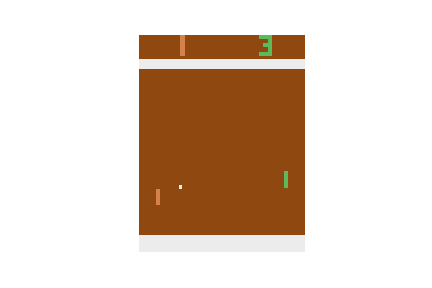
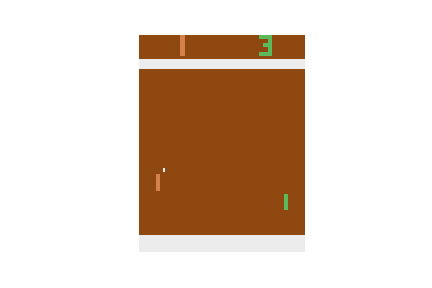
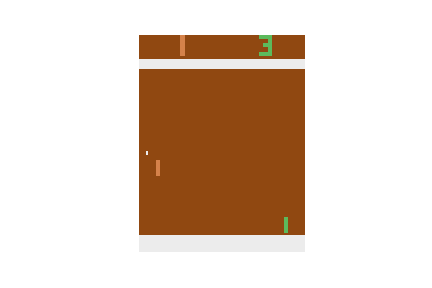
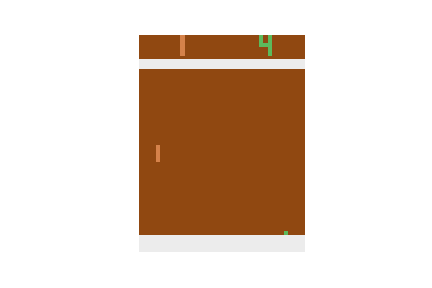
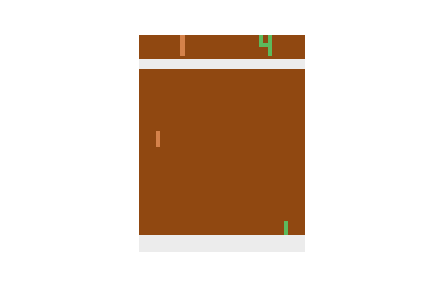
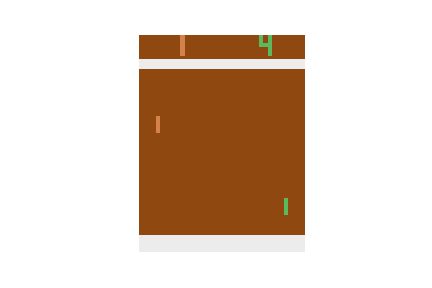
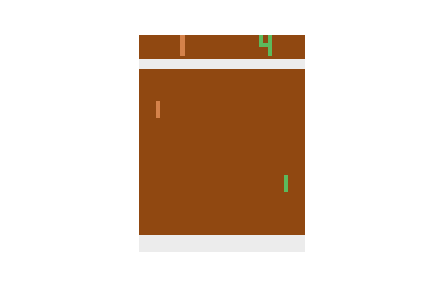
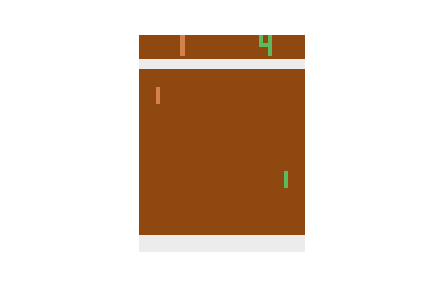
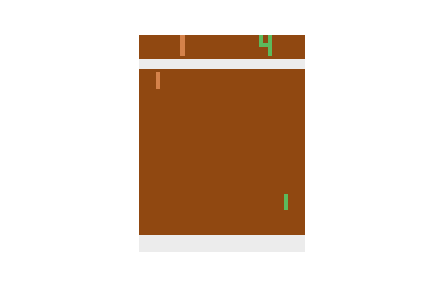
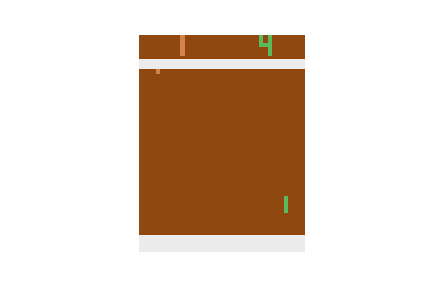
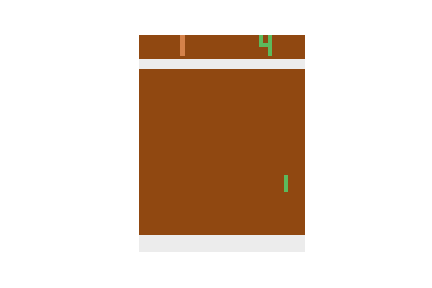
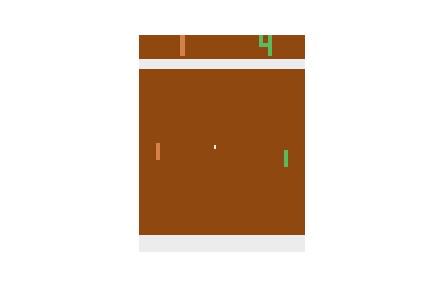
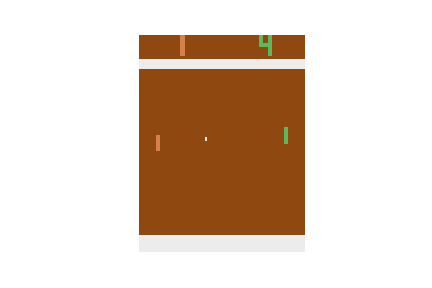
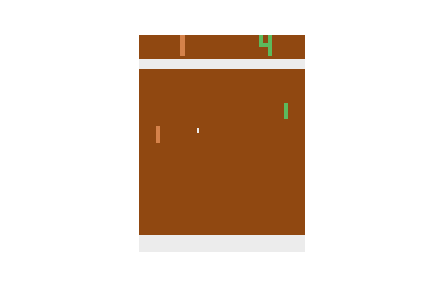
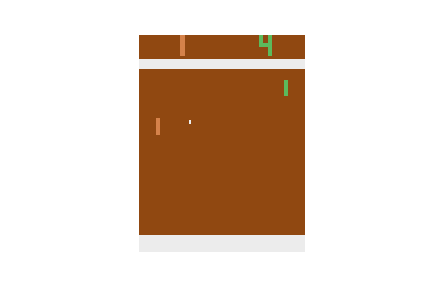
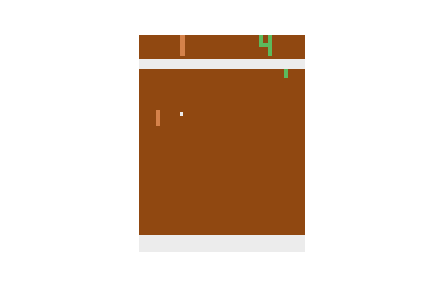
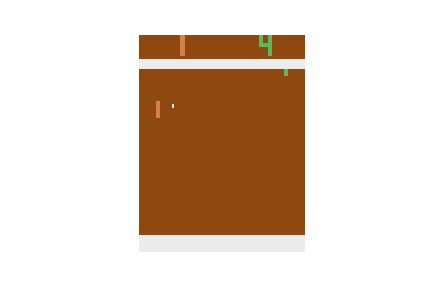
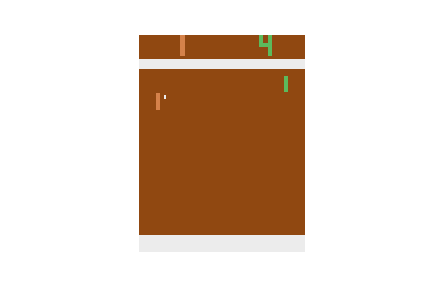
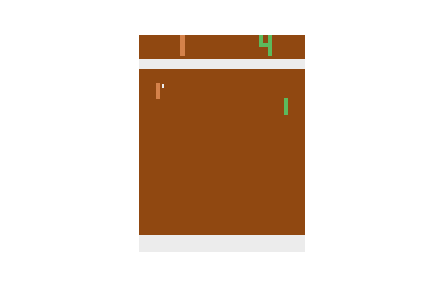
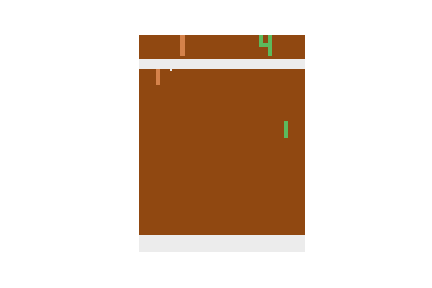
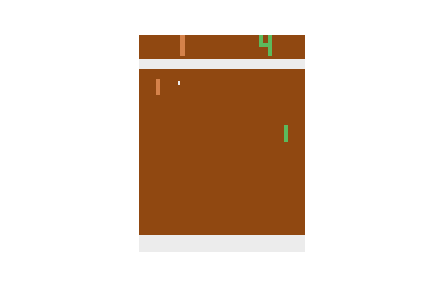
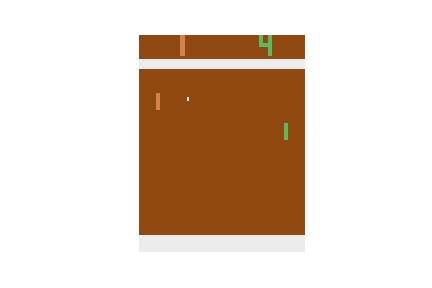
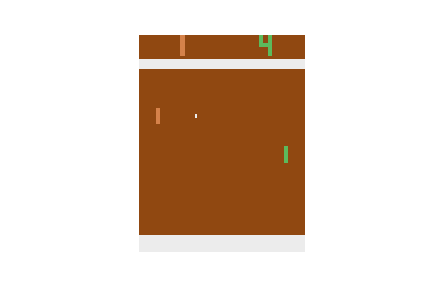
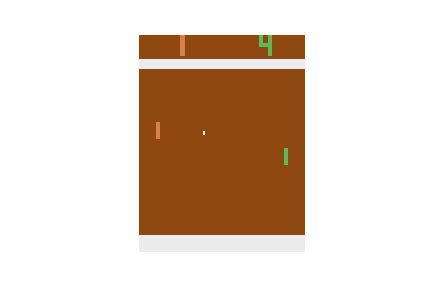
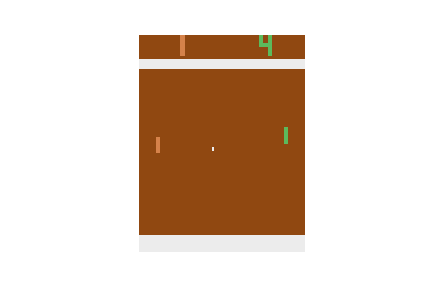
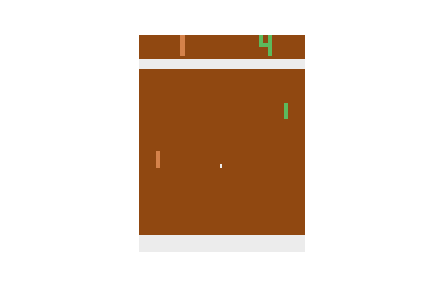
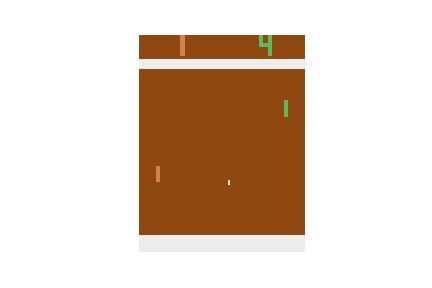
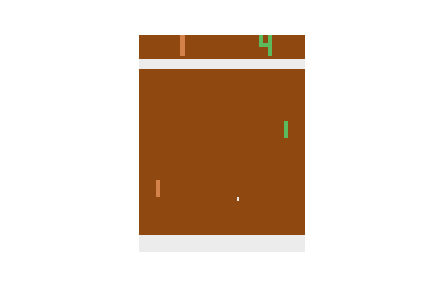
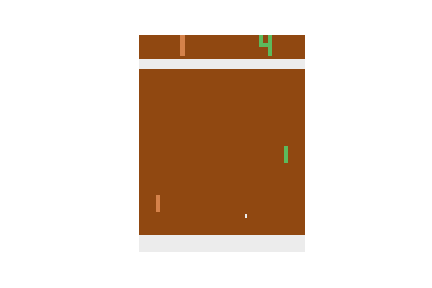
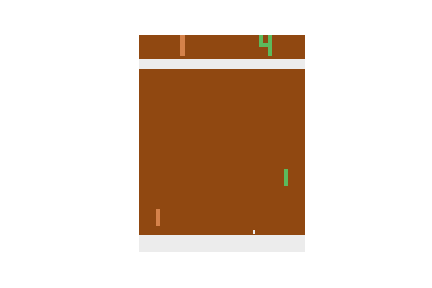
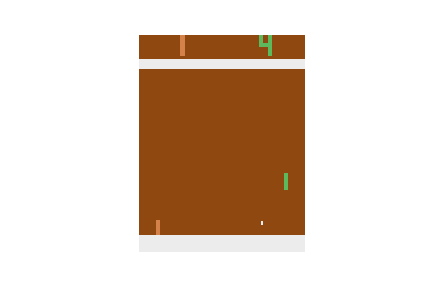
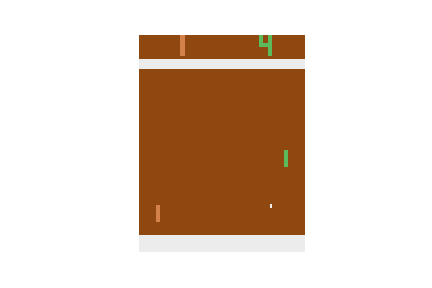
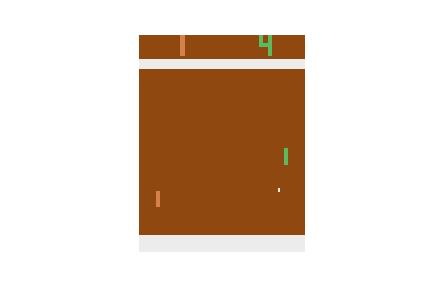
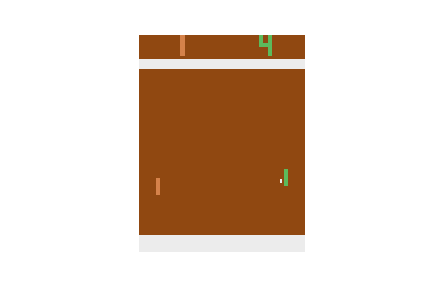
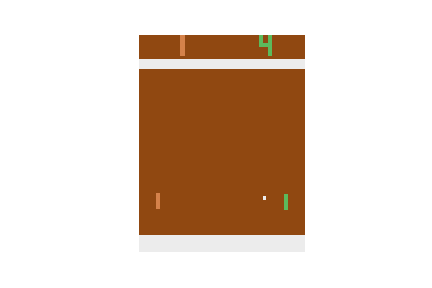
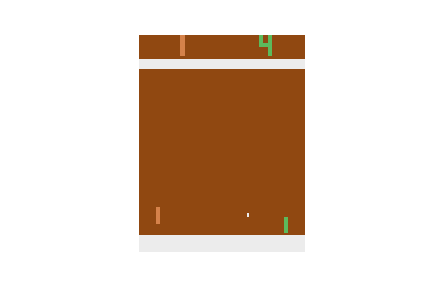
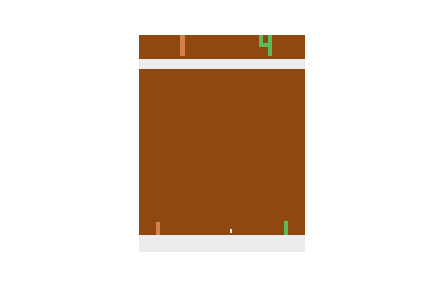
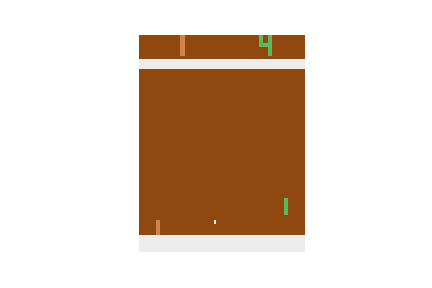
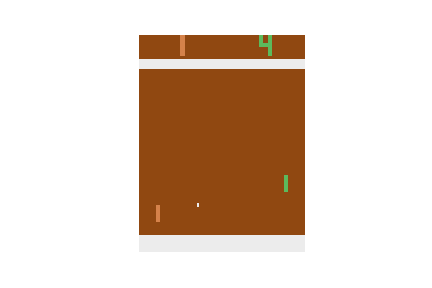
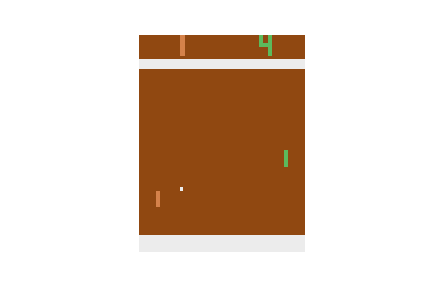
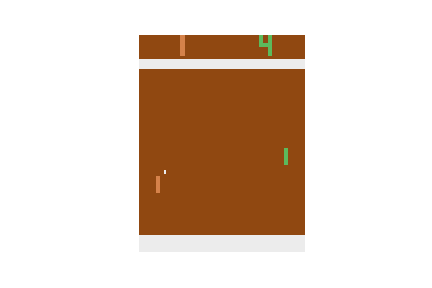
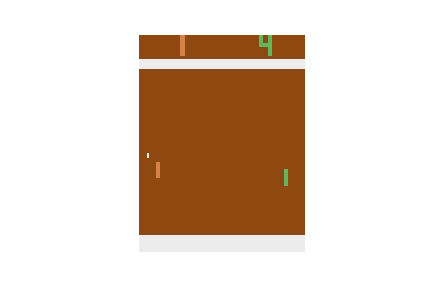
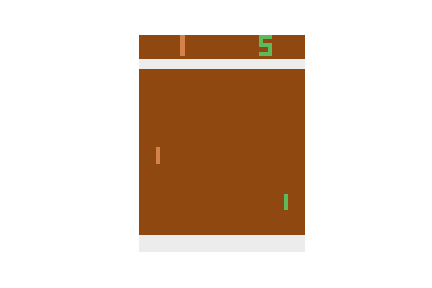
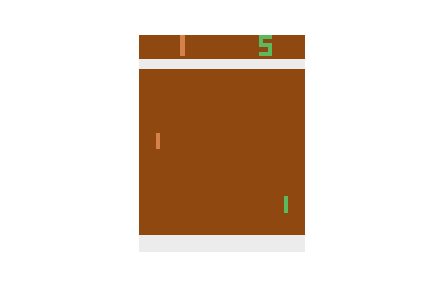
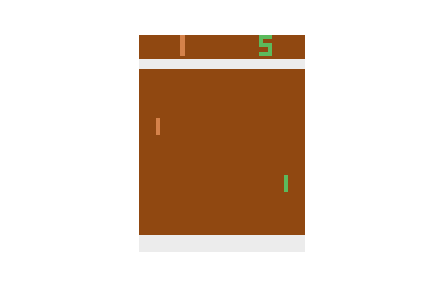
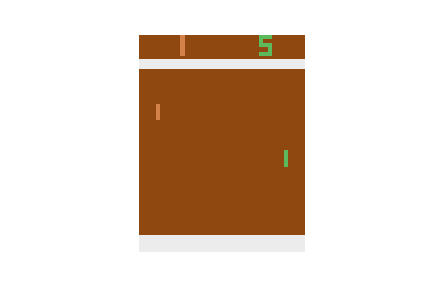
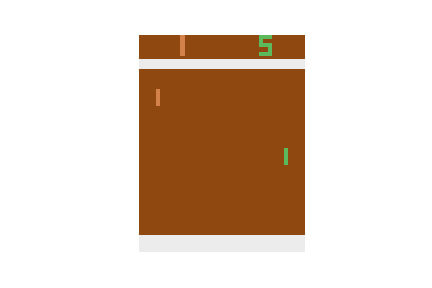
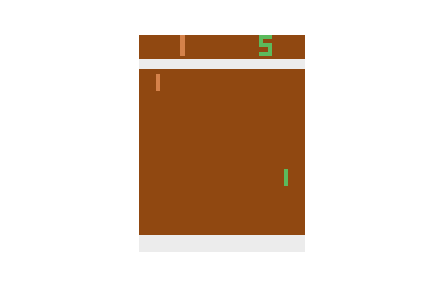
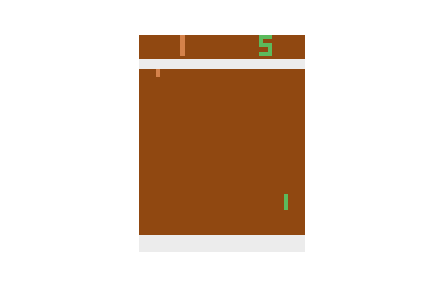
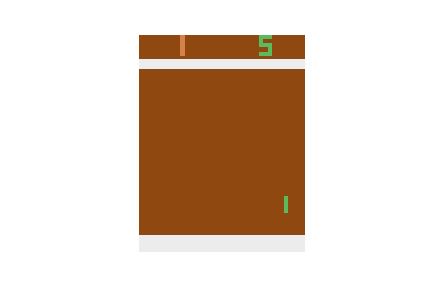
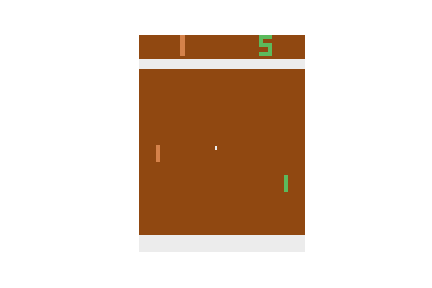
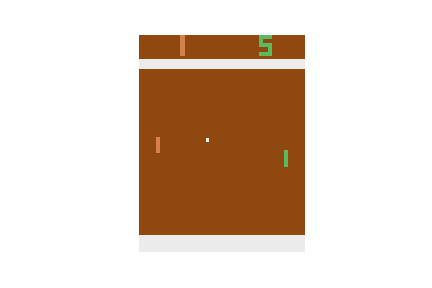
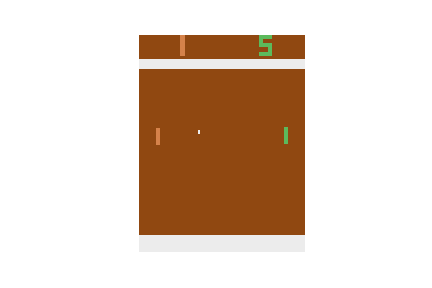
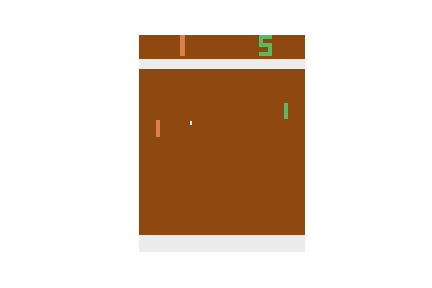
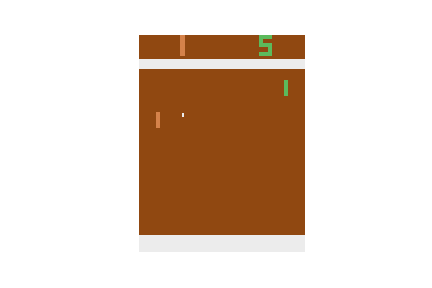
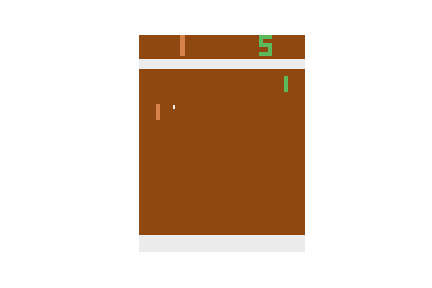
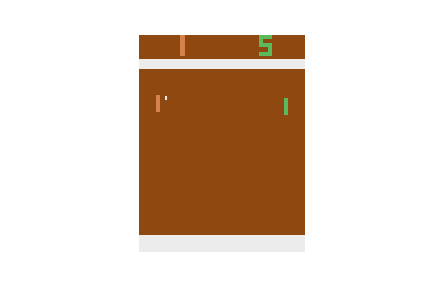
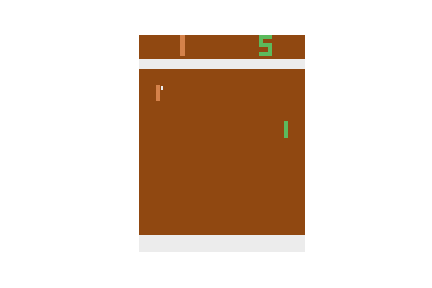
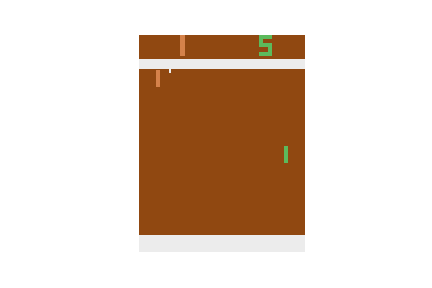
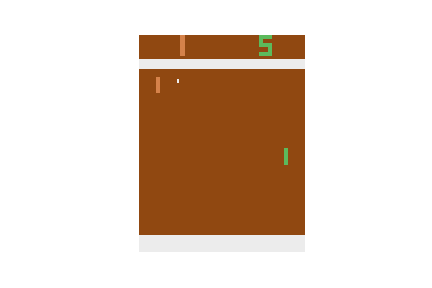
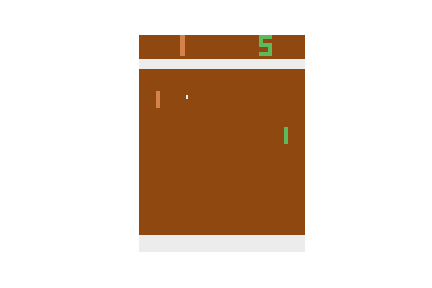
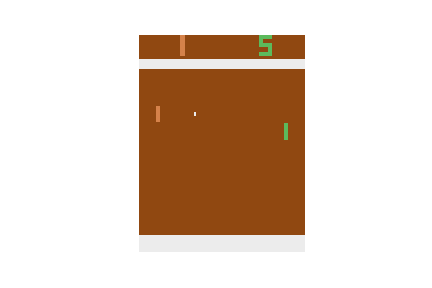
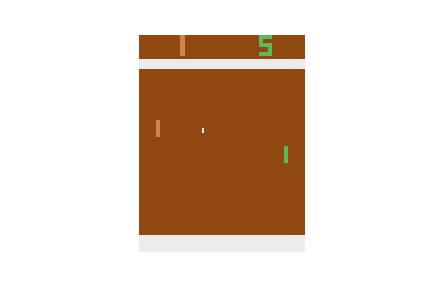
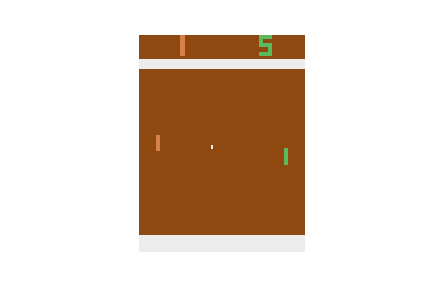
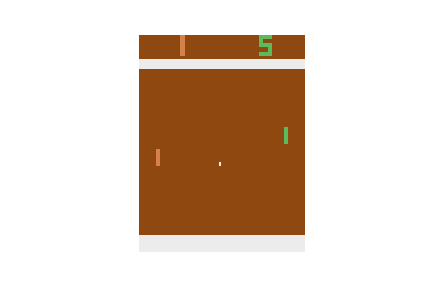
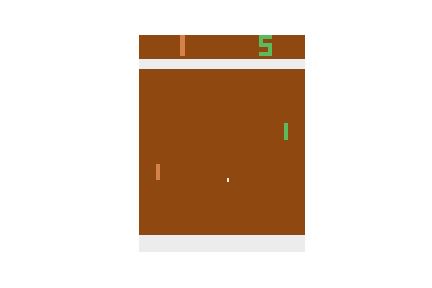
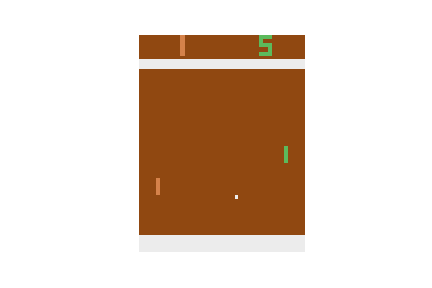
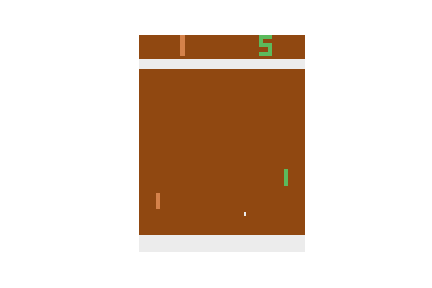
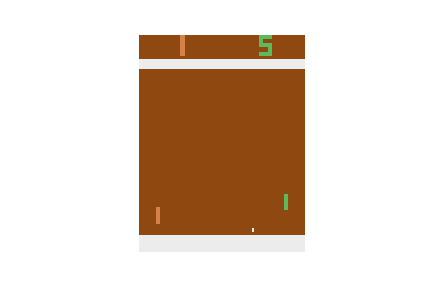
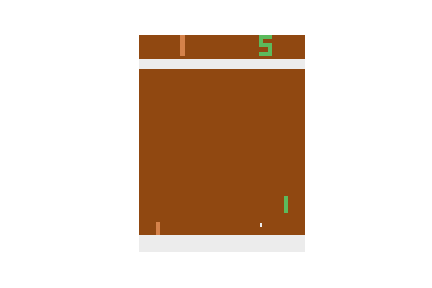
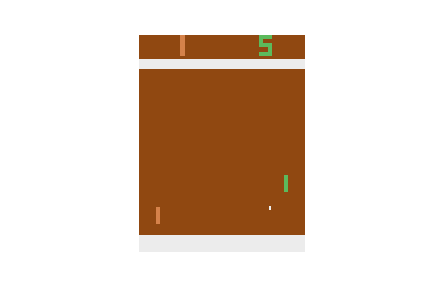
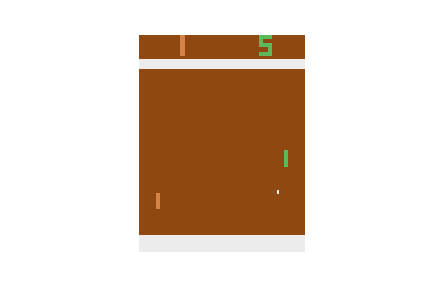
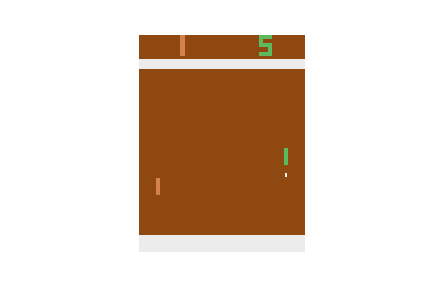
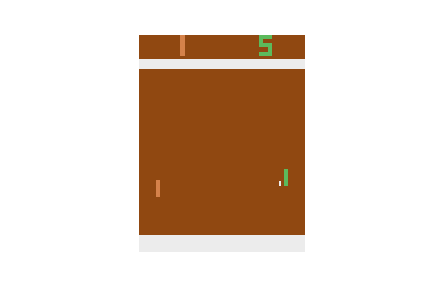
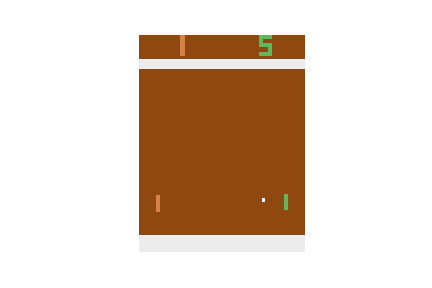
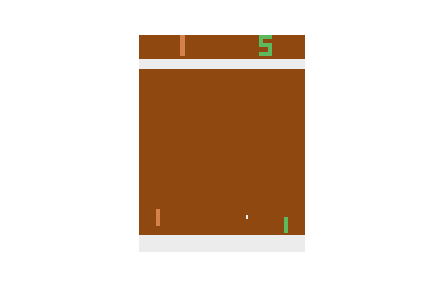
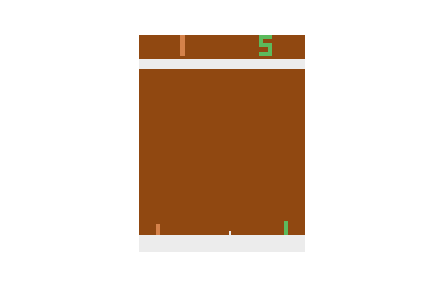
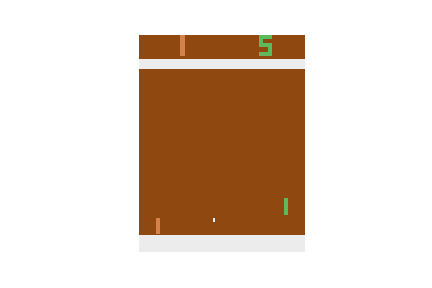
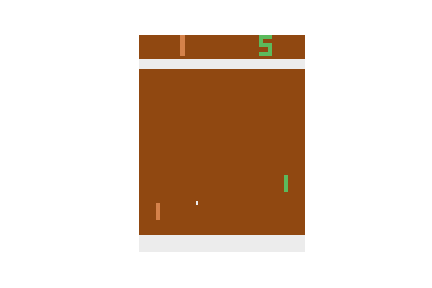
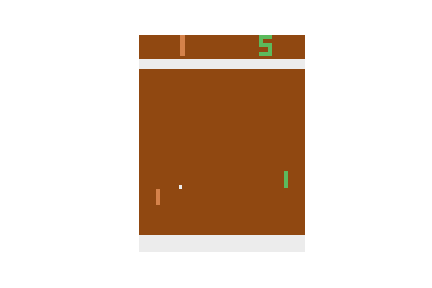
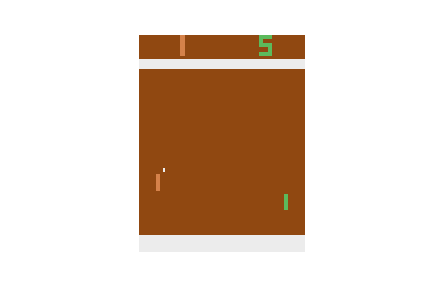
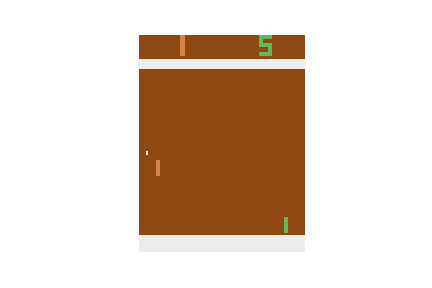
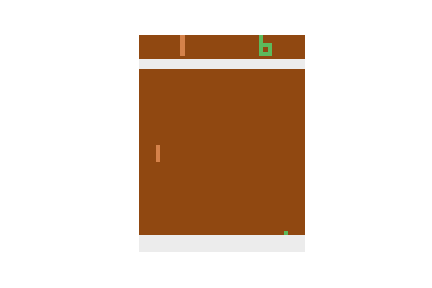
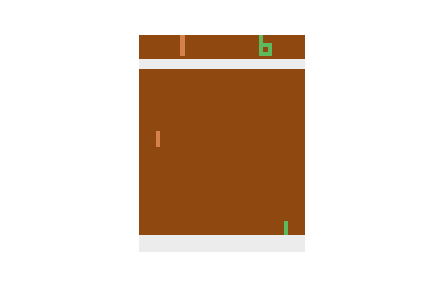
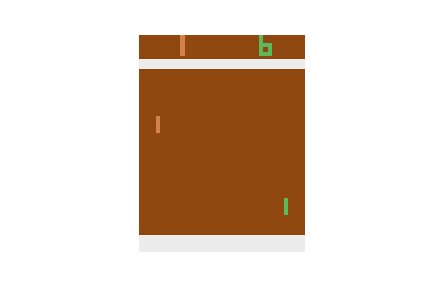
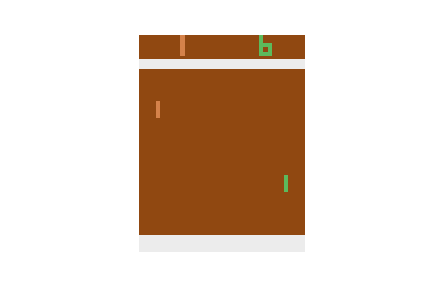
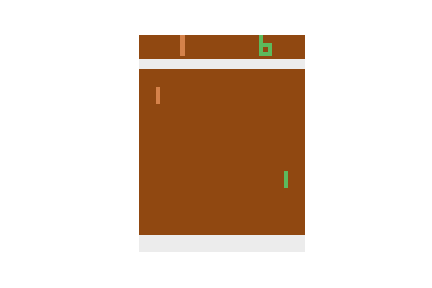
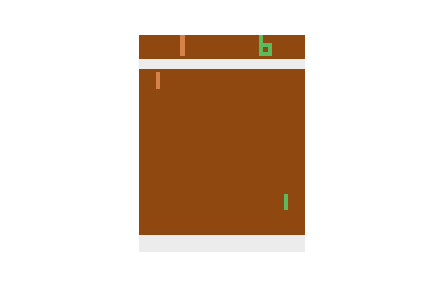
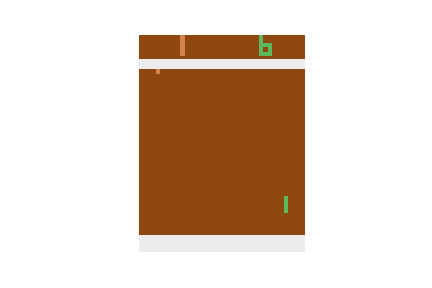
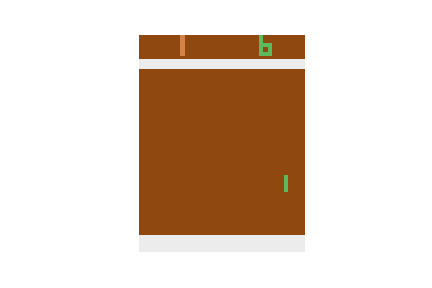
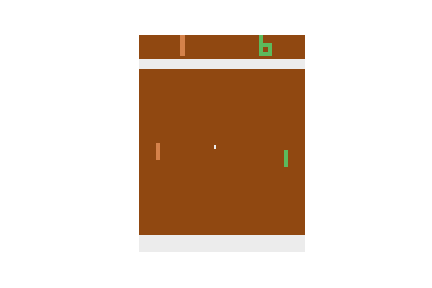
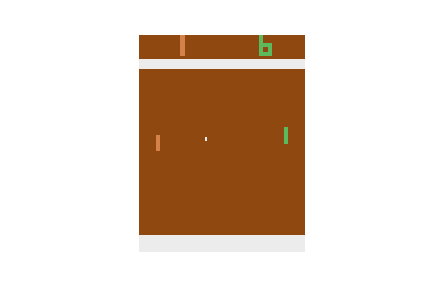
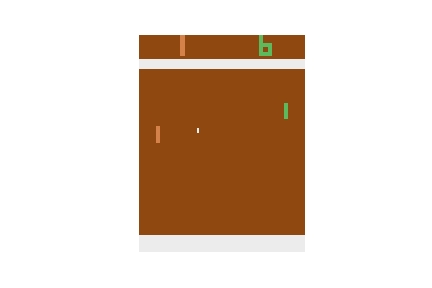
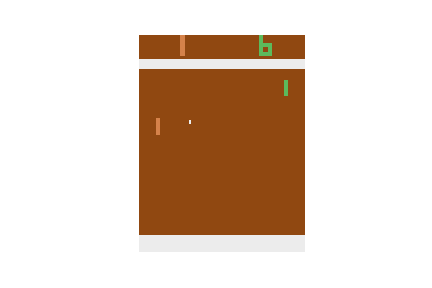
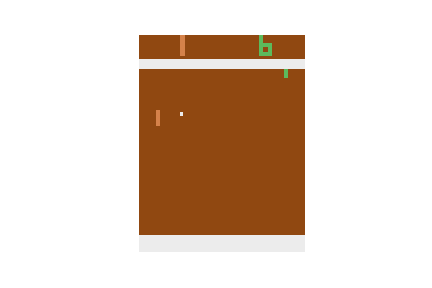
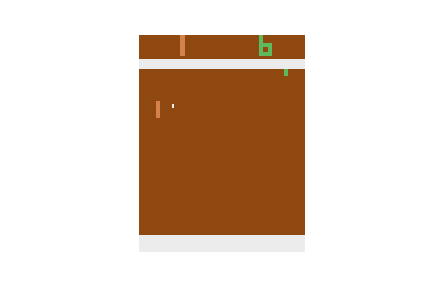
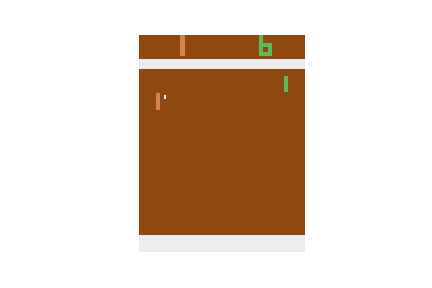
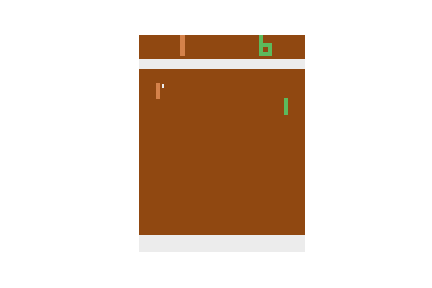
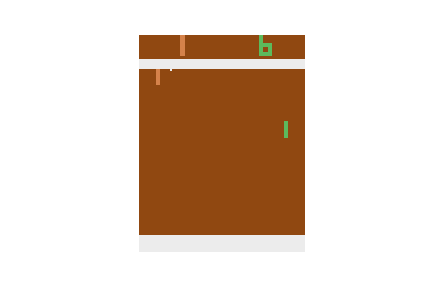
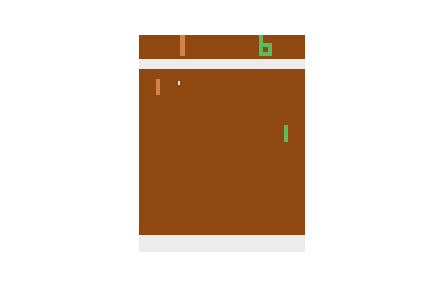
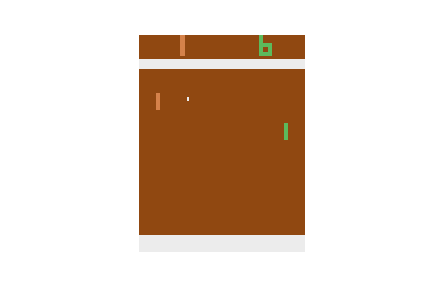
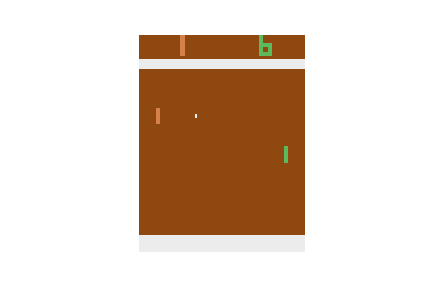
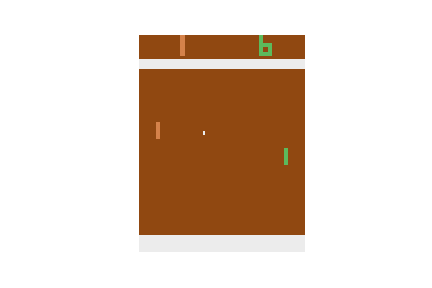
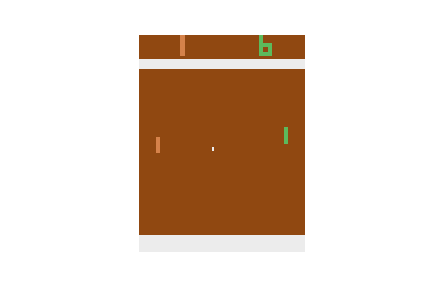
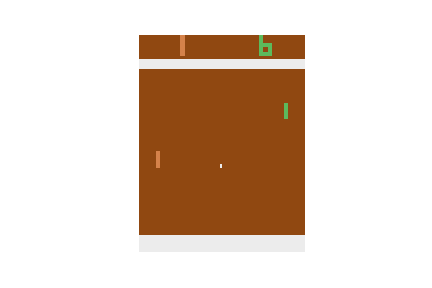
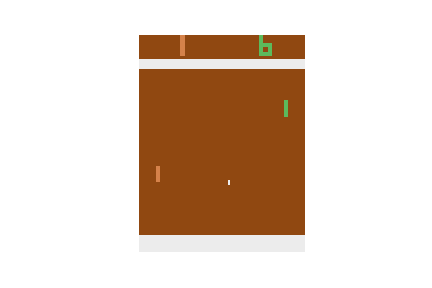
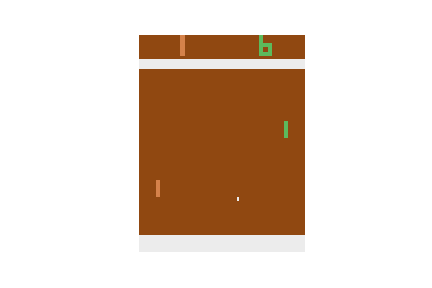
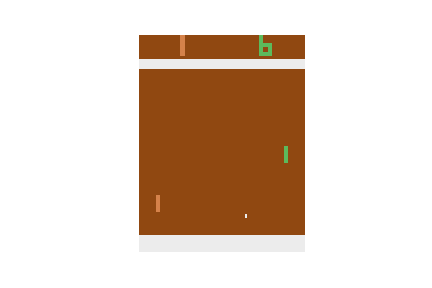
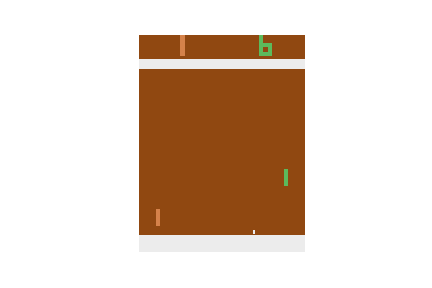
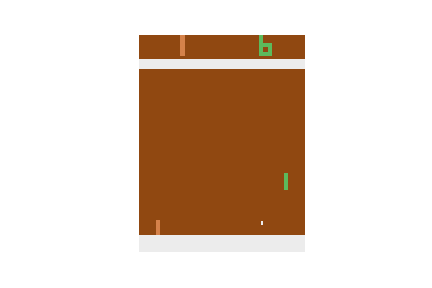
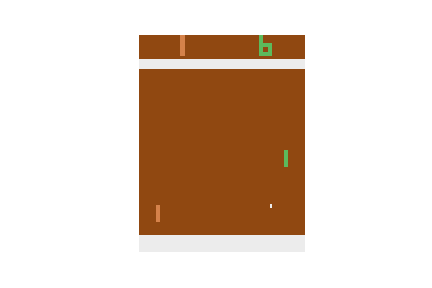
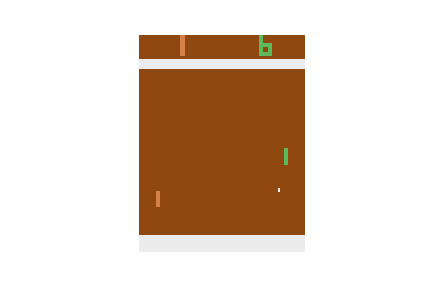
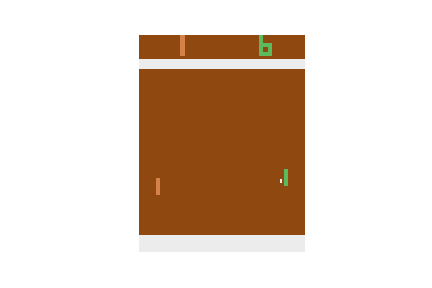
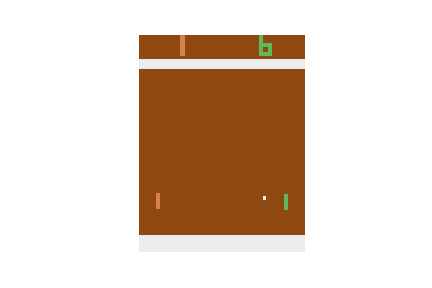
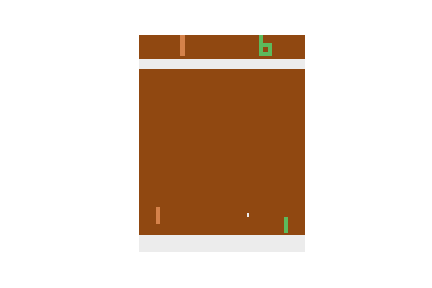
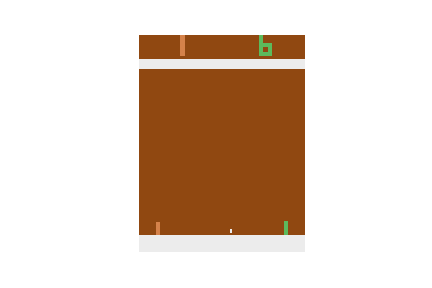
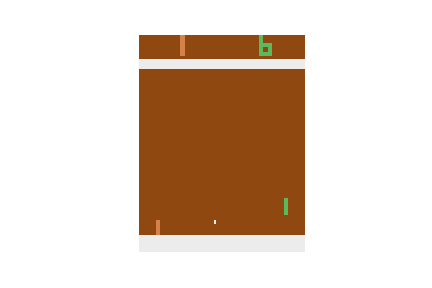
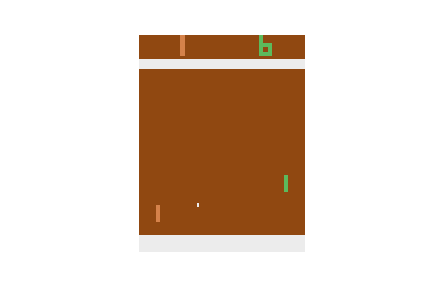
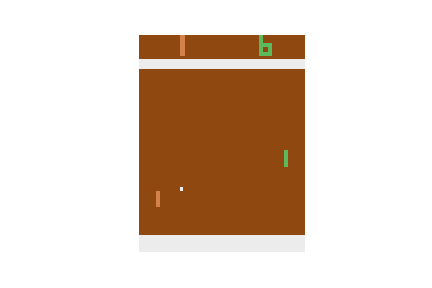
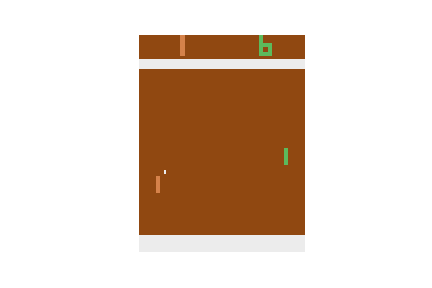
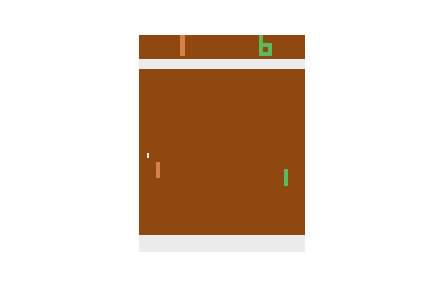
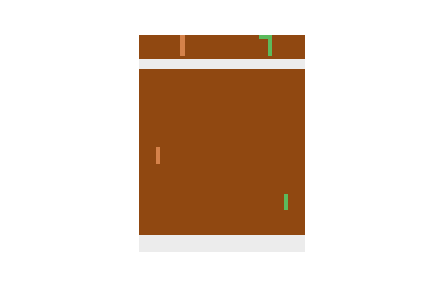
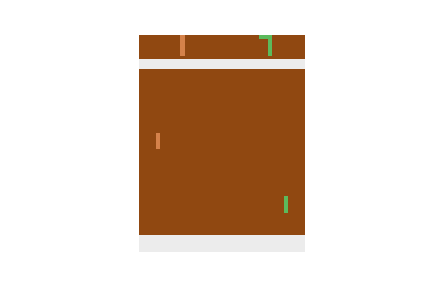
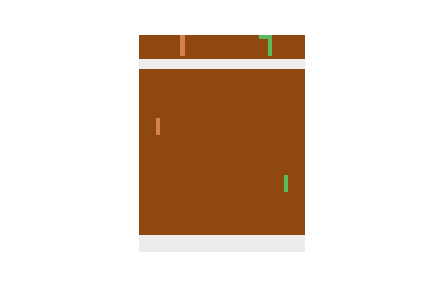
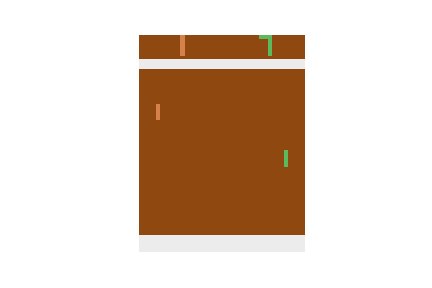
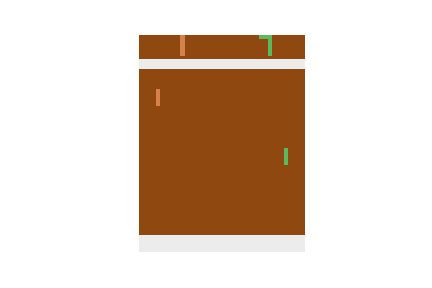
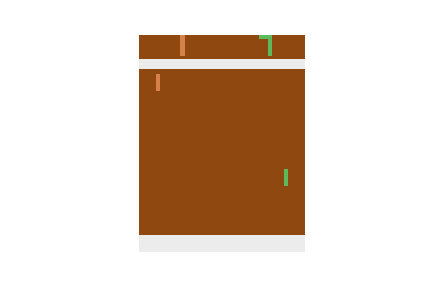
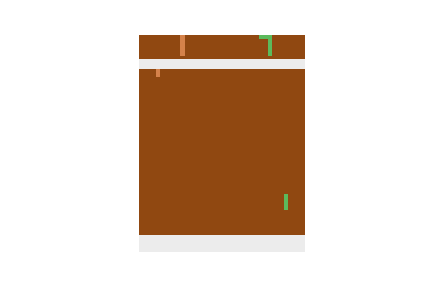
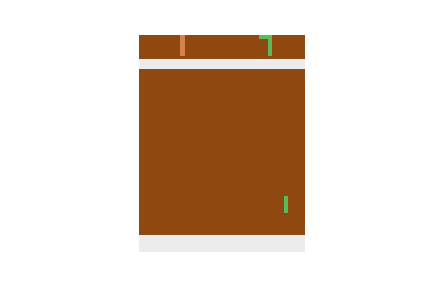
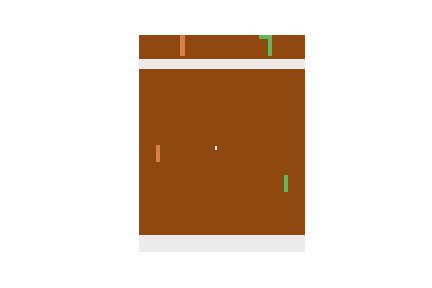
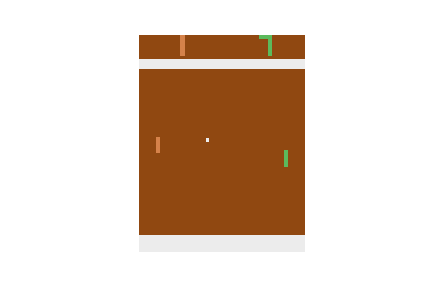
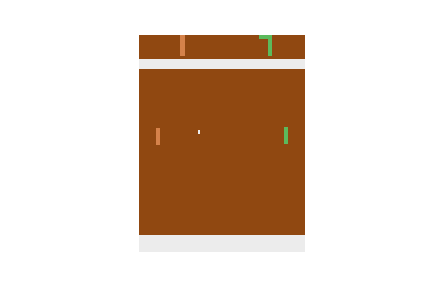
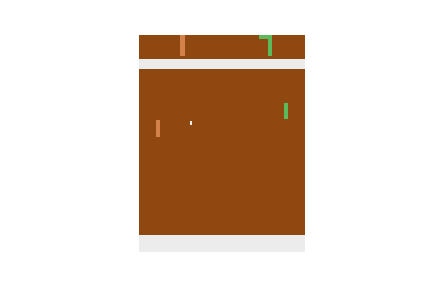
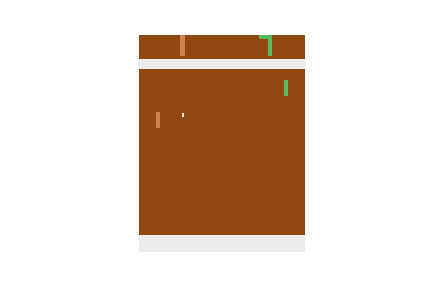
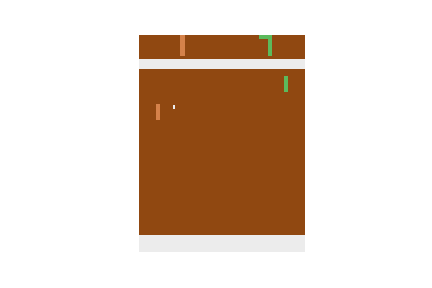
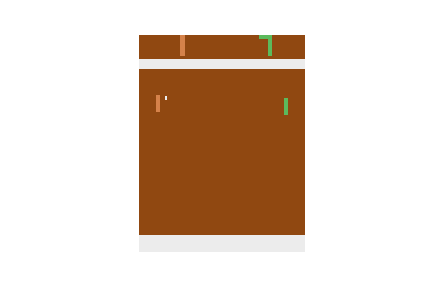
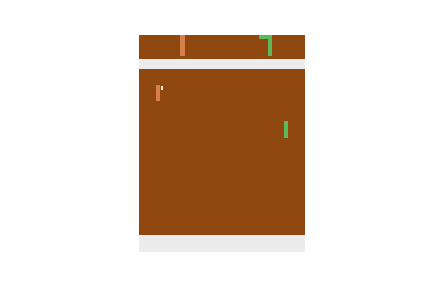
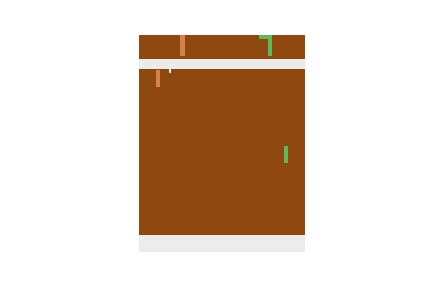
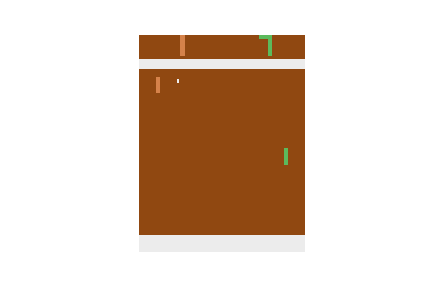
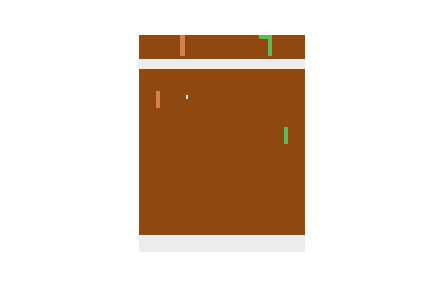
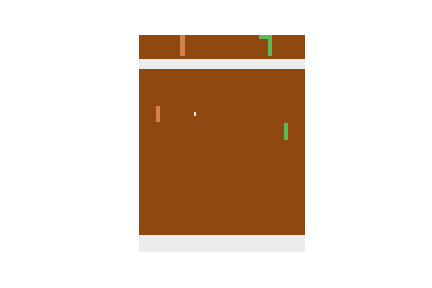
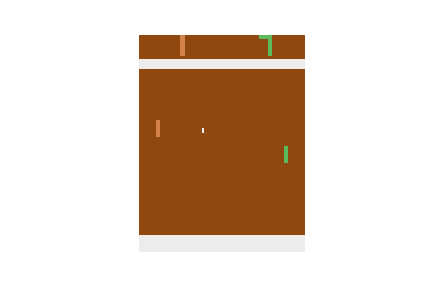
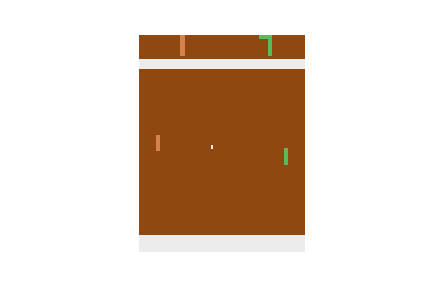
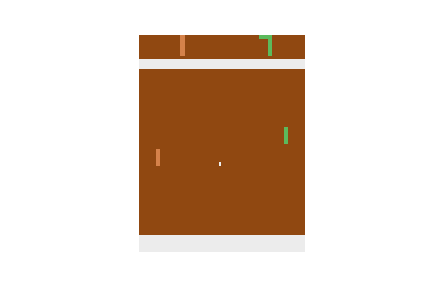
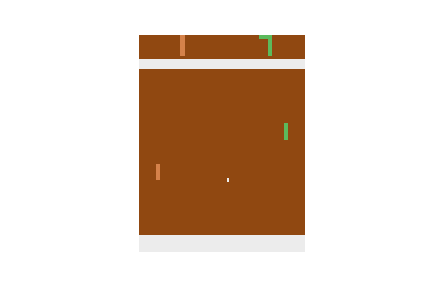
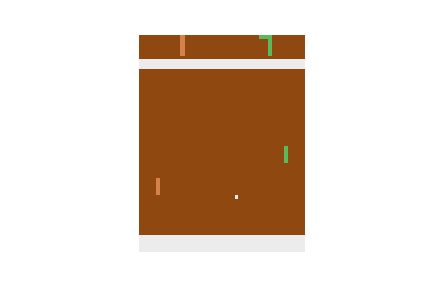
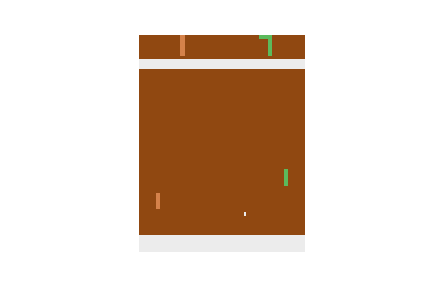
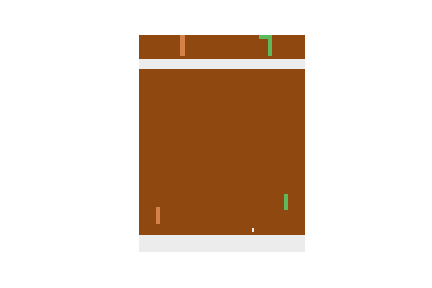
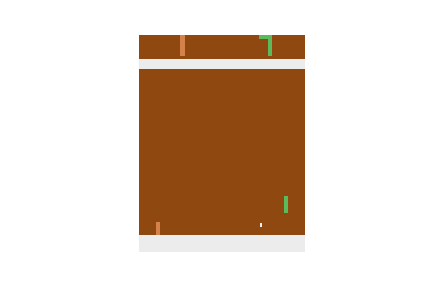
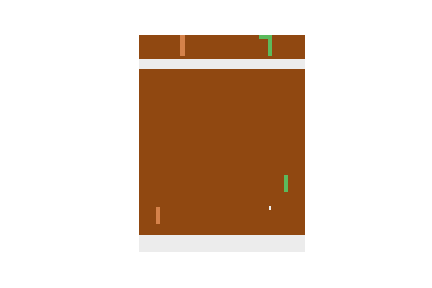
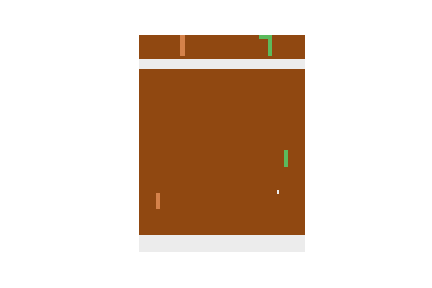
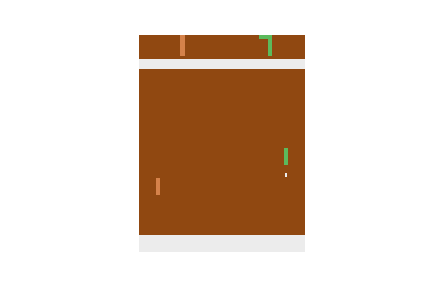
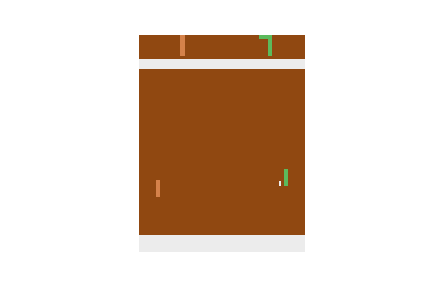
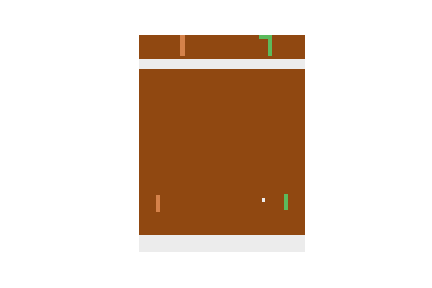
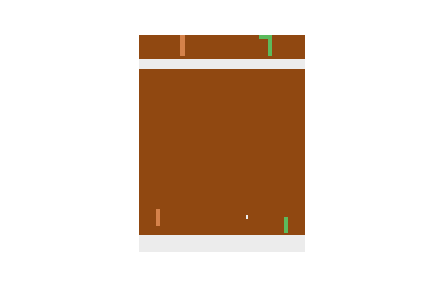
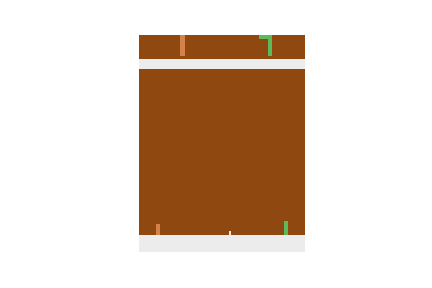
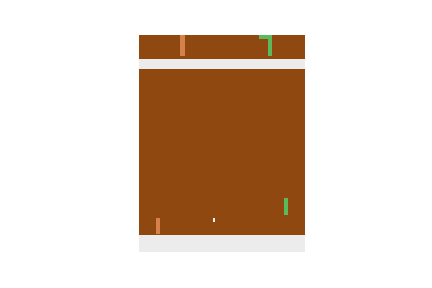
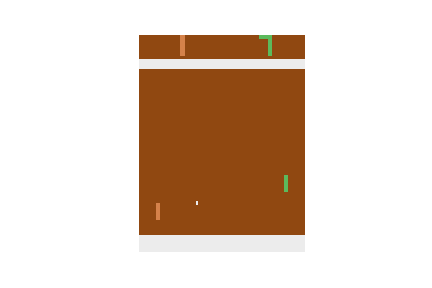
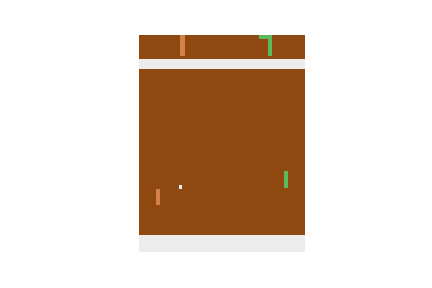
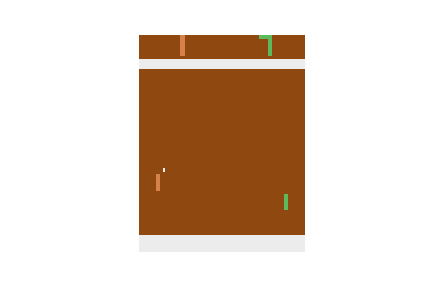
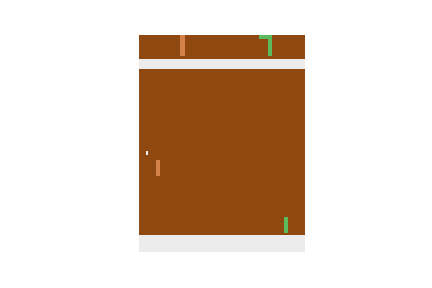
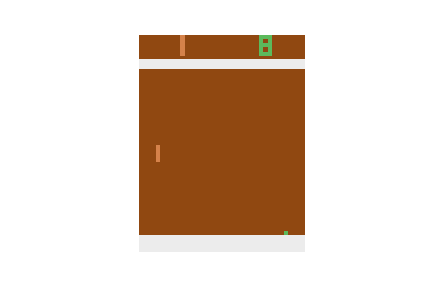
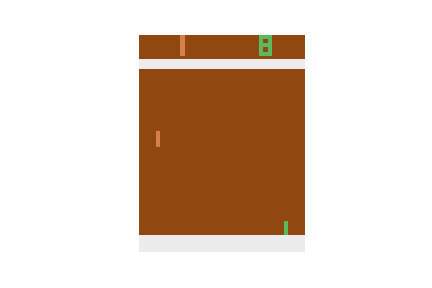
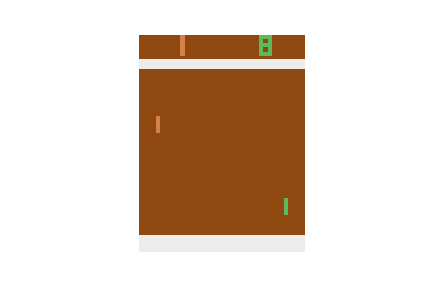
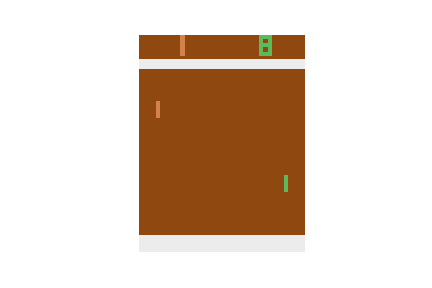
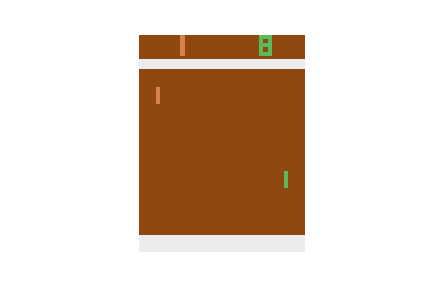
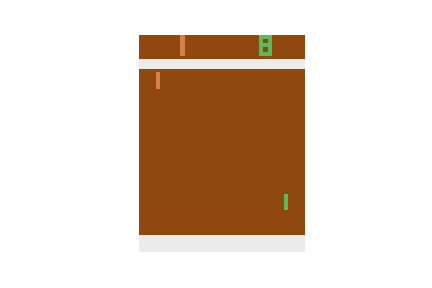
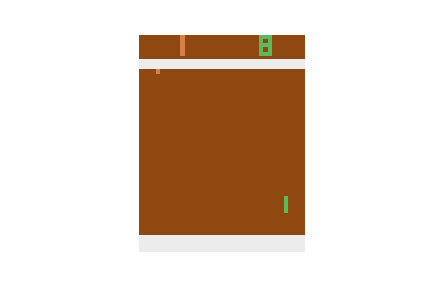
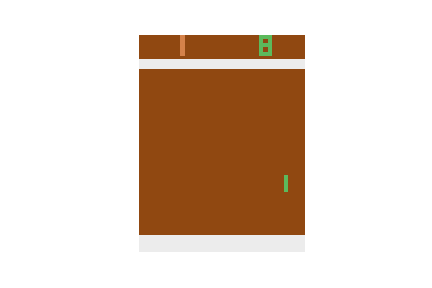
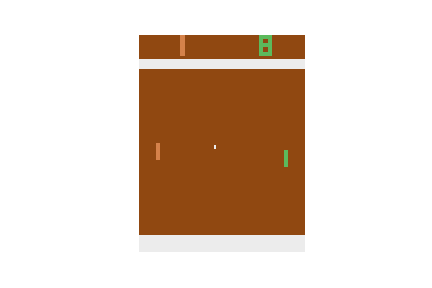
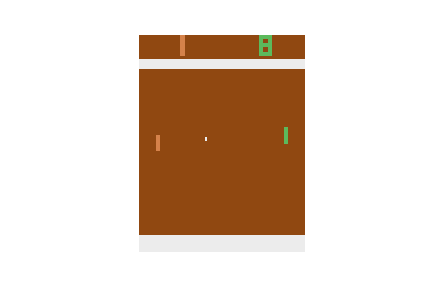
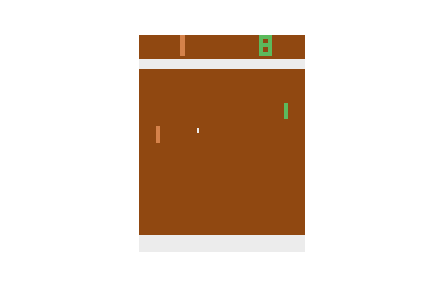
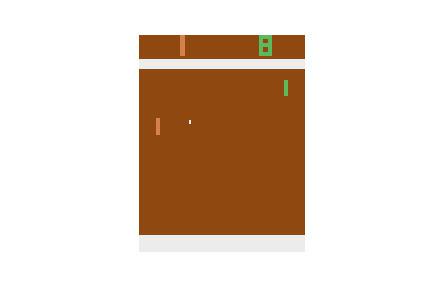
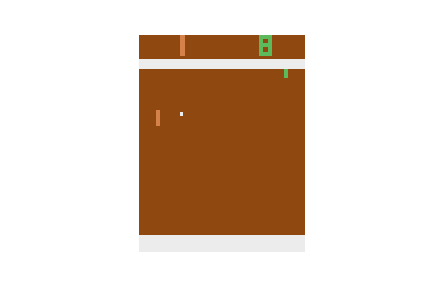
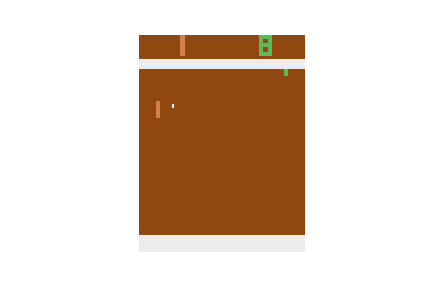
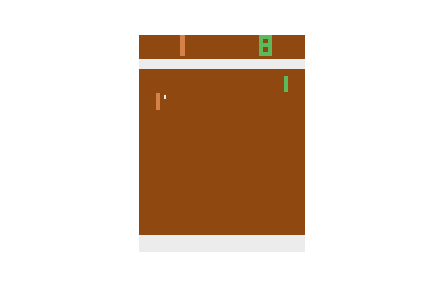
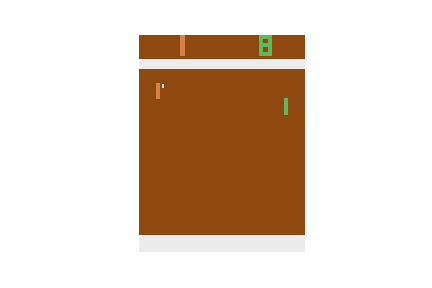
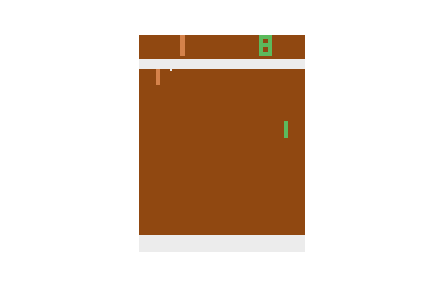
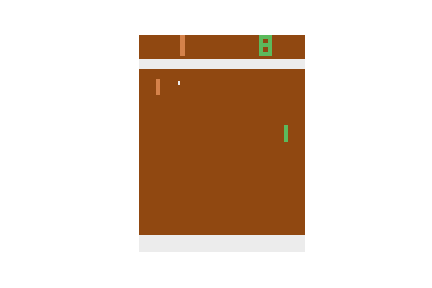
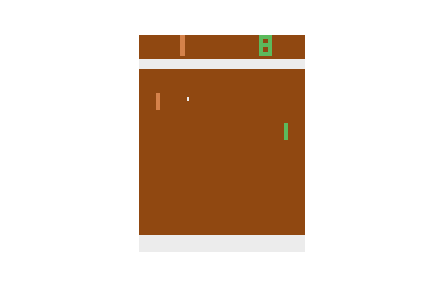
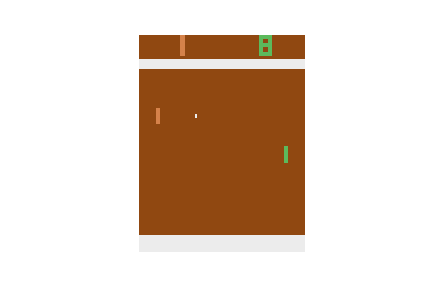
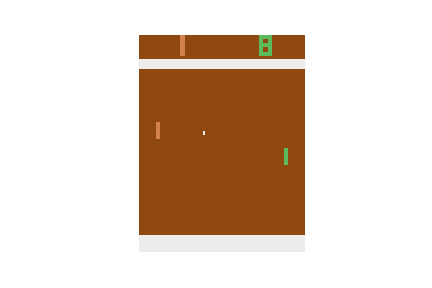
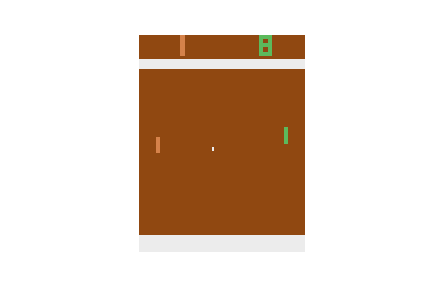
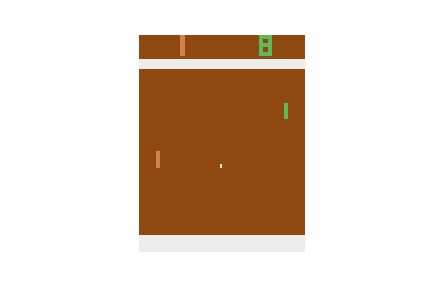
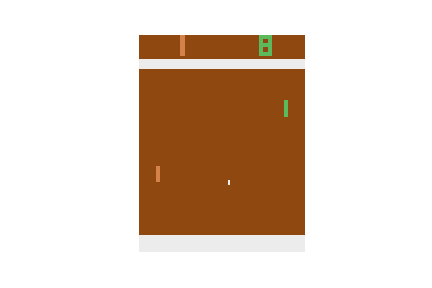
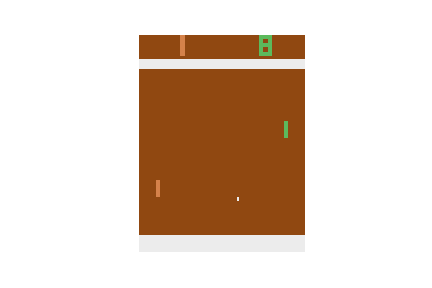
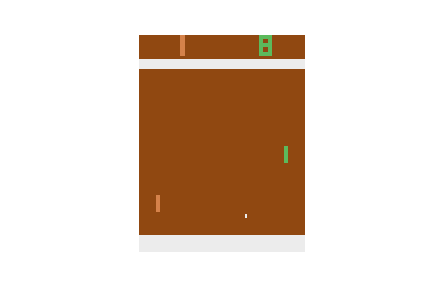
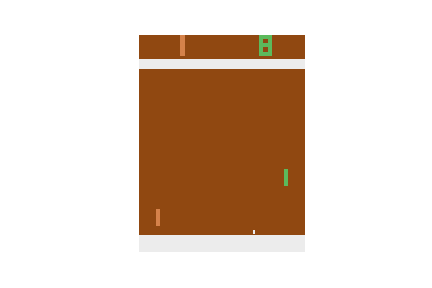

In [11]:
pong_utils.play(env, policy, time=400)